# Execute the trained model (WSI level)

In [2]:
from sourcecode.unet_model import *
from sourcecode.wsi_image_utils import *

import os
import matplotlib.pyplot as plt
%matplotlib inline

import torchvision.transforms.functional as TF
from torchvision import utils
from torch.autograd import Variable

import gc 

torch.cuda.empty_cache()
gc.collect()


dataset_dir = "../../datasets/ORCA"
model_dir = "../../models"

color_model = "LAB"
magnification = 0.625
scale = get_scale_by_magnification(magnification)
tile_size = 20
tile_size_original = int(scale * tile_size)
patch_size = (tile_size_original, tile_size_original)

use_cuda=True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") if use_cuda else "cpu"

# loads our trained fcn model
trained_model_version = "CAMELYON16+OCDC+ORCA__Size-640x640_Epoch-100_Images-4181_Batch-1"
trained_model_path="{}/{}".format(model_dir, '{}.pth'.format(trained_model_version))

if not os.path.isfile(trained_model_path):
    
    logger.info("Trained model not found: '{}'.".format(trained_model_path))
    
else:

    model = load_checkpoint(file_path=trained_model_path, img_input_size=patch_size, use_cuda=use_cuda)
    
    dataset_type = "testing"
    classes = ["tumor"]
    for cls in classes:

        annotations_dir = "{}/{}/lesion_annotations".format(dataset_dir, dataset_type)
        wsi_images_dir = "{}/{}/{}/wsi".format(dataset_dir, dataset_type, cls)
        patch_images_dir = "{}/{}/{}/patch/640x640".format(dataset_dir, dataset_type, cls)
        patch_images_results_dir = "{}/results/{}/{}/{}/patch/640x640".format(dataset_dir, trained_model_version, dataset_type, cls)
        wsi_images_results_dir = "{}/results/{}/{}/{}/wsi".format(dataset_dir, trained_model_version, dataset_type, cls)
        
        for r, d, f in sorted(os.walk(wsi_images_dir)):
            for wsi_file in sorted(f):

                wsi_image_file = "{}/{}".format(r, wsi_file)
                wsi_image_number = wsi_file.replace(".png", "")
                
                file_is_png = wsi_image_file.lower().endswith('.png')
                if file_is_png:

                    logger.info("Processing wsi '{}'".format(wsi_file))
                    if not os.path.isfile(wsi_image_file):
                        logger.info("WSI image not found: '{}'.".format(wsi_file))
                        break
                    
                    # check directory to save image-patches
                    dir_to_save = "{}/{}".format(patch_images_results_dir, wsi_image_number)
                    if not os.path.exists(dir_to_save):
                        os.makedirs("{}/{}".format(wsi_images_results_dir, wsi_image_number))
                        os.makedirs("{}/01-unet_result".format(dir_to_save))
                        
                    # scale down image
                    wsi_image = open_wsi(wsi_image_file)
                    pil_scaled_down_image = scale_down_wsi(wsi_image, magnification, False)
                    np_scaled_down_image = pil_to_np(pil_scaled_down_image)

                    # extract tissue region 
                    np_tissue_mask, np_masked_image = extract_normal_region_from_wsi(wsi_image_file, np_scaled_down_image, None)
                    pil_masked_image = np_to_pil(np_masked_image)
                    max_w = np_masked_image.shape[0]
                    max_h = np_masked_image.shape[1]
                    
                    # draw the heat grid
                    pil_img_result, heat_grid, number_of_tiles = draw_heat_grid(np_masked_image, tile_size)

                    # save scaled down wsi
                    utils.save_image(TF.to_tensor(pil_scaled_down_image), '{}/{}/{}.png'.format(wsi_images_results_dir, wsi_image_number, wsi_image_number))
                    utils.save_image(TF.to_tensor(pil_masked_image), '{}/{}/{}__tissue.png'.format(wsi_images_results_dir, wsi_image_number, wsi_image_number))
                    utils.save_image(TF.to_tensor(pil_img_result), '{}/{}/{}__tissuegrid.png'.format(wsi_images_results_dir, wsi_image_number, wsi_image_number))
                    
                    
                    # run the model
                    count_tiles = 0
                    count_roi_tiles = 0
                    for idx, (position, row, column, location, size, color) in enumerate(heat_grid):

                        if color != GREEN_COLOR:

                            count_tiles += 1

                            #r_s = row * tile_size
                            #r_e = r_s + tile_size
                            #c_s = column * tile_size
                            #c_e = c_s + tile_size                            
                            
                            r_s = row * tile_size
                            r_e = r_s + (tile_size if (r_s + tile_size) <= max_w else (max_w - r_s))
                            c_s = column * tile_size
                            c_e = c_s + (tile_size if (c_s + tile_size) <= max_h else (max_h - c_s))
                            np_tile_masked = np_masked_image[r_s:r_e, c_s:c_e]

                            # only tile with valid size
                            #if np_tile_masked.shape[0] == tile_size and np_tile_masked.shape[1] == tile_size:

                            # read the tile from the original wsi image
                            pil_input_tile, np_input_tile = read_region(wsi_image_file, column, row, magnification, tile_size)

                            # run the model
                            if color_model == "LAB":
                                np_input_tile = rgb_to_lab(np_input_tile)

                            X = torch.from_numpy(np_input_tile).permute(2, 0, 1).float()
                            X = Variable(X.unsqueeze(0)).to(device) if use_cuda else X.unsqueeze(0)
                            y_hat = model(X).detach().cpu().squeeze(0)
                            #y_hat = model(X).squeeze(0)
                            output_tile = y_hat[0]
                            np_output_tile = output_tile.squeeze(0).detach().cpu().numpy()
                            #

                            # only tiles that something was found by model
                            if np.any(np.unique(np_output_tile >= 0.1)):

                                # save the output image-patch results
                                utils.save_image(output_tile, '{}/01-unet_result/{}_r{}c{}.png'.format(dir_to_save, wsi_image_number, row, column))

                                np_output_tile[np_output_tile > 0] = 1
                                count_roi_tiles += 1

                    logger.info("\t '{}/{}/{}' tiles identified as ROI by model".format(count_roi_tiles, count_tiles, len(heat_grid)))
                    logger.info("-")


2021-04-12 21:14:44,782 :: INFO load_checkpoint :: 	 Model loaded on: cpu / 3 / 1 / (640, 640) -> ../../models/CAMELYON16+OCDC+ORCA__Size-640x640_Epoch-100_Images-4181_Batch-1.pth
2021-04-12 21:14:44,791 :: INFO <module> :: Processing wsi 'TCGA-CN-4723-01Z-00-DX1.13483e7b-9322-4d39-8cd6-91e898bf2ee9_0.png'
2021-04-12 21:14:45,493 :: INFO extract_normal_region_from_wsi :: 	 Extracting normal regions from wsi image: 'TCGA-CN-4723-01Z-00-DX1.13483e7b-9322-4d39-8cd6-91e898bf2ee9_0.png'
2021-04-12 21:21:54,023 :: INFO <module> :: 	 '42/45/49' tiles identified as ROI by model
2021-04-12 21:21:54,024 :: INFO <module> :: -
2021-04-12 21:21:54,025 :: INFO <module> :: Processing wsi 'TCGA-CN-4723-01Z-00-DX1.13483e7b-9322-4d39-8cd6-91e898bf2ee9_1.png'
2021-04-12 21:21:55,470 :: INFO extract_normal_region_from_wsi :: 	 Extracting normal regions from wsi image: 'TCGA-CN-4723-01Z-00-DX1.13483e7b-9322-4d39-8cd6-91e898bf2ee9_1.png'
2021-04-12 21:27:58,038 :: INFO <module> :: 	 '45/45/49' tiles identif

2021-04-12 22:58:16,487 :: INFO extract_normal_region_from_wsi :: 	 Extracting normal regions from wsi image: 'TCGA-CN-4734-01Z-00-DX1.9cd35e43-7132-478a-9d08-a88d150b7127_0.png'
2021-04-12 23:04:05,670 :: INFO <module> :: 	 '43/45/49' tiles identified as ROI by model
2021-04-12 23:04:05,672 :: INFO <module> :: -
2021-04-12 23:04:05,673 :: INFO <module> :: Processing wsi 'TCGA-CN-4734-01Z-00-DX1.9cd35e43-7132-478a-9d08-a88d150b7127_1.png'
2021-04-12 23:04:06,969 :: INFO extract_normal_region_from_wsi :: 	 Extracting normal regions from wsi image: 'TCGA-CN-4734-01Z-00-DX1.9cd35e43-7132-478a-9d08-a88d150b7127_1.png'
2021-04-12 23:09:54,135 :: INFO <module> :: 	 '43/45/49' tiles identified as ROI by model
2021-04-12 23:09:54,136 :: INFO <module> :: -
2021-04-12 23:09:54,136 :: INFO <module> :: Processing wsi 'TCGA-CN-4735-01Z-00-DX1.b7d37666-bd65-4d3b-826b-97e560444956_0.png'
2021-04-12 23:09:55,430 :: INFO extract_normal_region_from_wsi :: 	 Extracting normal regions from wsi image: 'TCG

2021-04-13 00:48:38,107 :: INFO <module> :: -
2021-04-13 00:48:38,108 :: INFO <module> :: Processing wsi 'TCGA-CN-5355-01Z-00-DX1.8fb23e44-fc59-4191-b825-cc021807a338_1.png'
2021-04-13 00:48:39,405 :: INFO extract_normal_region_from_wsi :: 	 Extracting normal regions from wsi image: 'TCGA-CN-5355-01Z-00-DX1.8fb23e44-fc59-4191-b825-cc021807a338_1.png'
2021-04-13 00:54:32,965 :: INFO <module> :: 	 '44/45/49' tiles identified as ROI by model
2021-04-13 00:54:32,967 :: INFO <module> :: -
2021-04-13 00:54:32,968 :: INFO <module> :: Processing wsi 'TCGA-CN-5356-01Z-00-DX1.53360c41-d0d2-465e-8b53-ccd1a2ce248f_0.png'
2021-04-13 00:54:34,351 :: INFO extract_normal_region_from_wsi :: 	 Extracting normal regions from wsi image: 'TCGA-CN-5356-01Z-00-DX1.53360c41-d0d2-465e-8b53-ccd1a2ce248f_0.png'
2021-04-13 01:00:24,867 :: INFO <module> :: 	 '39/45/49' tiles identified as ROI by model
2021-04-13 01:00:24,868 :: INFO <module> :: -
2021-04-13 01:00:24,869 :: INFO <module> :: Processing wsi 'TCGA-CN-

2021-04-13 02:38:39,952 :: INFO <module> :: 	 '41/45/49' tiles identified as ROI by model
2021-04-13 02:38:39,953 :: INFO <module> :: -
2021-04-13 02:38:39,956 :: INFO <module> :: Processing wsi 'TCGA-CN-5367-01Z-00-DX1.5b09e54e-4140-4709-bc60-e201f9a72b24_0.png'
2021-04-13 02:38:41,439 :: INFO extract_normal_region_from_wsi :: 	 Extracting normal regions from wsi image: 'TCGA-CN-5367-01Z-00-DX1.5b09e54e-4140-4709-bc60-e201f9a72b24_0.png'
2021-04-13 02:44:28,227 :: INFO <module> :: 	 '43/45/49' tiles identified as ROI by model
2021-04-13 02:44:28,228 :: INFO <module> :: -
2021-04-13 02:44:28,229 :: INFO <module> :: Processing wsi 'TCGA-CN-5367-01Z-00-DX1.5b09e54e-4140-4709-bc60-e201f9a72b24_1.png'
2021-04-13 02:44:29,619 :: INFO extract_normal_region_from_wsi :: 	 Extracting normal regions from wsi image: 'TCGA-CN-5367-01Z-00-DX1.5b09e54e-4140-4709-bc60-e201f9a72b24_1.png'
2021-04-13 02:50:19,234 :: INFO <module> :: 	 '42/45/49' tiles identified as ROI by model
2021-04-13 02:50:19,235 

2021-04-13 04:20:16,236 :: INFO extract_normal_region_from_wsi :: 	 Extracting normal regions from wsi image: 'TCGA-CN-6018-01Z-00-DX1.77855643-92a9-40a7-b4a8-0e32b89fc597_0.png'
2021-04-13 04:26:05,228 :: INFO <module> :: 	 '31/45/49' tiles identified as ROI by model
2021-04-13 04:26:05,229 :: INFO <module> :: -
2021-04-13 04:26:05,230 :: INFO <module> :: Processing wsi 'TCGA-CN-6018-01Z-00-DX1.77855643-92a9-40a7-b4a8-0e32b89fc597_1.png'
2021-04-13 04:26:06,641 :: INFO extract_normal_region_from_wsi :: 	 Extracting normal regions from wsi image: 'TCGA-CN-6018-01Z-00-DX1.77855643-92a9-40a7-b4a8-0e32b89fc597_1.png'
2021-04-13 04:31:52,857 :: INFO <module> :: 	 '40/45/49' tiles identified as ROI by model
2021-04-13 04:31:52,858 :: INFO <module> :: -
2021-04-13 04:31:52,859 :: INFO <module> :: Processing wsi 'TCGA-CN-6019-01Z-00-DX1.0a01c44a-b7f4-427e-9854-fe2f0db631ab_0.png'
2021-04-13 04:31:54,269 :: INFO extract_normal_region_from_wsi :: 	 Extracting normal regions from wsi image: 'TCG

2021-04-13 06:09:05,877 :: INFO <module> :: -
2021-04-13 06:09:05,878 :: INFO <module> :: Processing wsi 'TCGA-CN-6994-01Z-00-DX1.0aa71a4c-25e5-417d-86cf-ce2756e3dd8a_1.png'
2021-04-13 06:09:07,237 :: INFO extract_normal_region_from_wsi :: 	 Extracting normal regions from wsi image: 'TCGA-CN-6994-01Z-00-DX1.0aa71a4c-25e5-417d-86cf-ce2756e3dd8a_1.png'
2021-04-13 06:14:38,571 :: INFO <module> :: 	 '38/43/49' tiles identified as ROI by model
2021-04-13 06:14:38,573 :: INFO <module> :: -
2021-04-13 06:14:38,574 :: INFO <module> :: Processing wsi 'TCGA-CN-6996-01Z-00-DX1.b3a1162b-9adb-4fb2-b472-5b9781b9364d_0.png'
2021-04-13 06:14:39,964 :: INFO extract_normal_region_from_wsi :: 	 Extracting normal regions from wsi image: 'TCGA-CN-6996-01Z-00-DX1.b3a1162b-9adb-4fb2-b472-5b9781b9364d_0.png'
2021-04-13 06:20:30,543 :: INFO <module> :: 	 '44/45/49' tiles identified as ROI by model
2021-04-13 06:20:30,544 :: INFO <module> :: -
2021-04-13 06:20:30,545 :: INFO <module> :: Processing wsi 'TCGA-CN-

# Generate the heatmaps (WSI level)

2021-04-13 06:58:13,226 :: INFO <module> :: Segmenting wsi image: 'TCGA-CN-4723-01Z-00-DX1.13483e7b-9322-4d39-8cd6-91e898bf2ee9_0.png'
2021-04-13 06:58:14,868 :: INFO <module> :: 	 '43' tiles identified as ROI after post processing
2021-04-13 06:58:14,870 :: INFO <module> :: -
2021-04-13 06:58:15,187 :: INFO <module> :: Segmenting wsi image: 'TCGA-CN-4723-01Z-00-DX1.13483e7b-9322-4d39-8cd6-91e898bf2ee9_1.png'
2021-04-13 06:58:16,741 :: INFO <module> :: 	 '45' tiles identified as ROI after post processing
2021-04-13 06:58:16,743 :: INFO <module> :: -
2021-04-13 06:58:16,980 :: INFO <module> :: Segmenting wsi image: 'TCGA-CN-4725-01Z-00-DX1.fe518acf-cceb-4be4-b01a-63d66248d6d4_0.png'
2021-04-13 06:58:18,572 :: INFO <module> :: 	 '45' tiles identified as ROI after post processing
2021-04-13 06:58:18,573 :: INFO <module> :: -
2021-04-13 06:58:18,818 :: INFO <module> :: Segmenting wsi image: 'TCGA-CN-4725-01Z-00-DX1.fe518acf-cceb-4be4-b01a-63d66248d6d4_1.png'
2021-04-13 06:58:20,414 :: INFO

2021-04-13 06:59:04,028 :: INFO <module> :: 	 '37' tiles identified as ROI after post processing
2021-04-13 06:59:04,029 :: INFO <module> :: -
2021-04-13 06:59:04,322 :: INFO <module> :: Segmenting wsi image: 'TCGA-CN-4739-01Z-00-DX1.e50266c3-606e-4103-a029-021246d4d1df_1.png'
2021-04-13 06:59:05,836 :: INFO <module> :: 	 '38' tiles identified as ROI after post processing
2021-04-13 06:59:05,837 :: INFO <module> :: -
2021-04-13 06:59:06,092 :: INFO <module> :: Segmenting wsi image: 'TCGA-CN-4740-01Z-00-DX1.f7b9f5ec-cb4e-4604-9d64-2bdc20ac5bec_0.png'
2021-04-13 06:59:07,564 :: INFO <module> :: 	 '41' tiles identified as ROI after post processing
2021-04-13 06:59:07,565 :: INFO <module> :: -
2021-04-13 06:59:07,805 :: INFO <module> :: Segmenting wsi image: 'TCGA-CN-4740-01Z-00-DX1.f7b9f5ec-cb4e-4604-9d64-2bdc20ac5bec_1.png'
2021-04-13 06:59:09,214 :: INFO <module> :: 	 '37' tiles identified as ROI after post processing
2021-04-13 06:59:09,215 :: INFO <module> :: -
2021-04-13 06:59:09,560

2021-04-13 06:59:57,059 :: INFO <module> :: Segmenting wsi image: 'TCGA-CN-5369-01Z-00-DX1.be289b39-c6c2-43a6-8feb-75ad5829ec81_0.png'
2021-04-13 06:59:58,043 :: INFO <module> :: 	 '28' tiles identified as ROI after post processing
2021-04-13 06:59:58,045 :: INFO <module> :: -
2021-04-13 06:59:58,425 :: INFO <module> :: Segmenting wsi image: 'TCGA-CN-5369-01Z-00-DX1.be289b39-c6c2-43a6-8feb-75ad5829ec81_1.png'
2021-04-13 06:59:59,520 :: INFO <module> :: 	 '22' tiles identified as ROI after post processing
2021-04-13 06:59:59,521 :: INFO <module> :: -
2021-04-13 06:59:59,866 :: INFO <module> :: Segmenting wsi image: 'TCGA-CN-5373-01Z-00-DX1.c423a74f-cdb6-41b1-9483-be854827434e_0.png'
2021-04-13 07:00:01,710 :: INFO <module> :: 	 '44' tiles identified as ROI after post processing
2021-04-13 07:00:01,711 :: INFO <module> :: -
2021-04-13 07:00:02,069 :: INFO <module> :: Segmenting wsi image: 'TCGA-CN-5373-01Z-00-DX1.c423a74f-cdb6-41b1-9483-be854827434e_1.png'
2021-04-13 07:00:03,990 :: INFO

2021-04-13 07:00:46,741 :: INFO <module> :: 	 '44' tiles identified as ROI after post processing
2021-04-13 07:00:46,742 :: INFO <module> :: -
2021-04-13 07:00:46,976 :: INFO <module> :: Segmenting wsi image: 'TCGA-CN-6988-01Z-00-DX1.1fc4c572-3495-4f5a-9f1a-60c04096d188_0.png'
2021-04-13 07:00:47,650 :: INFO <module> :: 	 '37' tiles identified as ROI after post processing
2021-04-13 07:00:47,651 :: INFO <module> :: -
2021-04-13 07:00:47,881 :: INFO <module> :: Segmenting wsi image: 'TCGA-CN-6988-01Z-00-DX1.1fc4c572-3495-4f5a-9f1a-60c04096d188_1.png'
2021-04-13 07:00:48,706 :: INFO <module> :: 	 '42' tiles identified as ROI after post processing
2021-04-13 07:00:48,707 :: INFO <module> :: -
2021-04-13 07:00:48,933 :: INFO <module> :: Segmenting wsi image: 'TCGA-CN-6989-01Z-00-DX1.dd68e391-1d00-4bfc-9be9-ff5024bea237_0.png'
2021-04-13 07:00:49,771 :: INFO <module> :: 	 '45' tiles identified as ROI after post processing
2021-04-13 07:00:49,772 :: INFO <module> :: -
2021-04-13 07:00:50,009

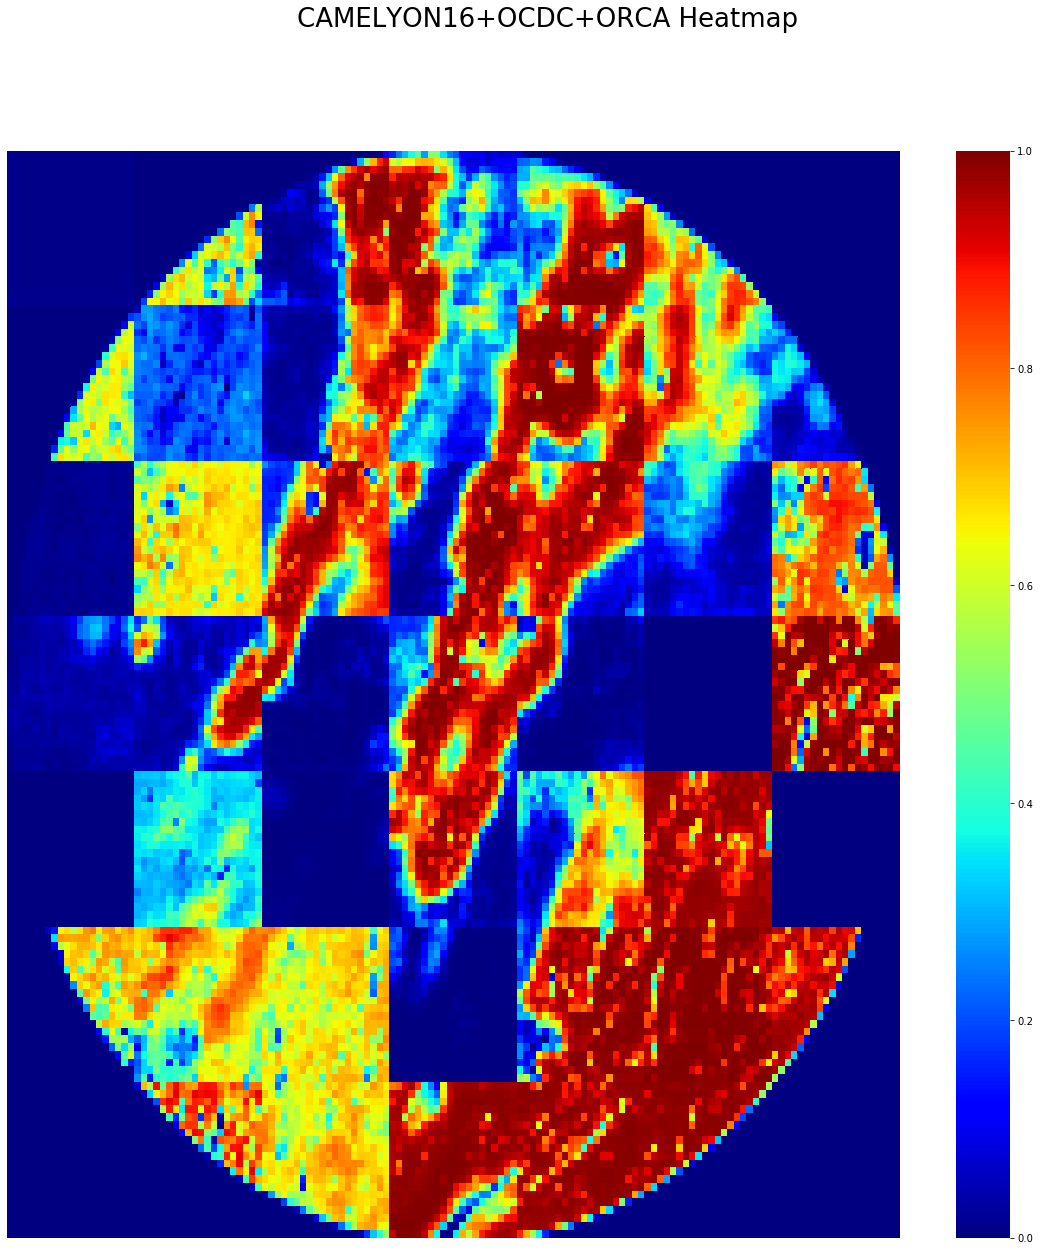

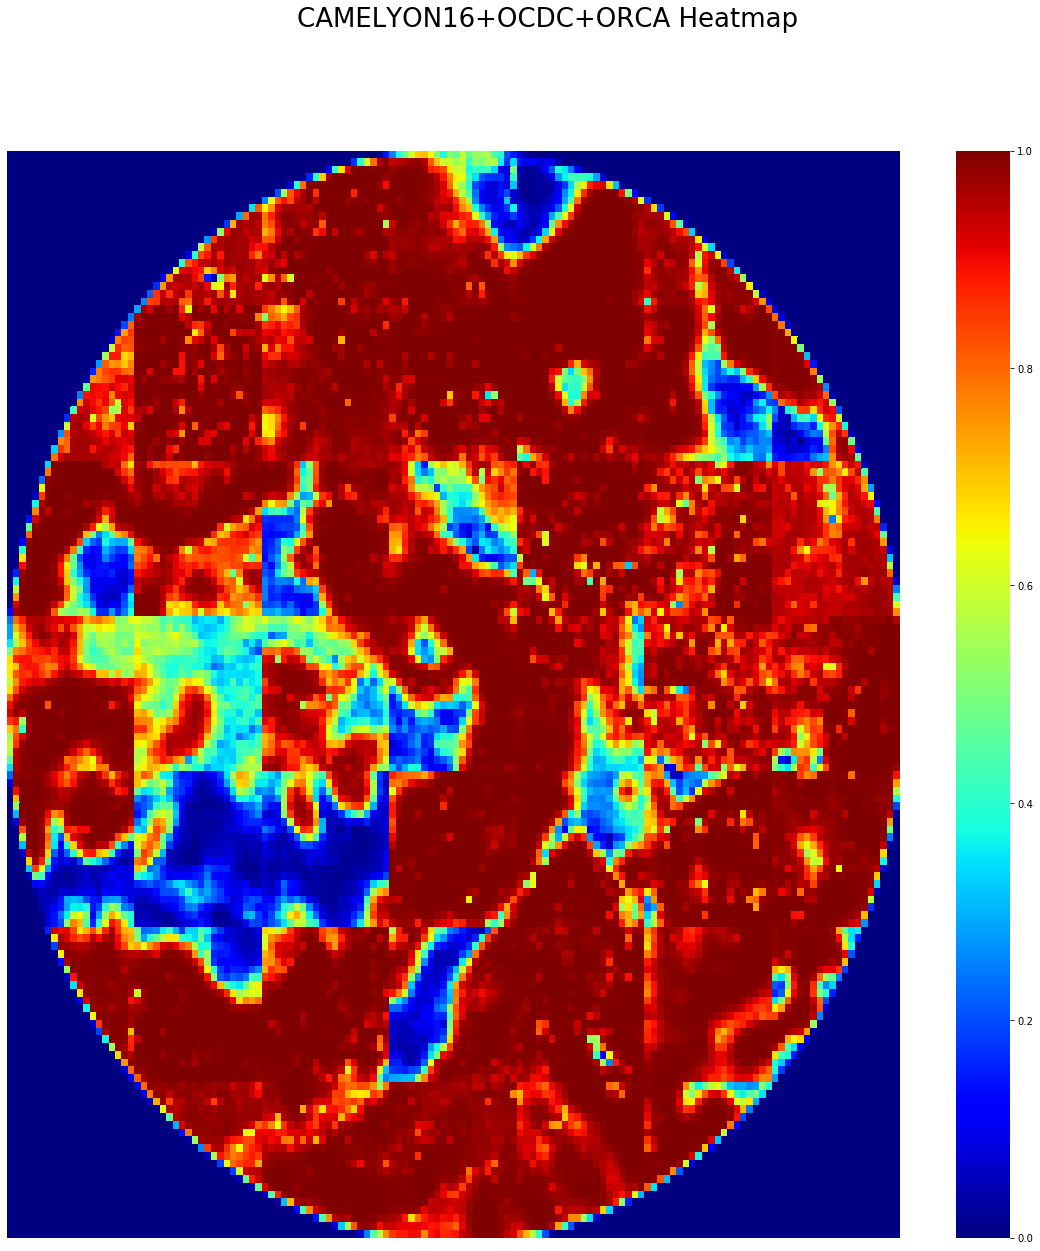

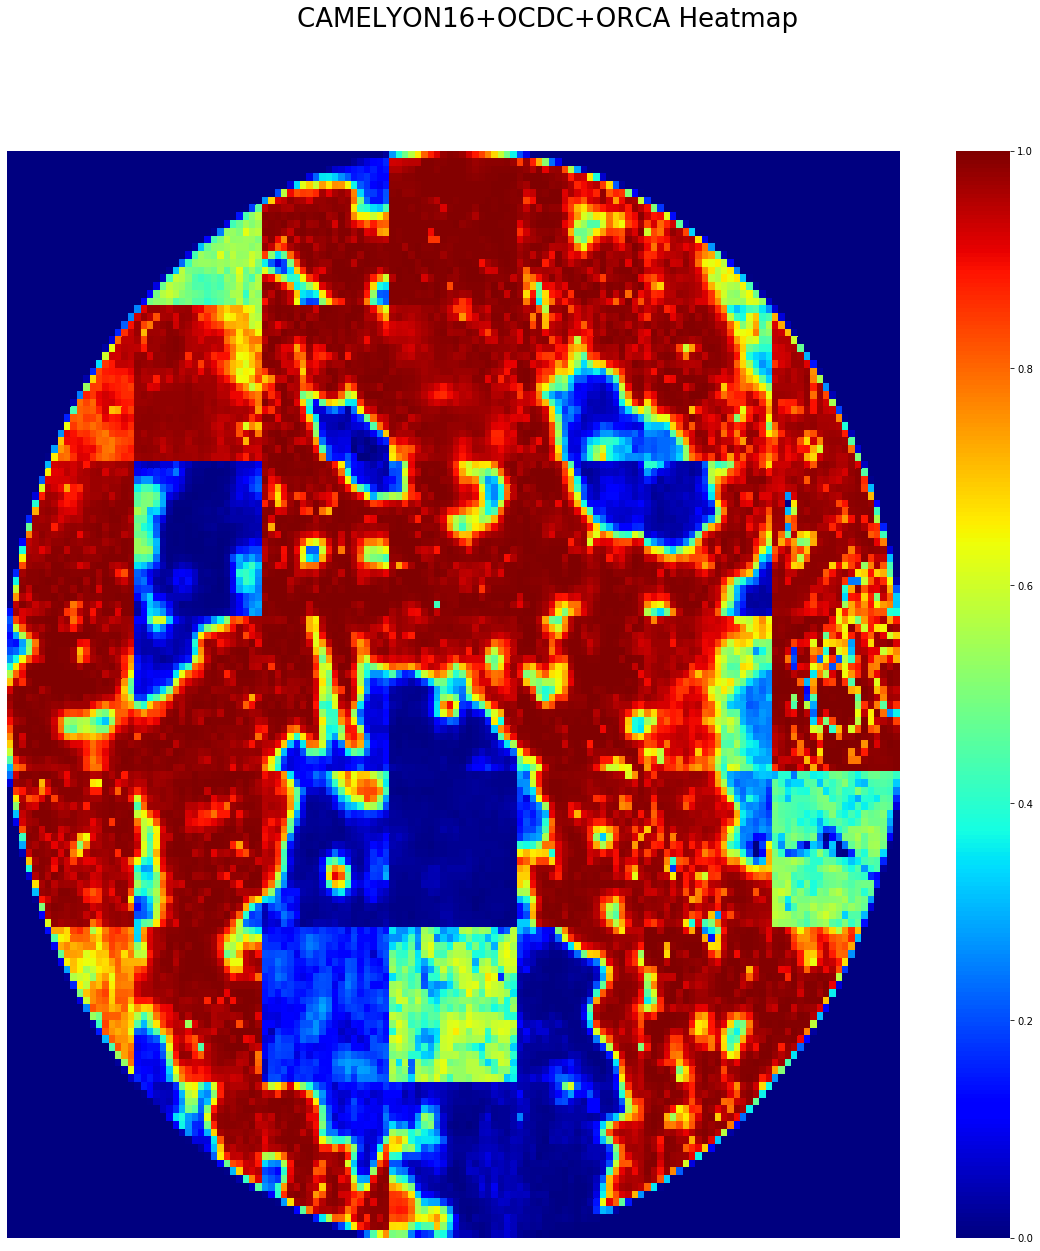

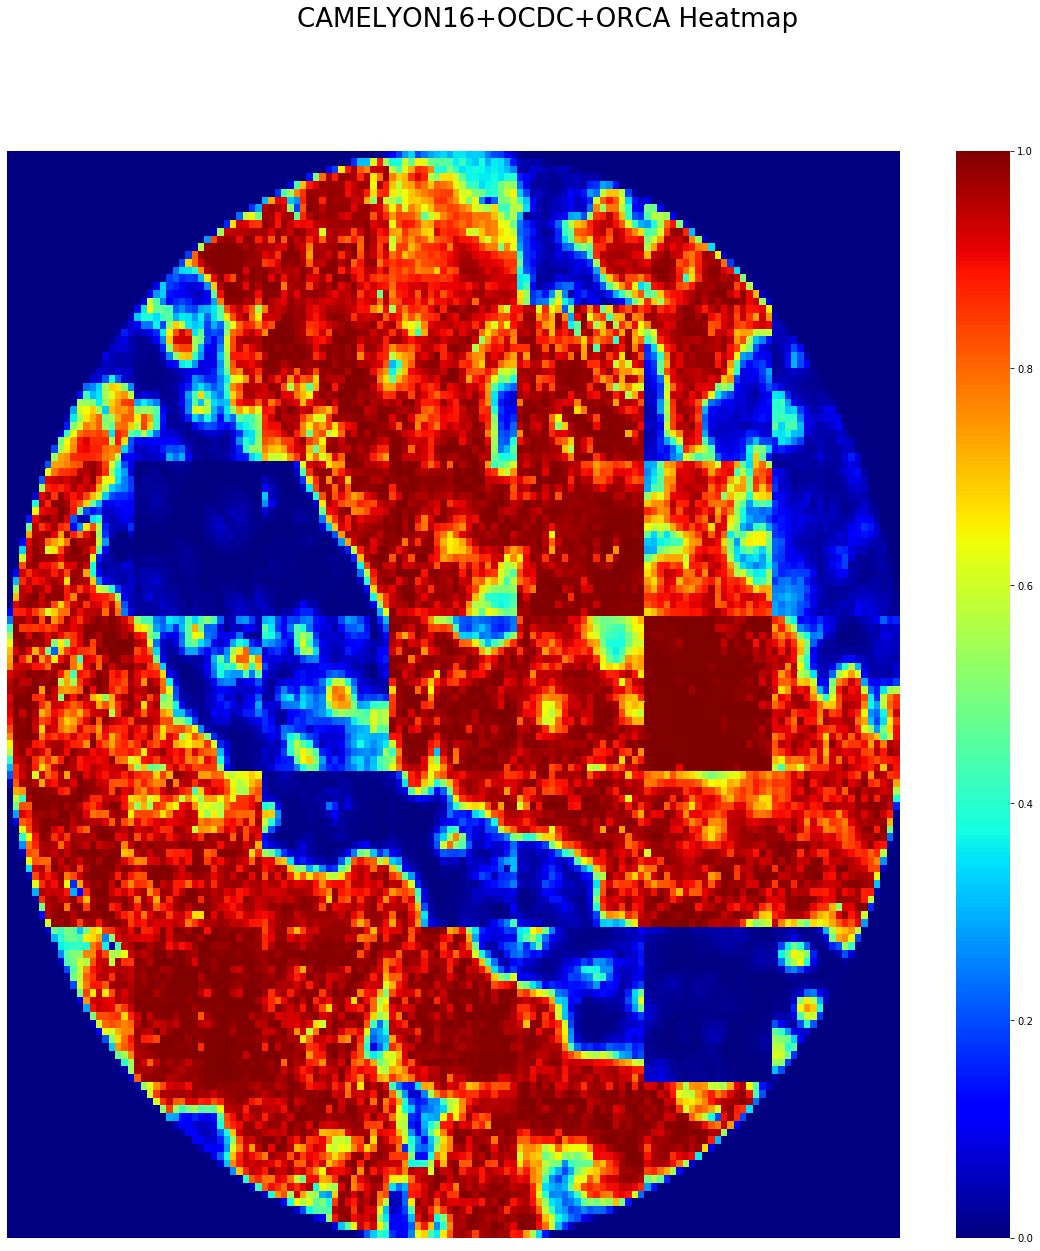

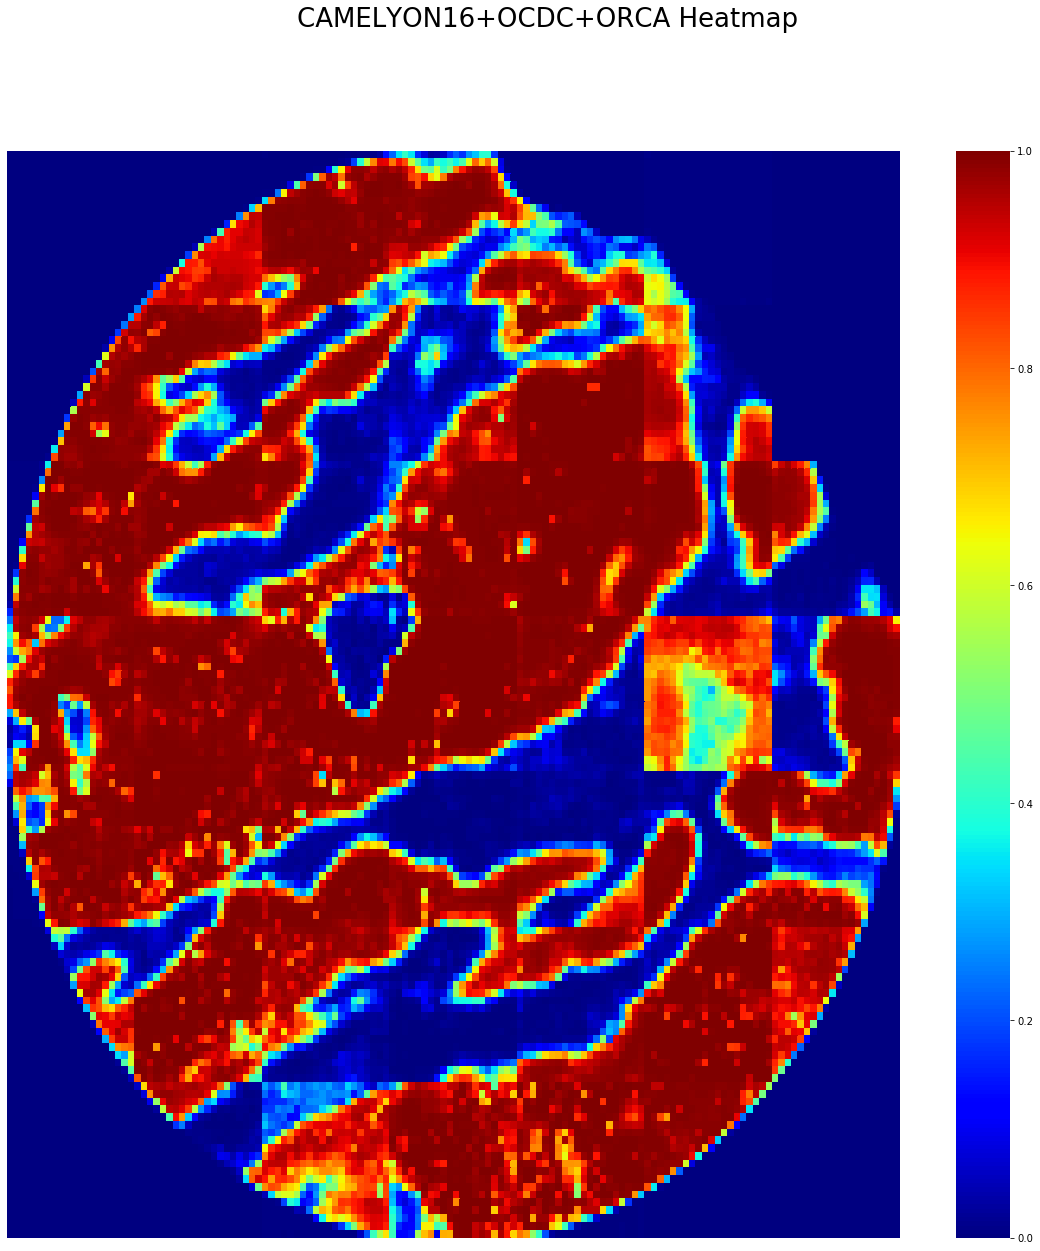

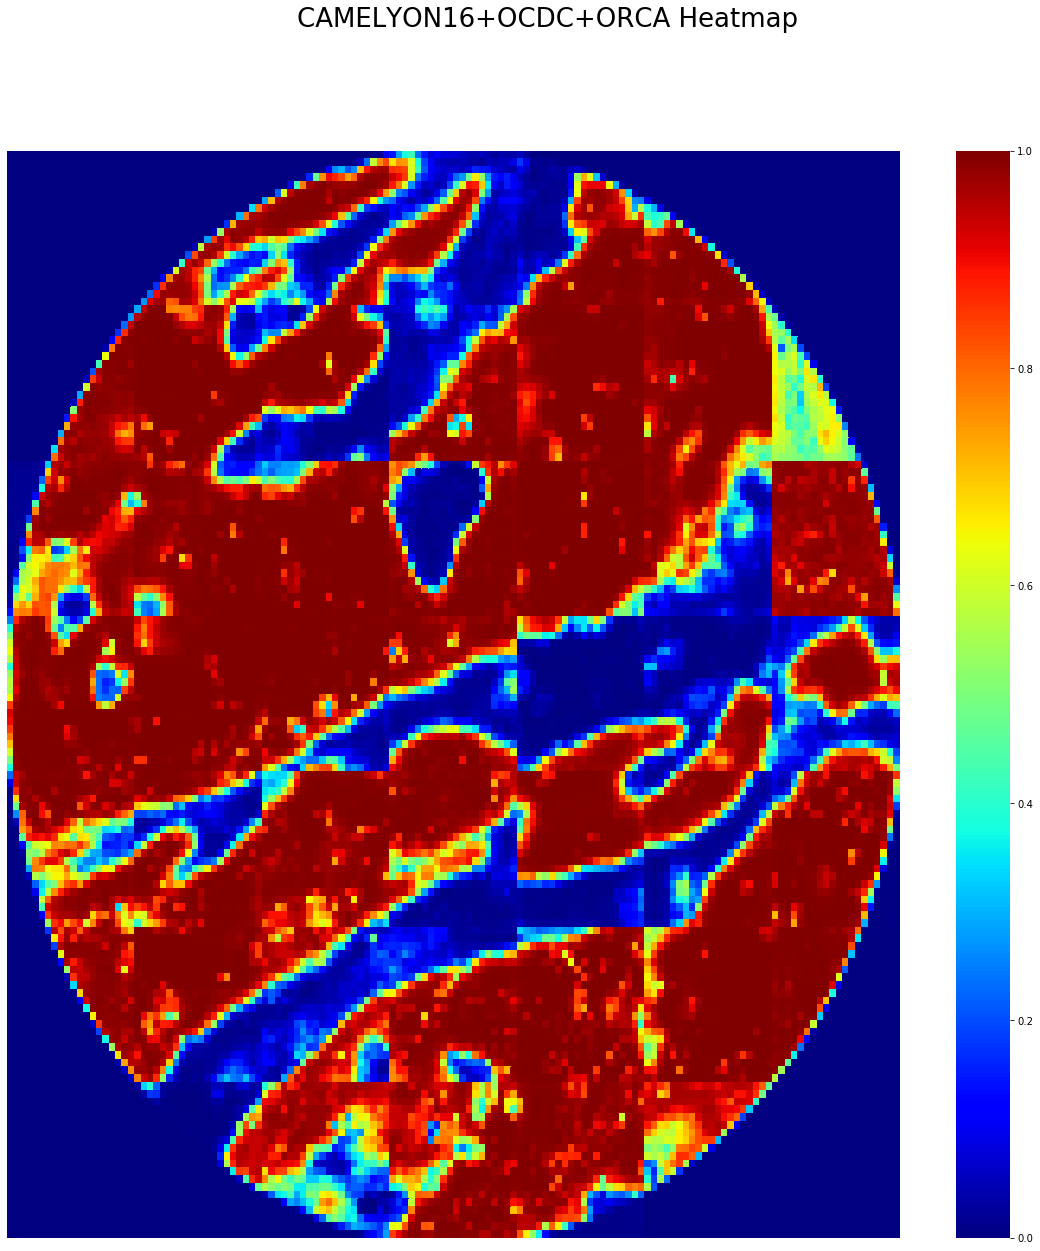

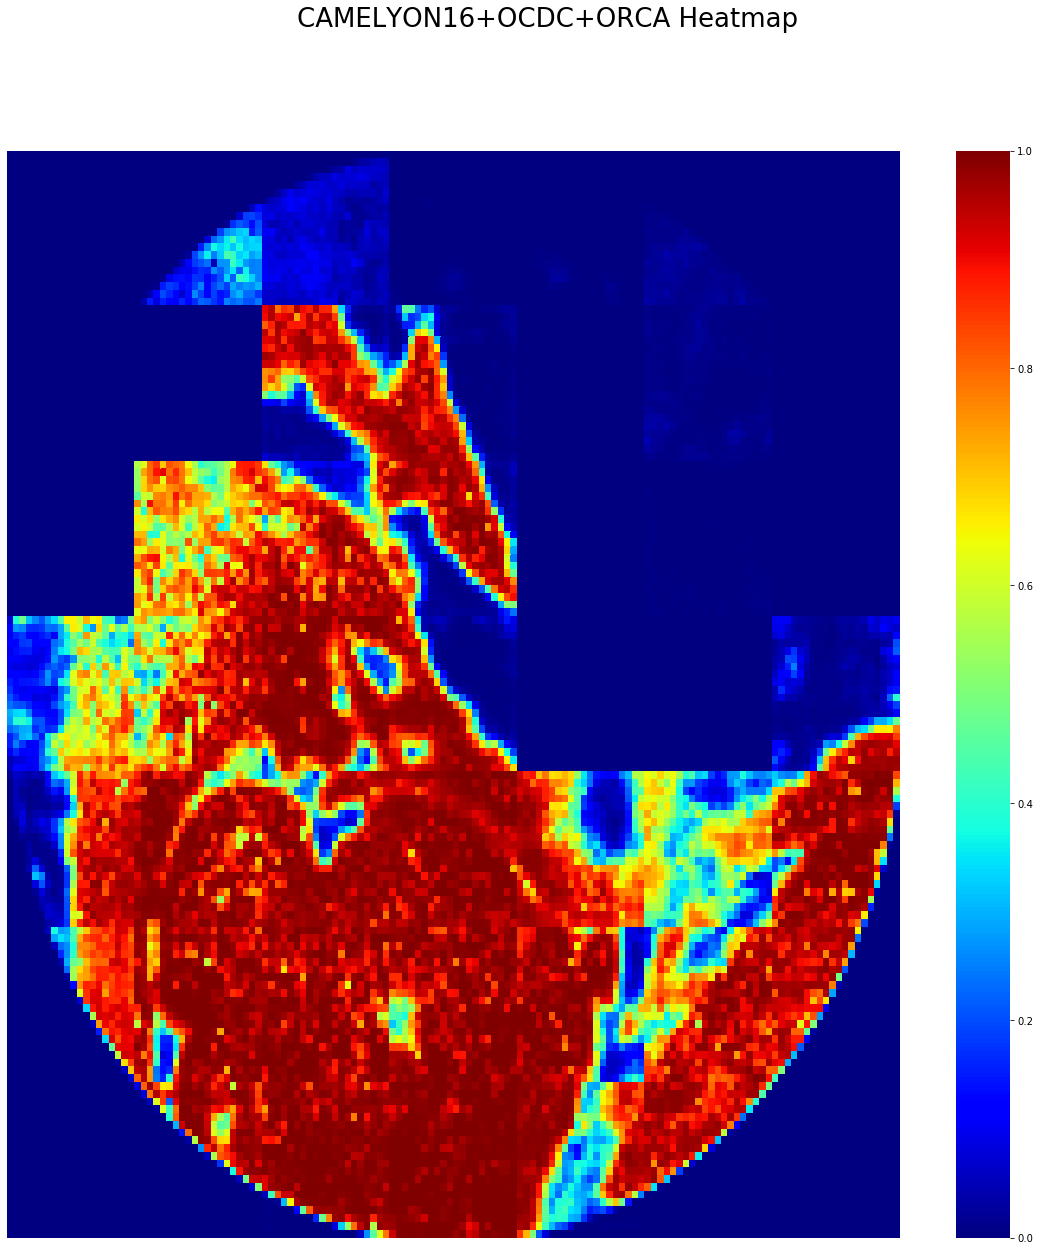

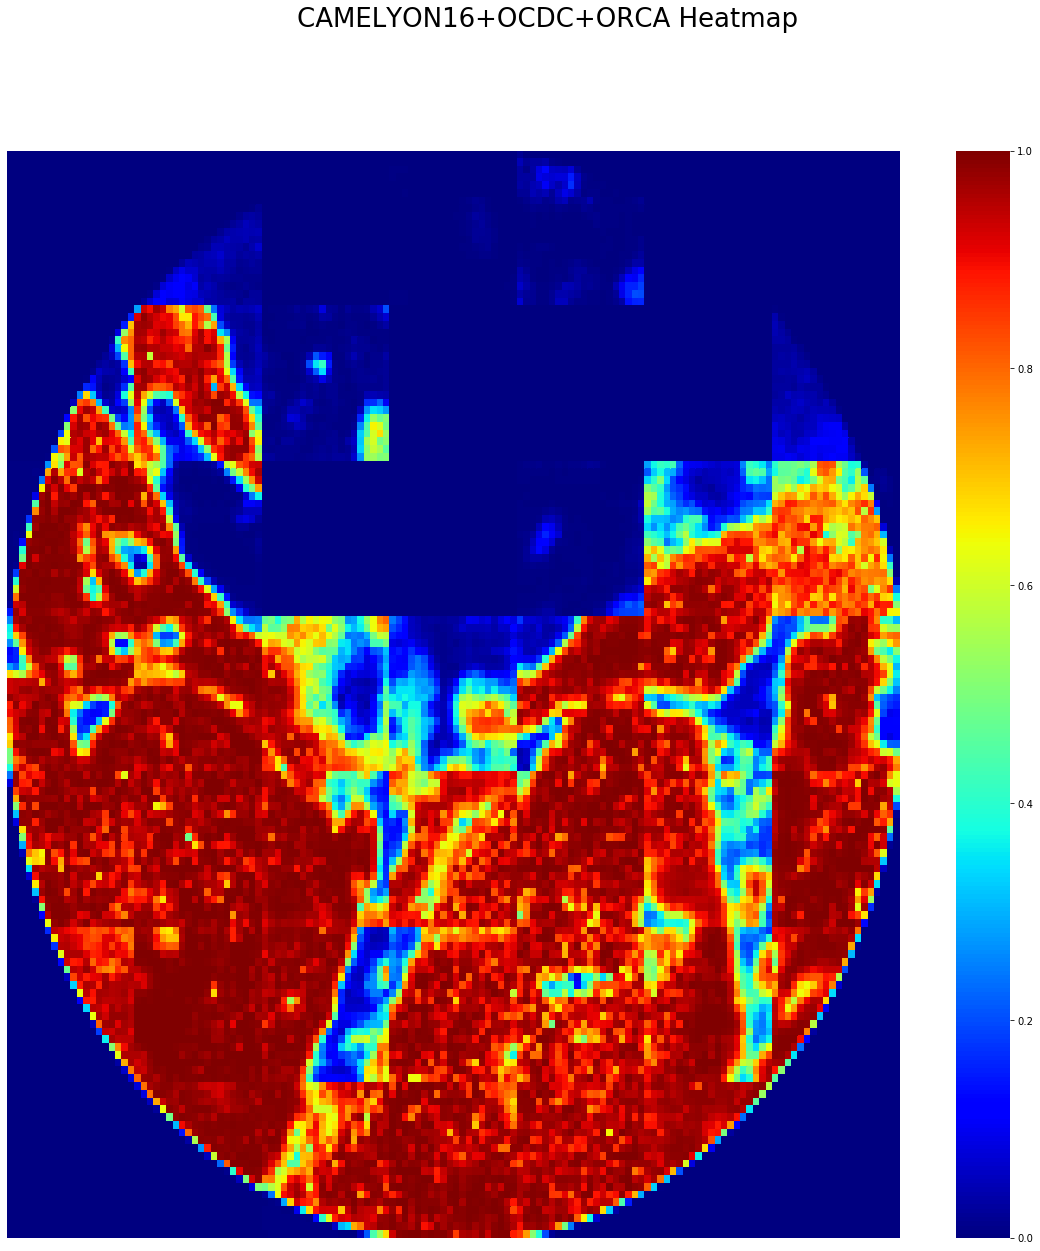

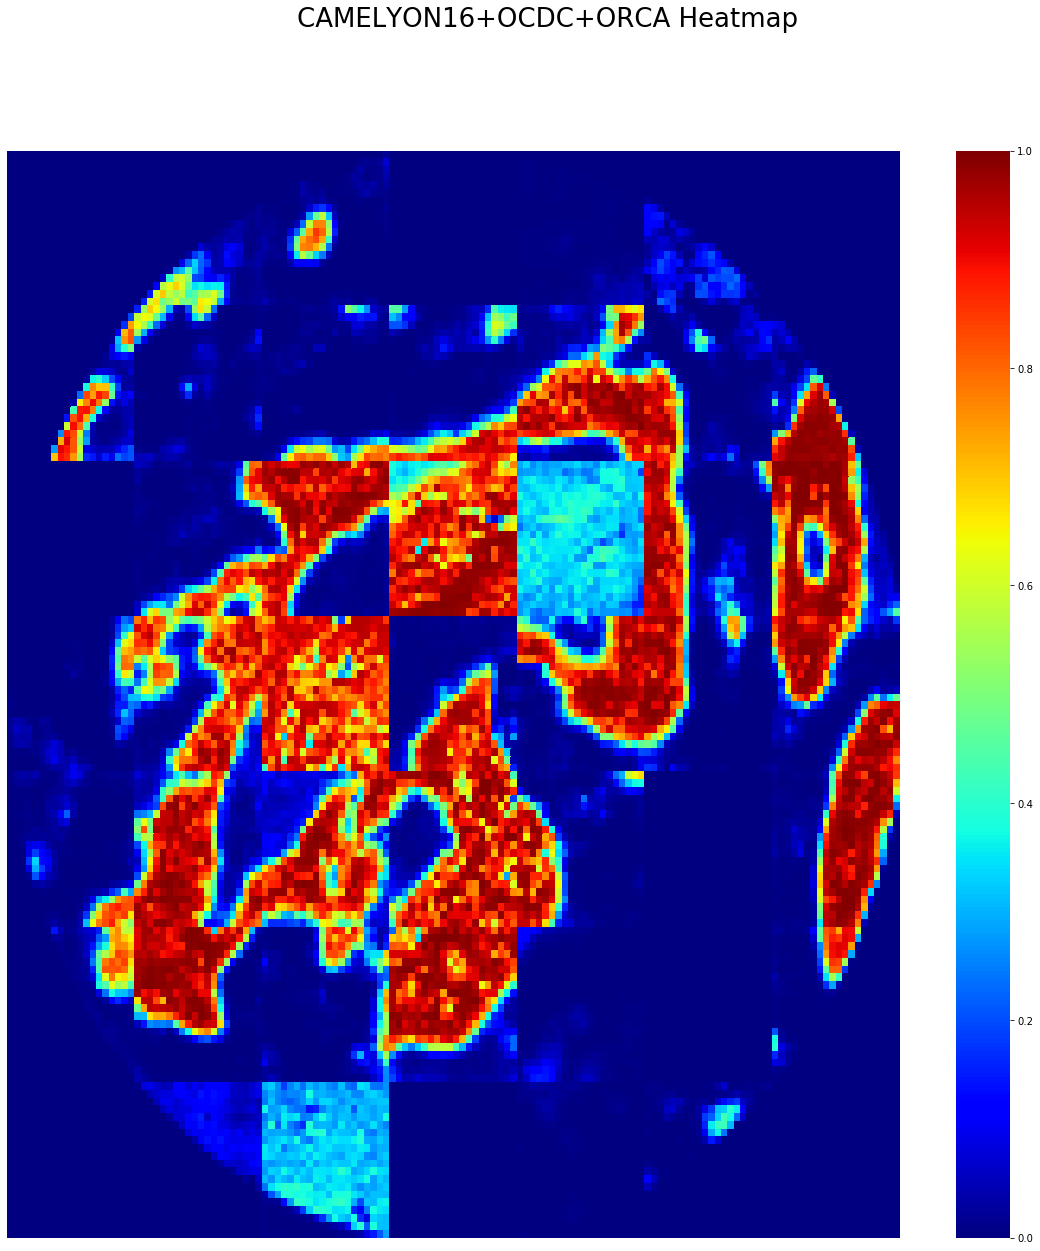

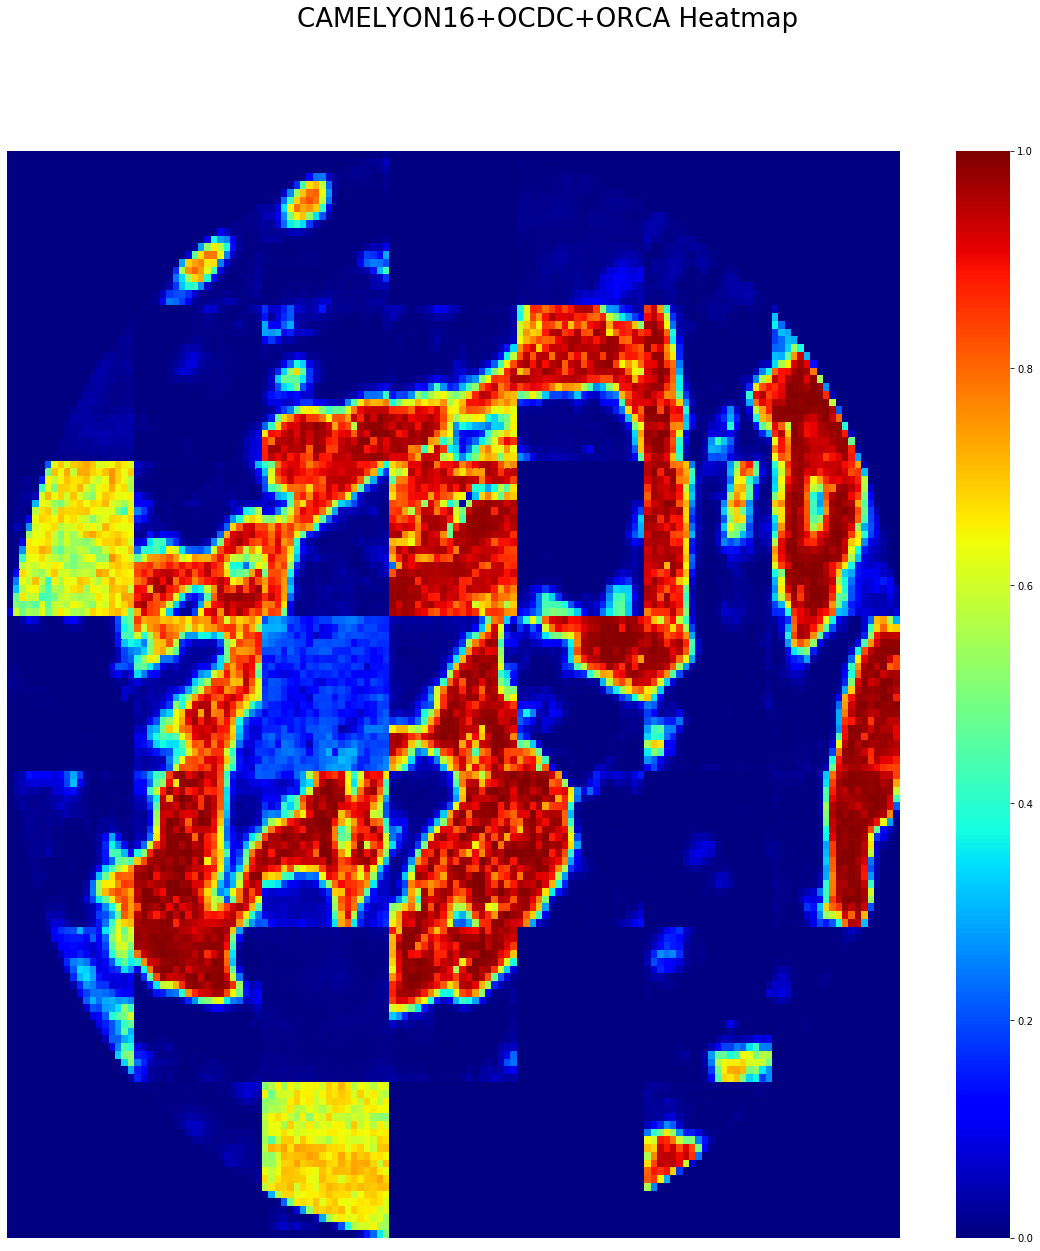

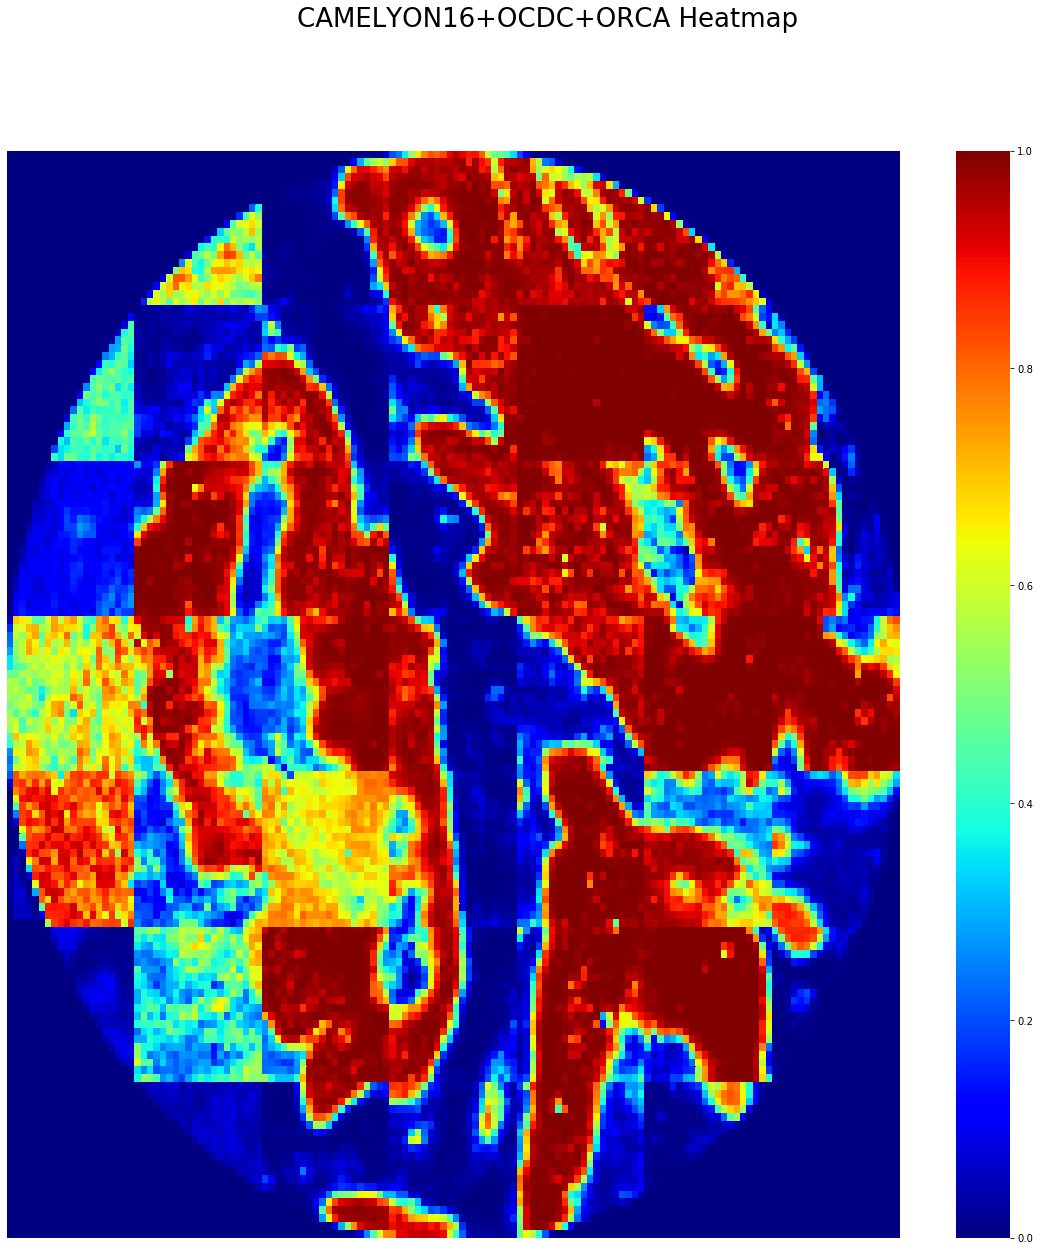

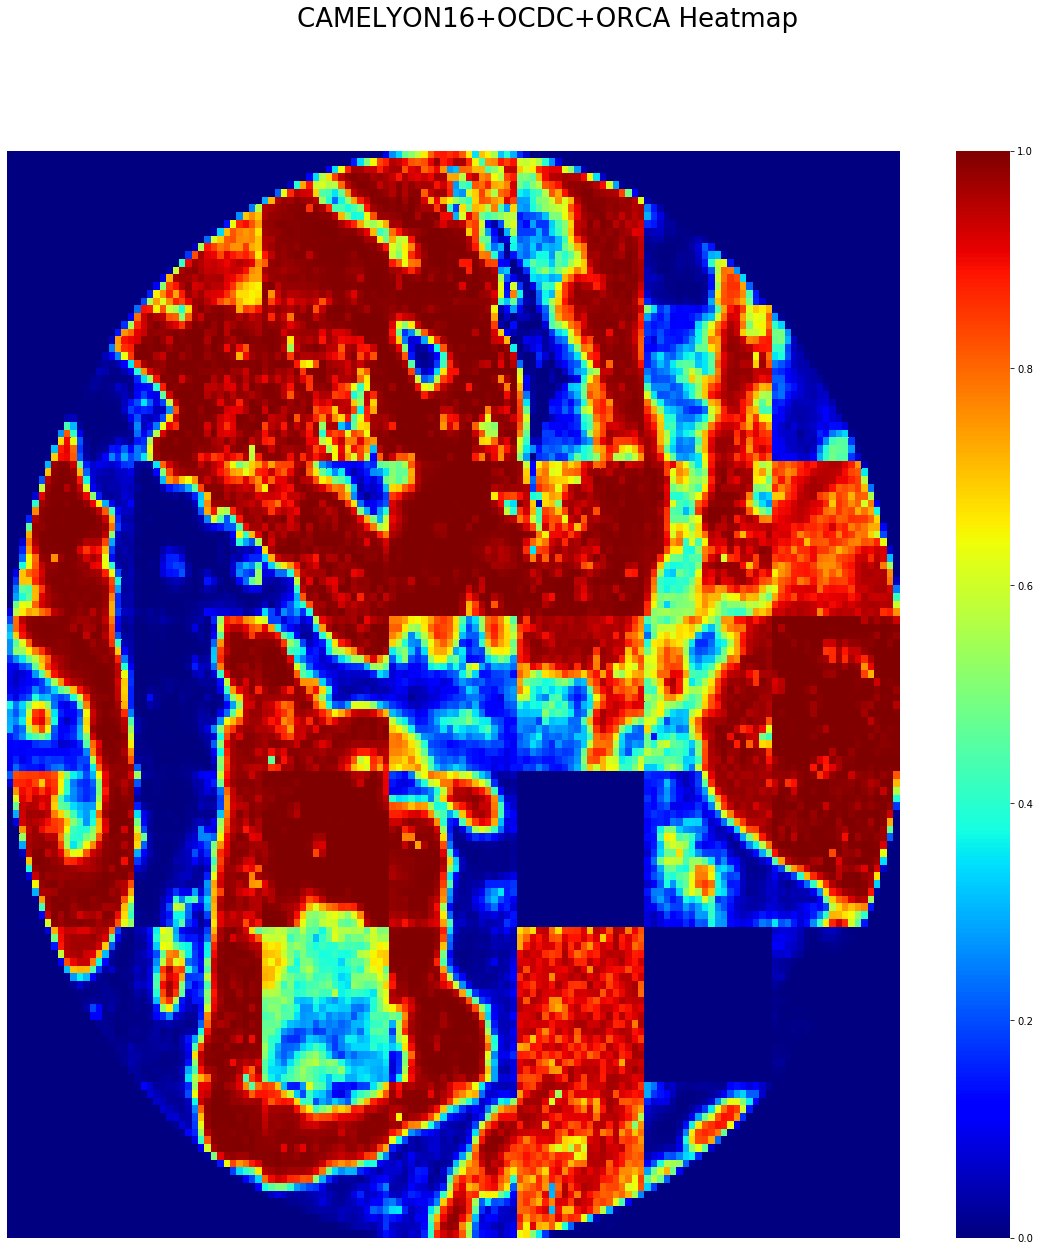

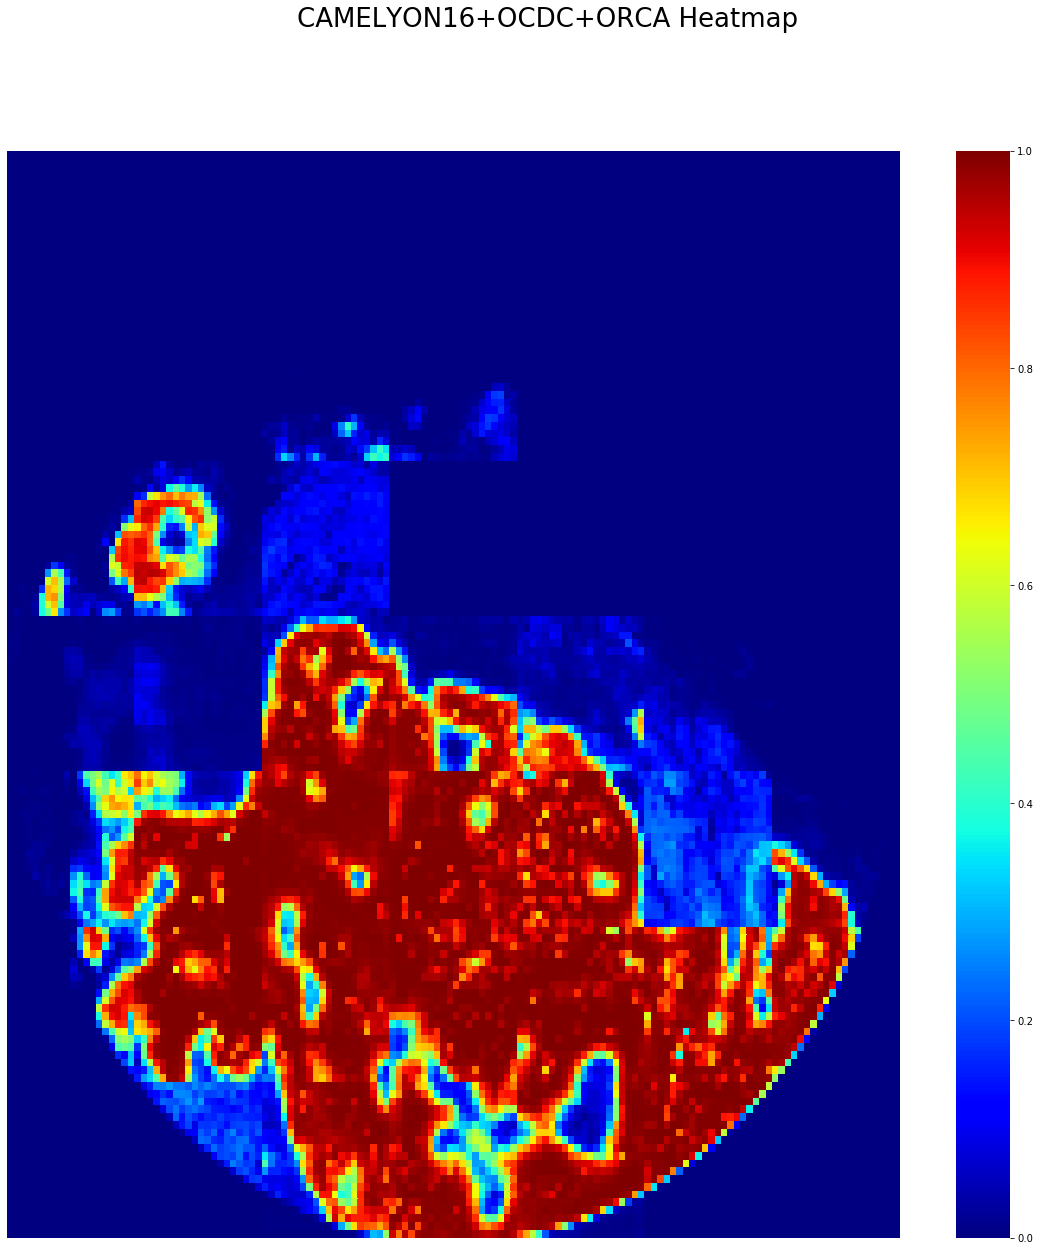

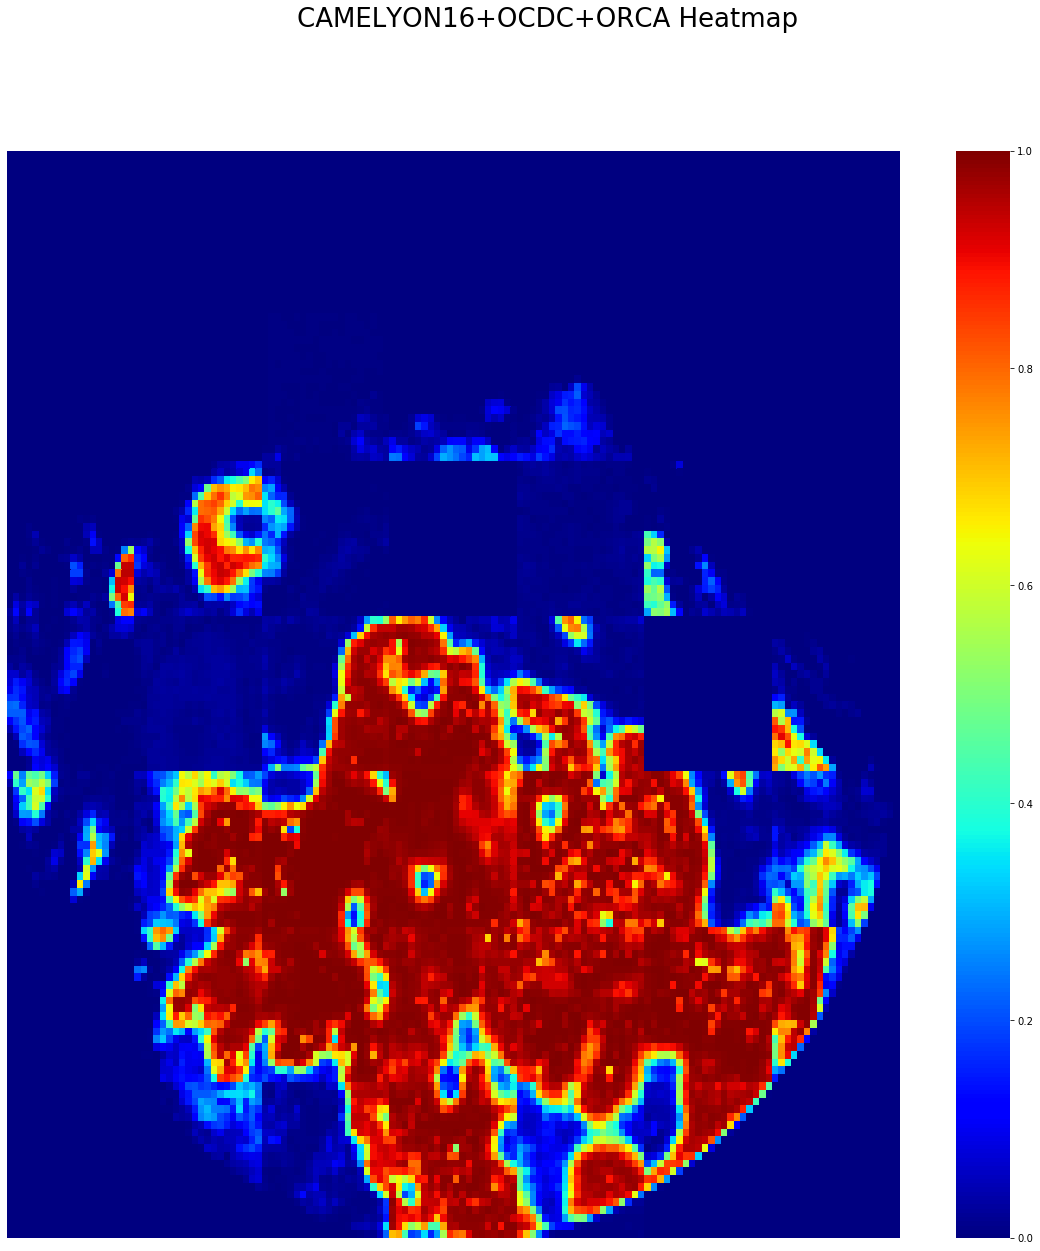

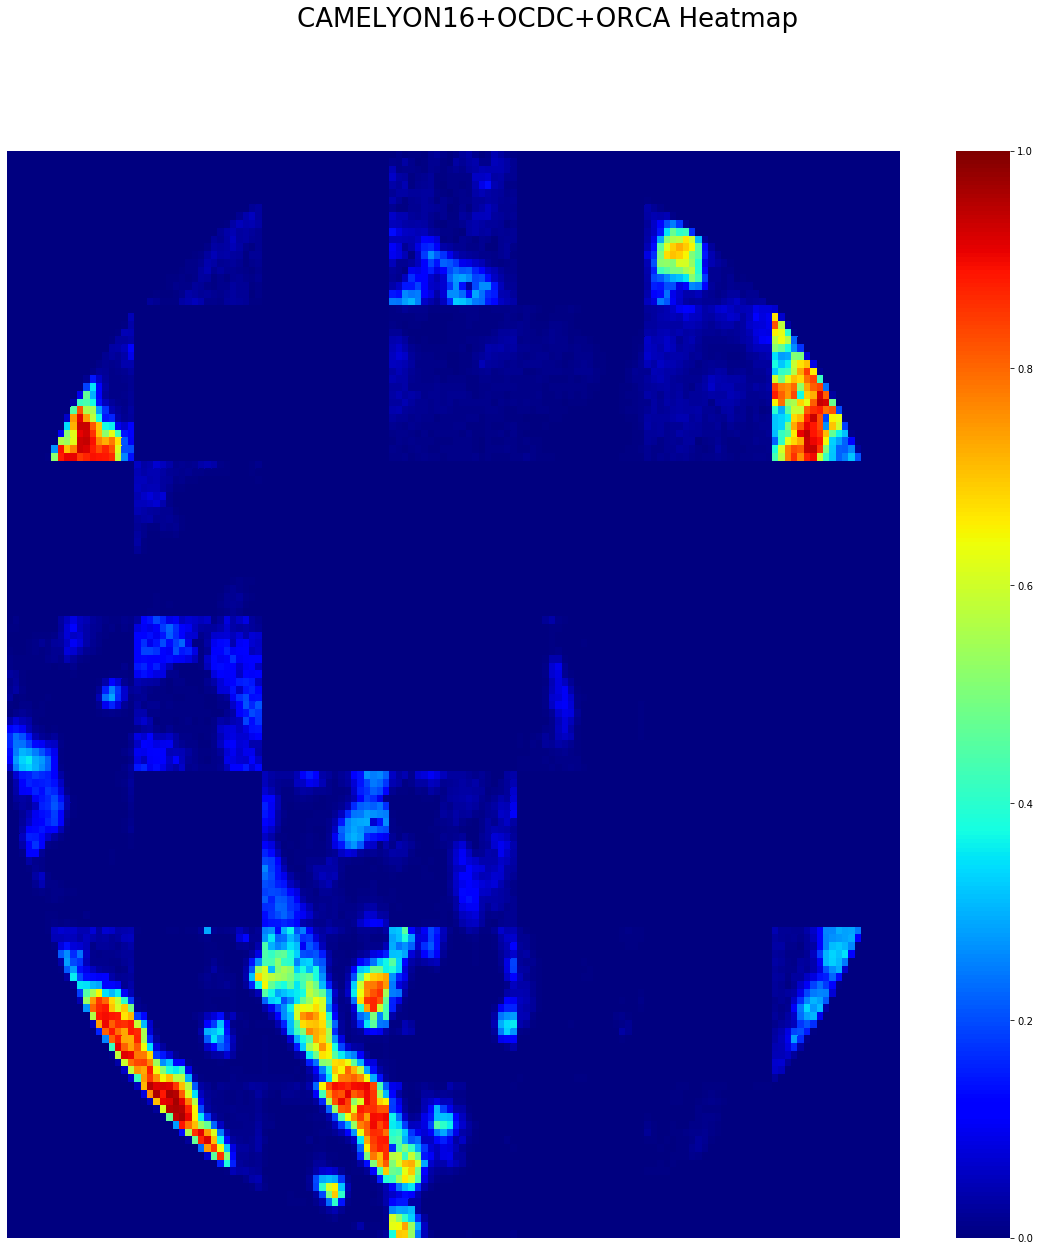

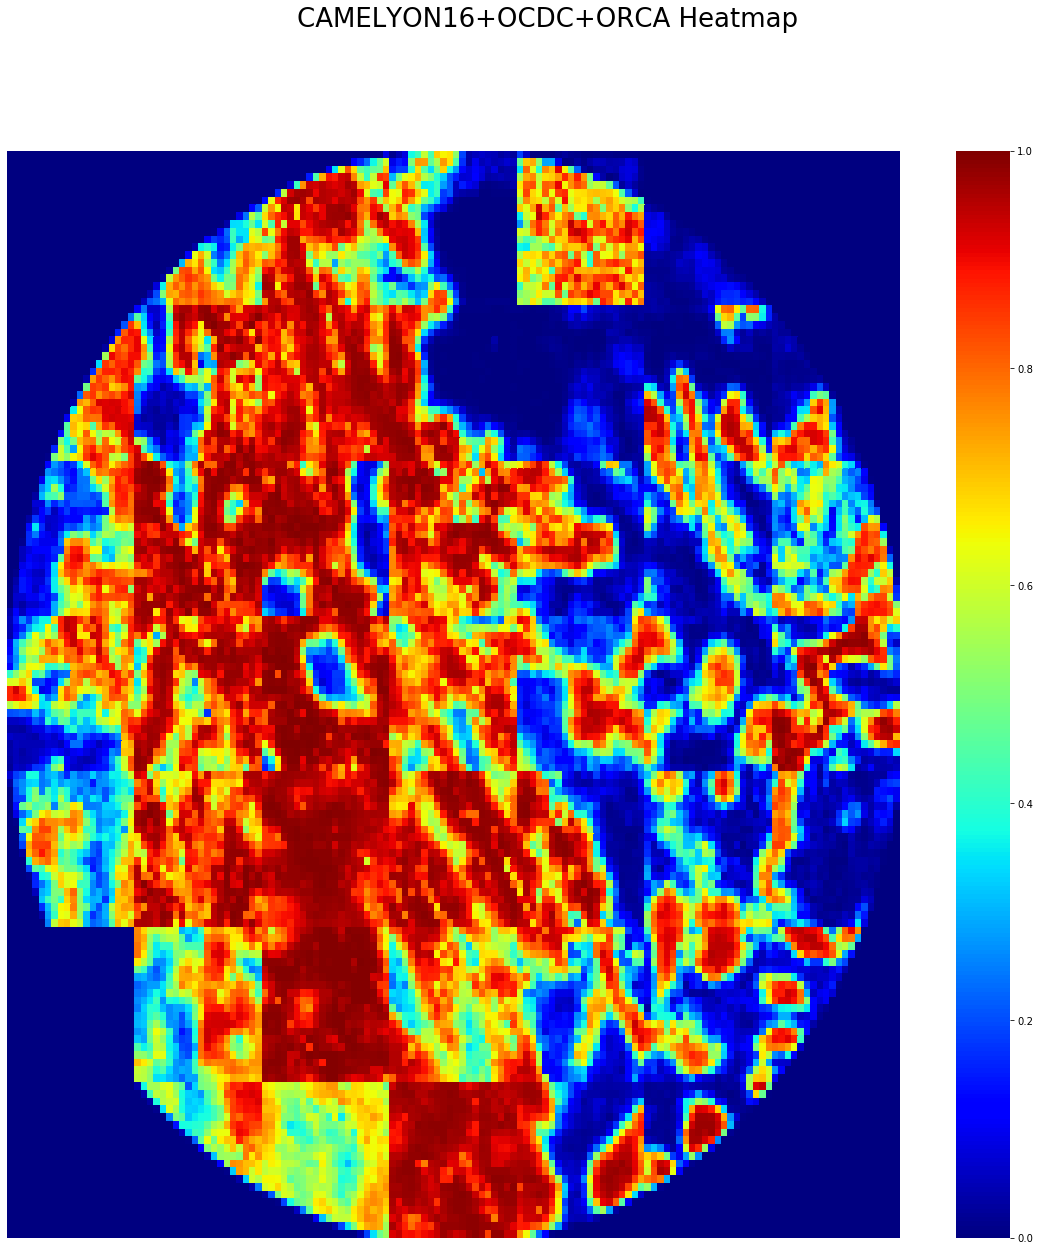

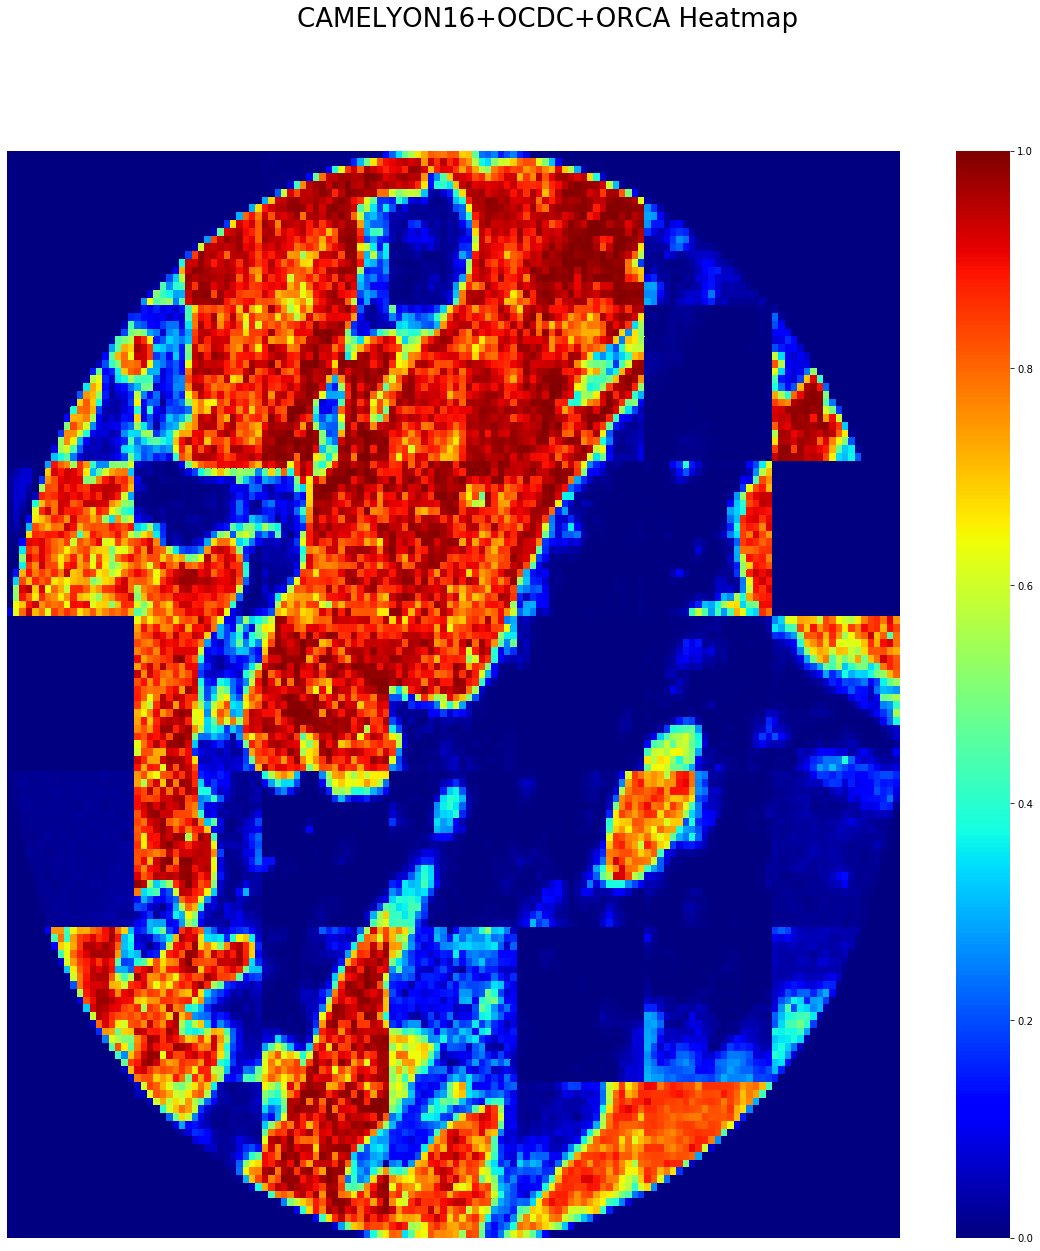

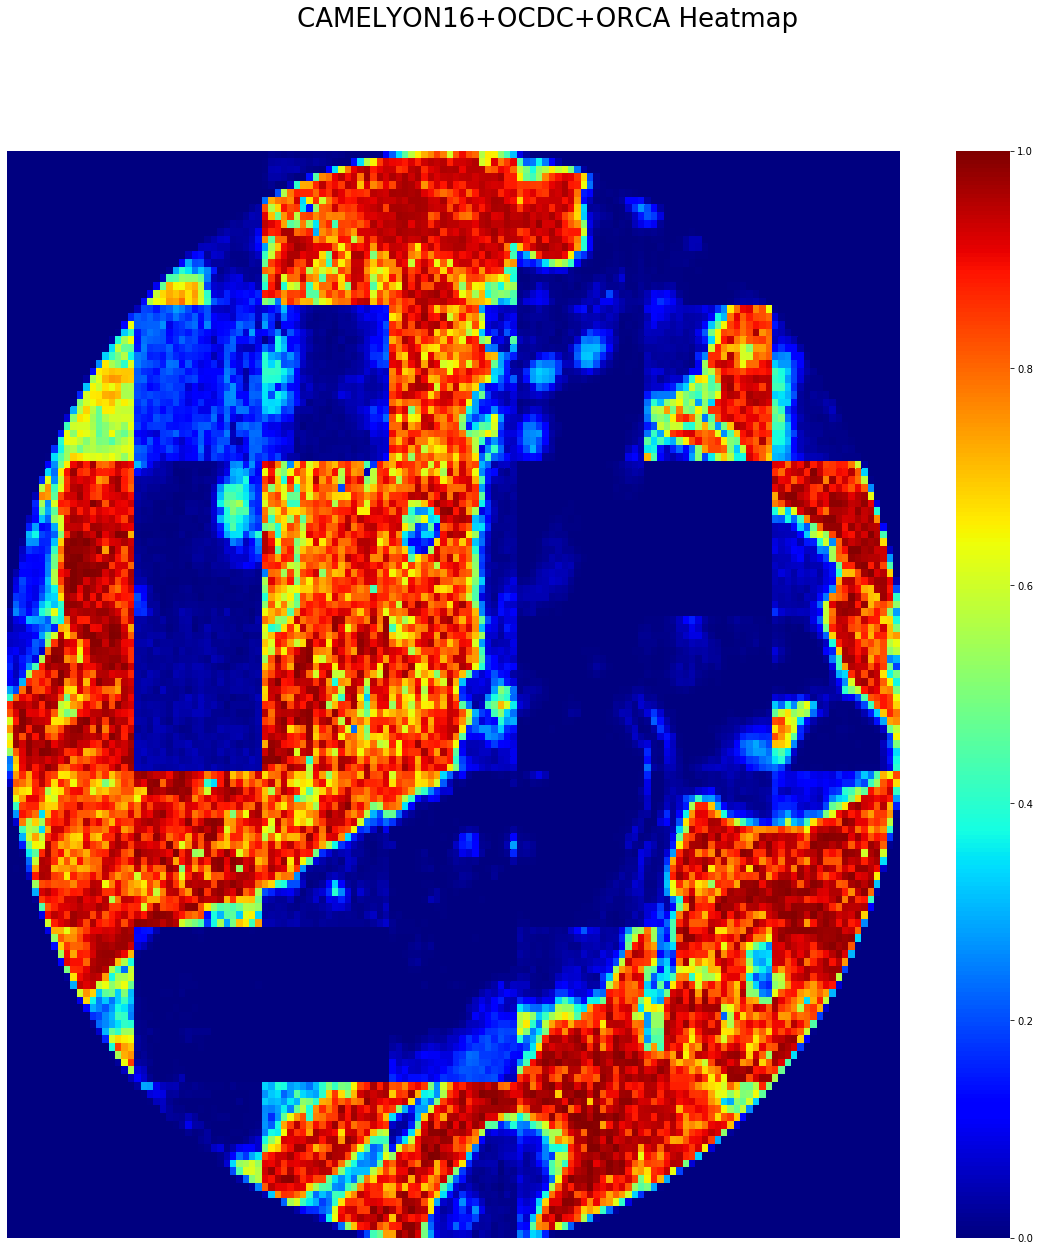

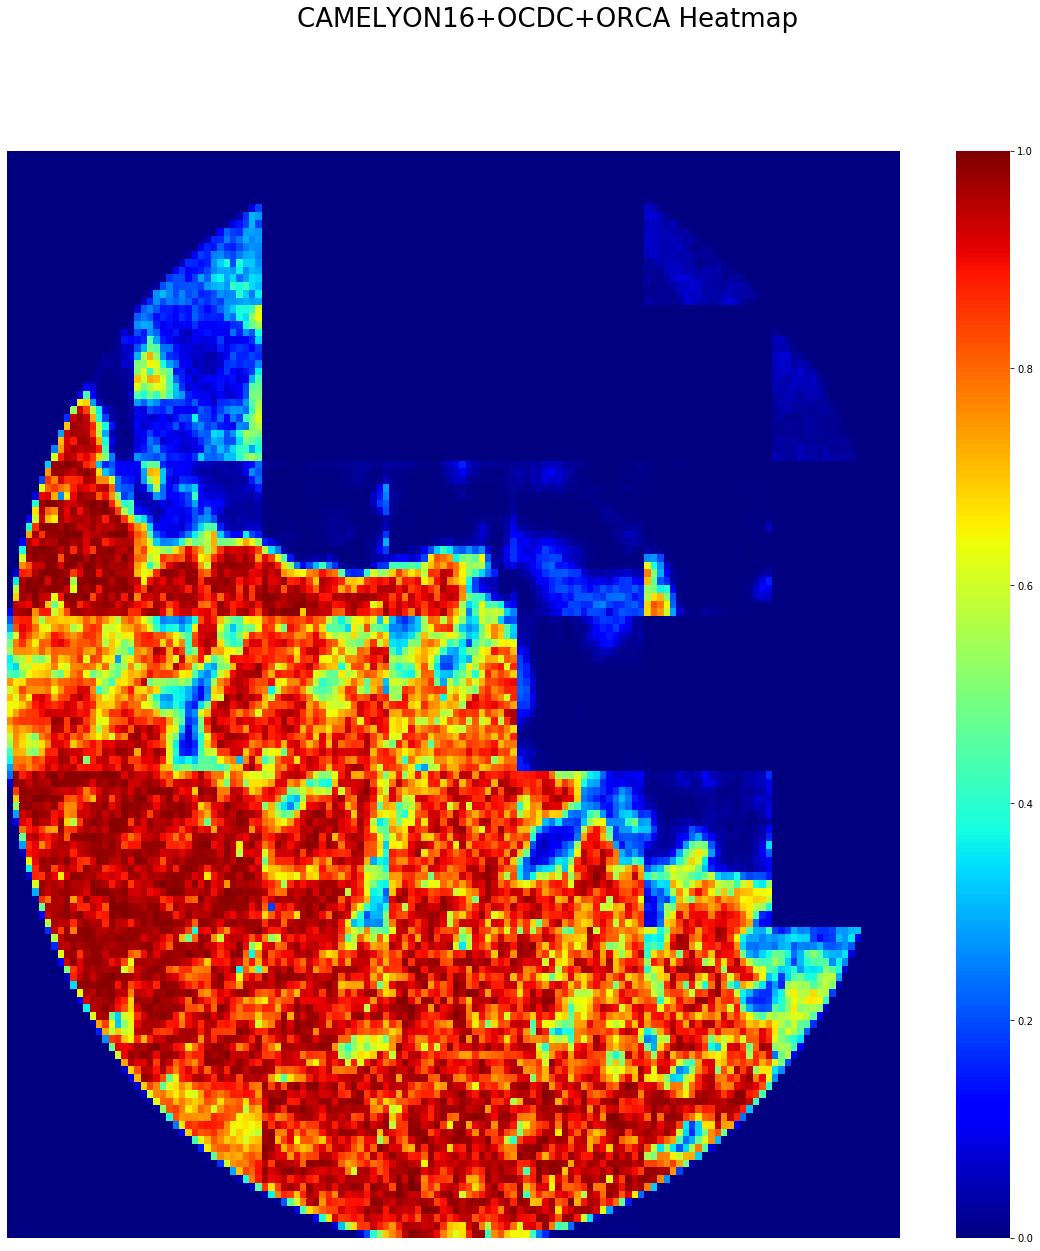

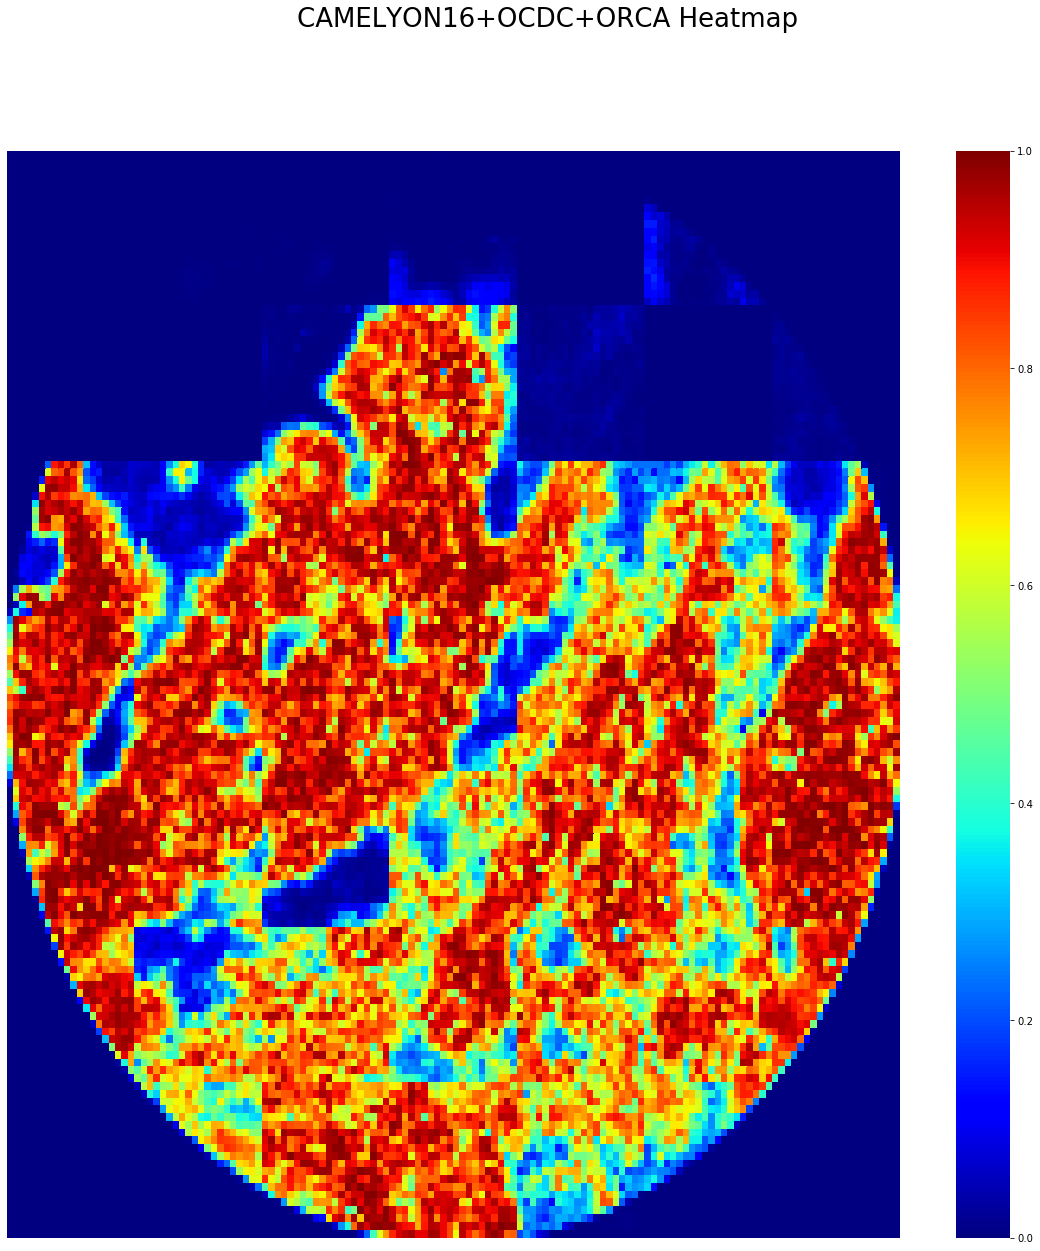

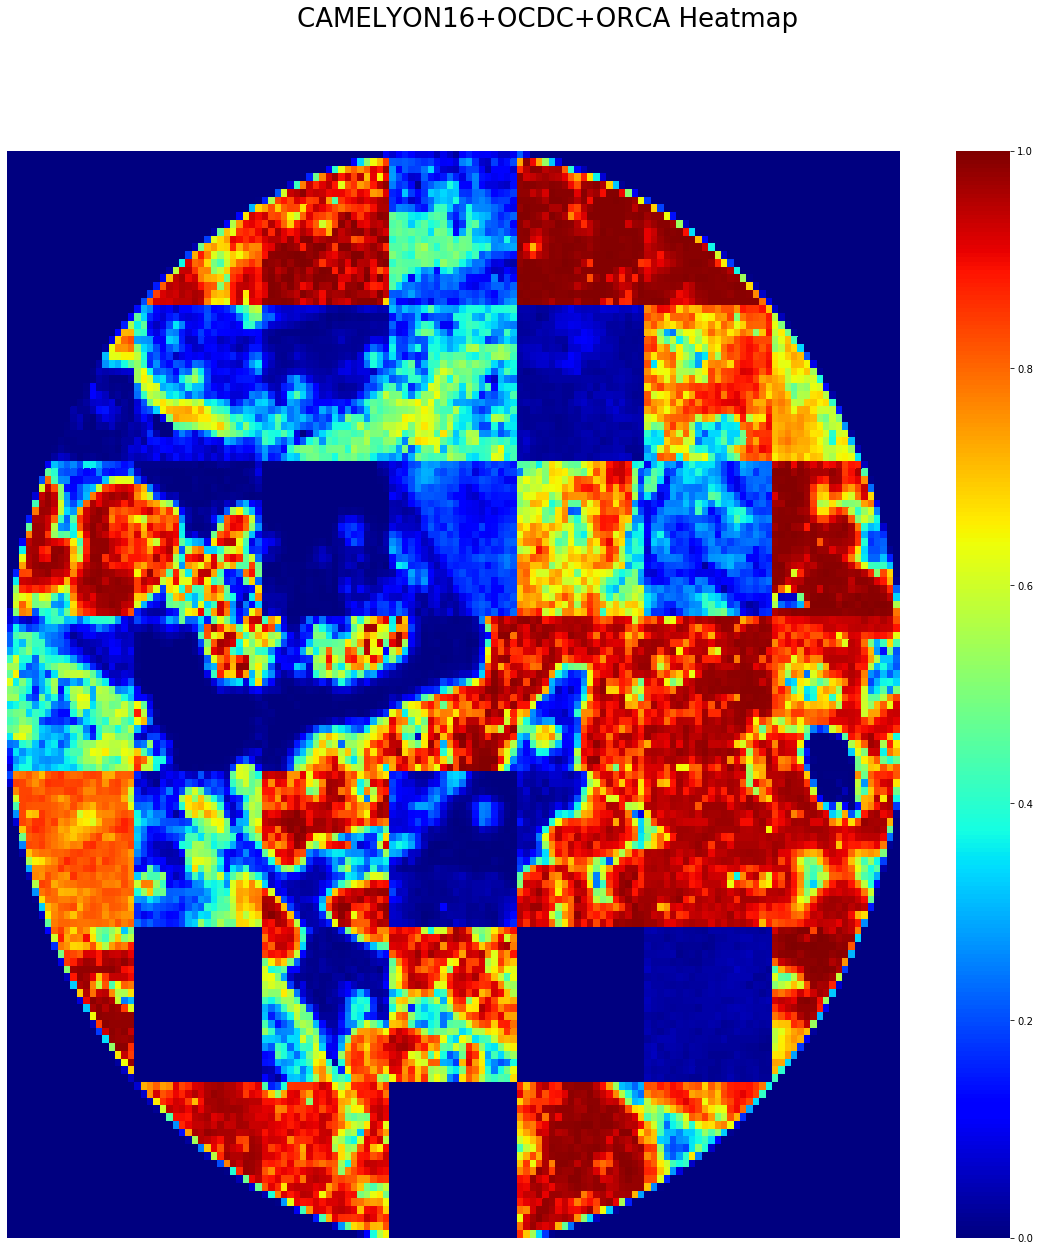

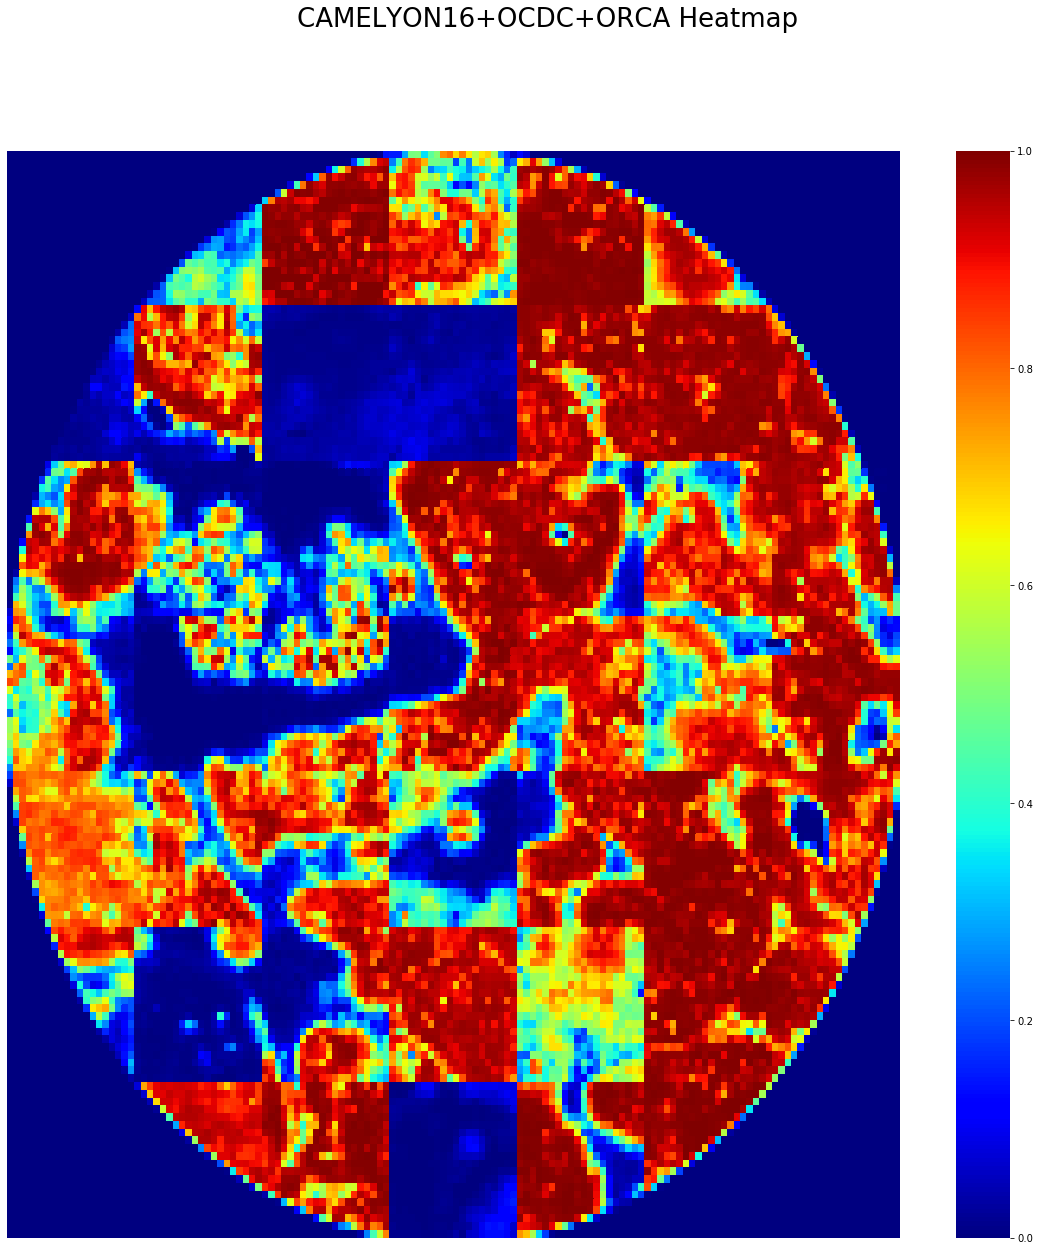

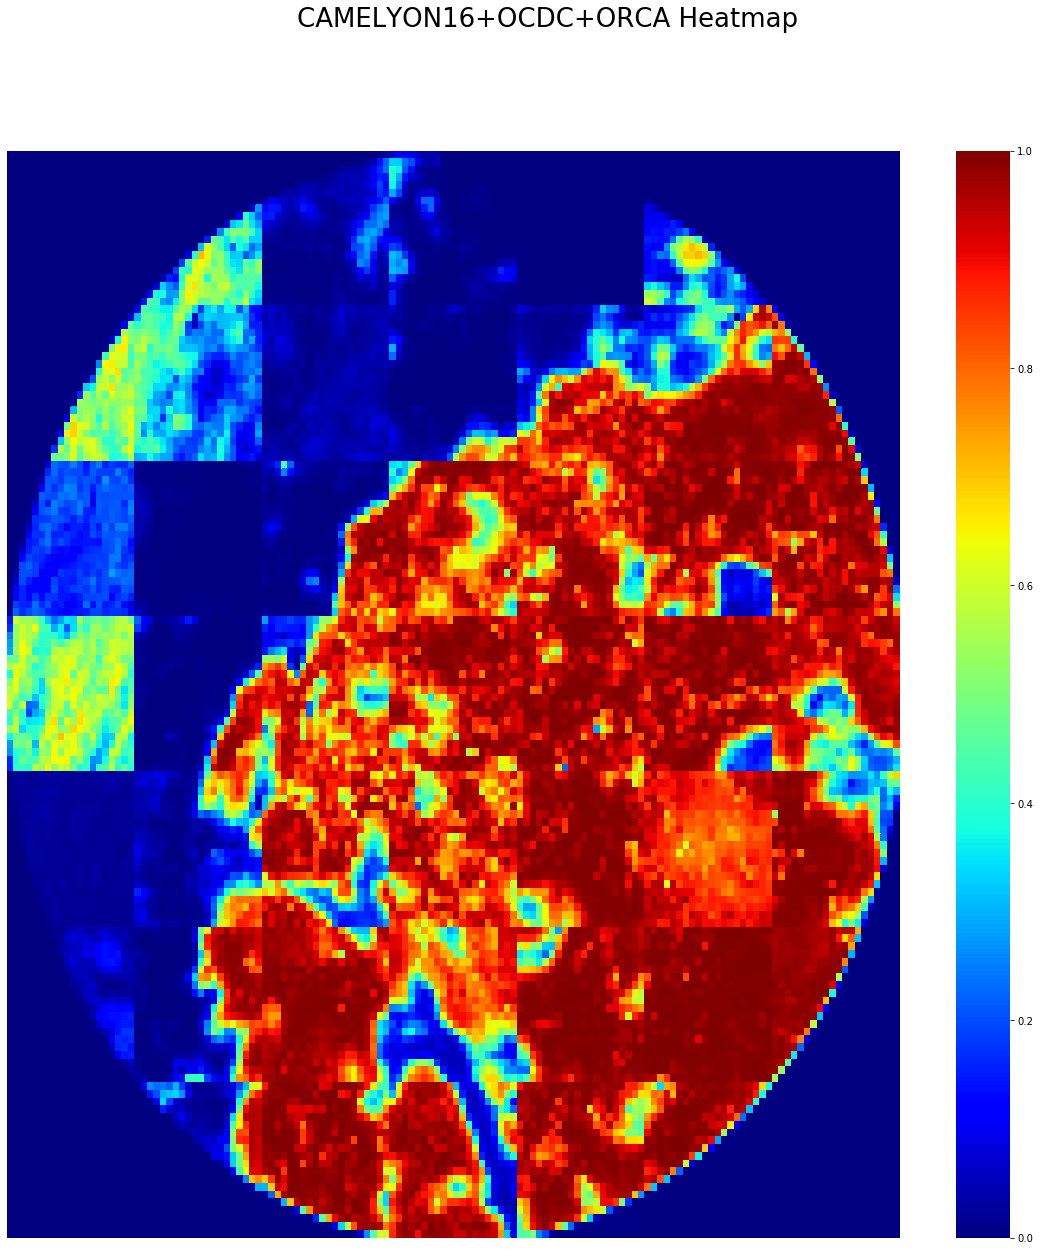

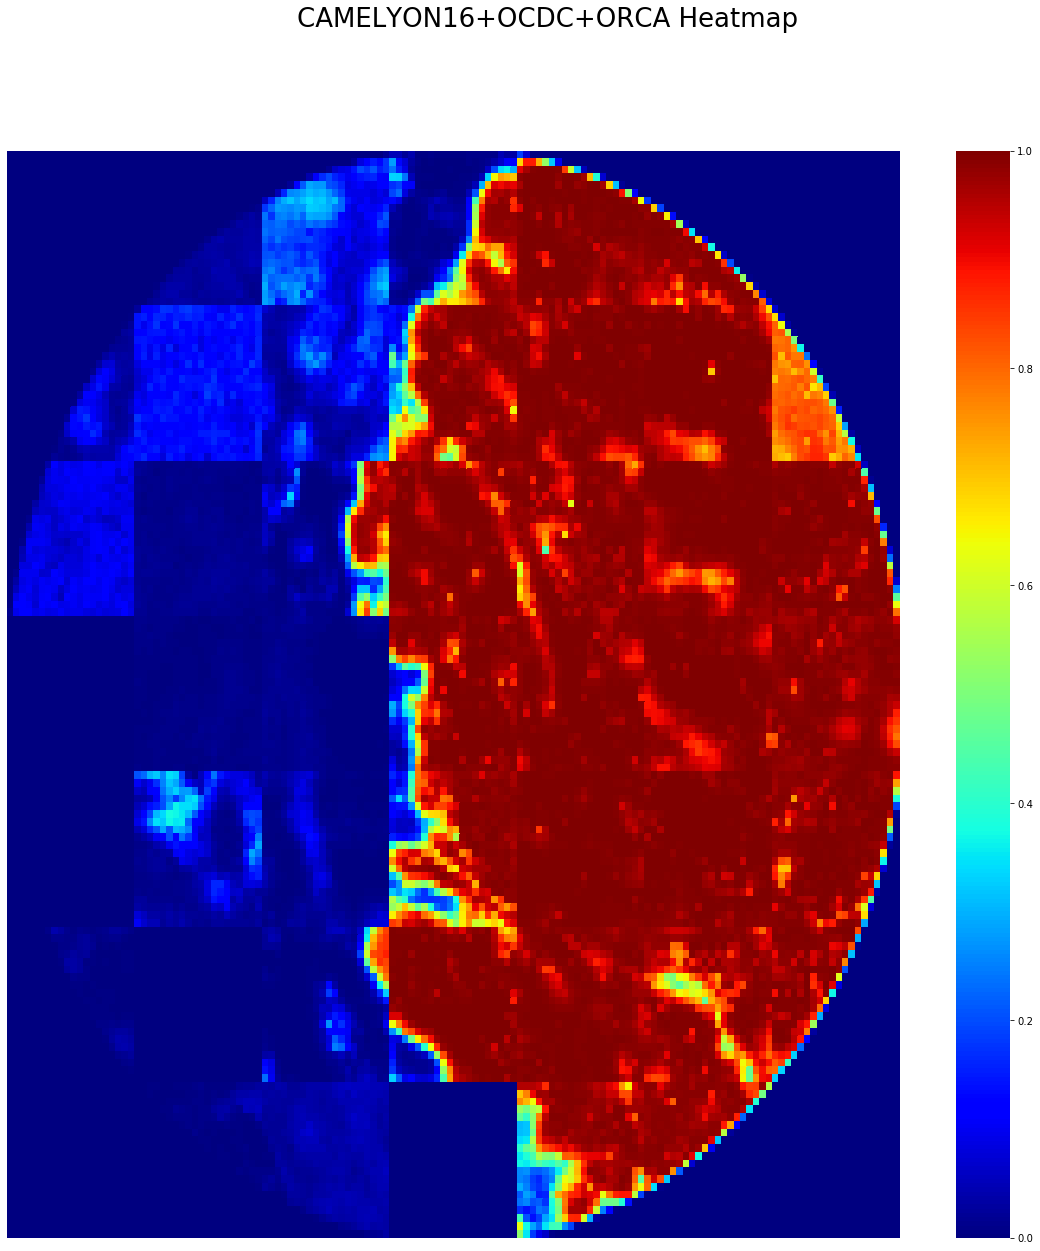

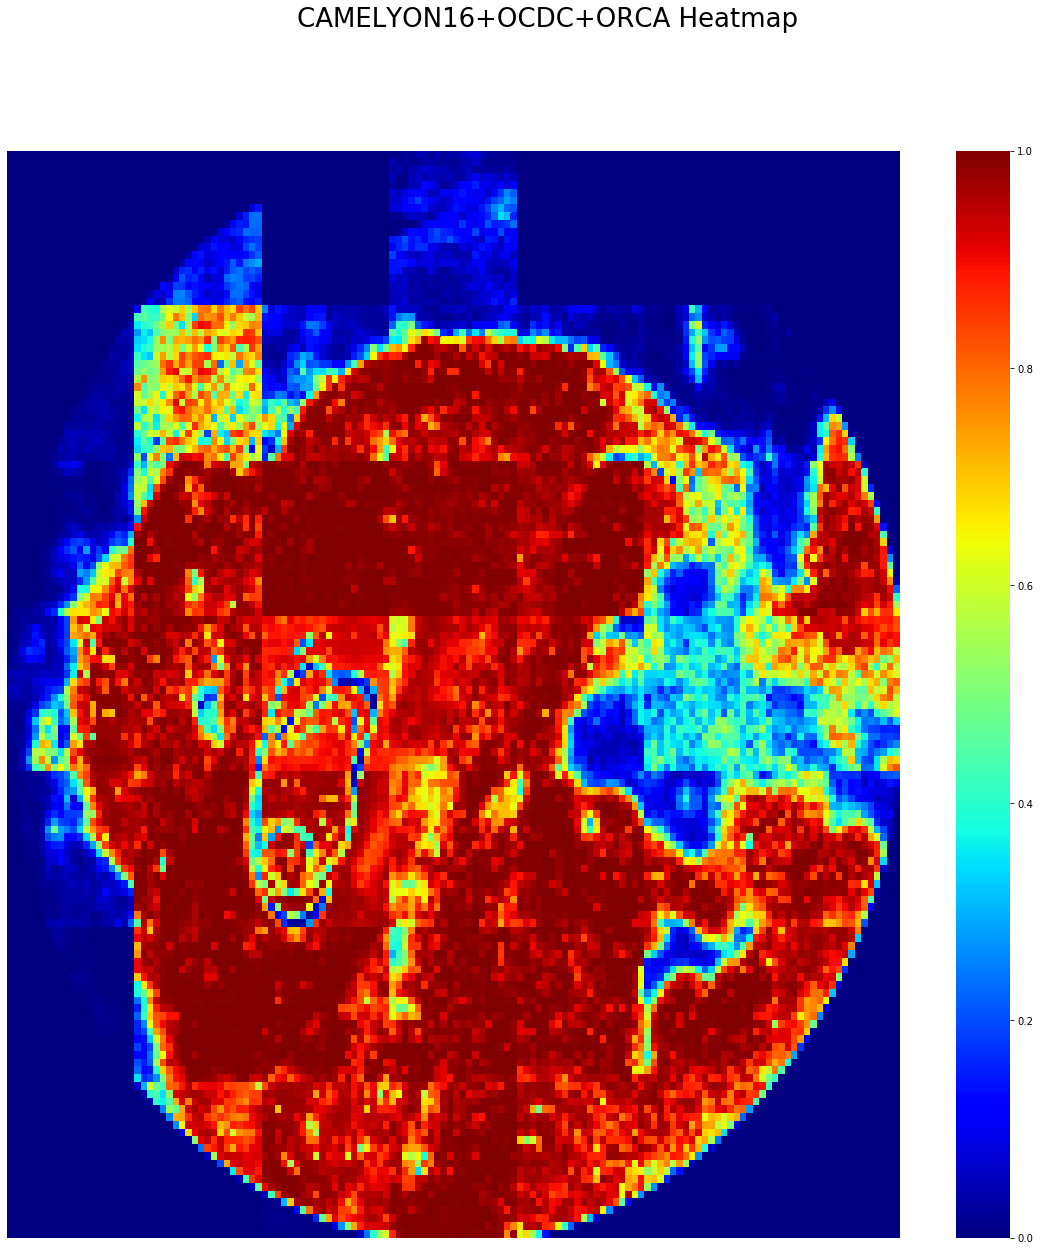

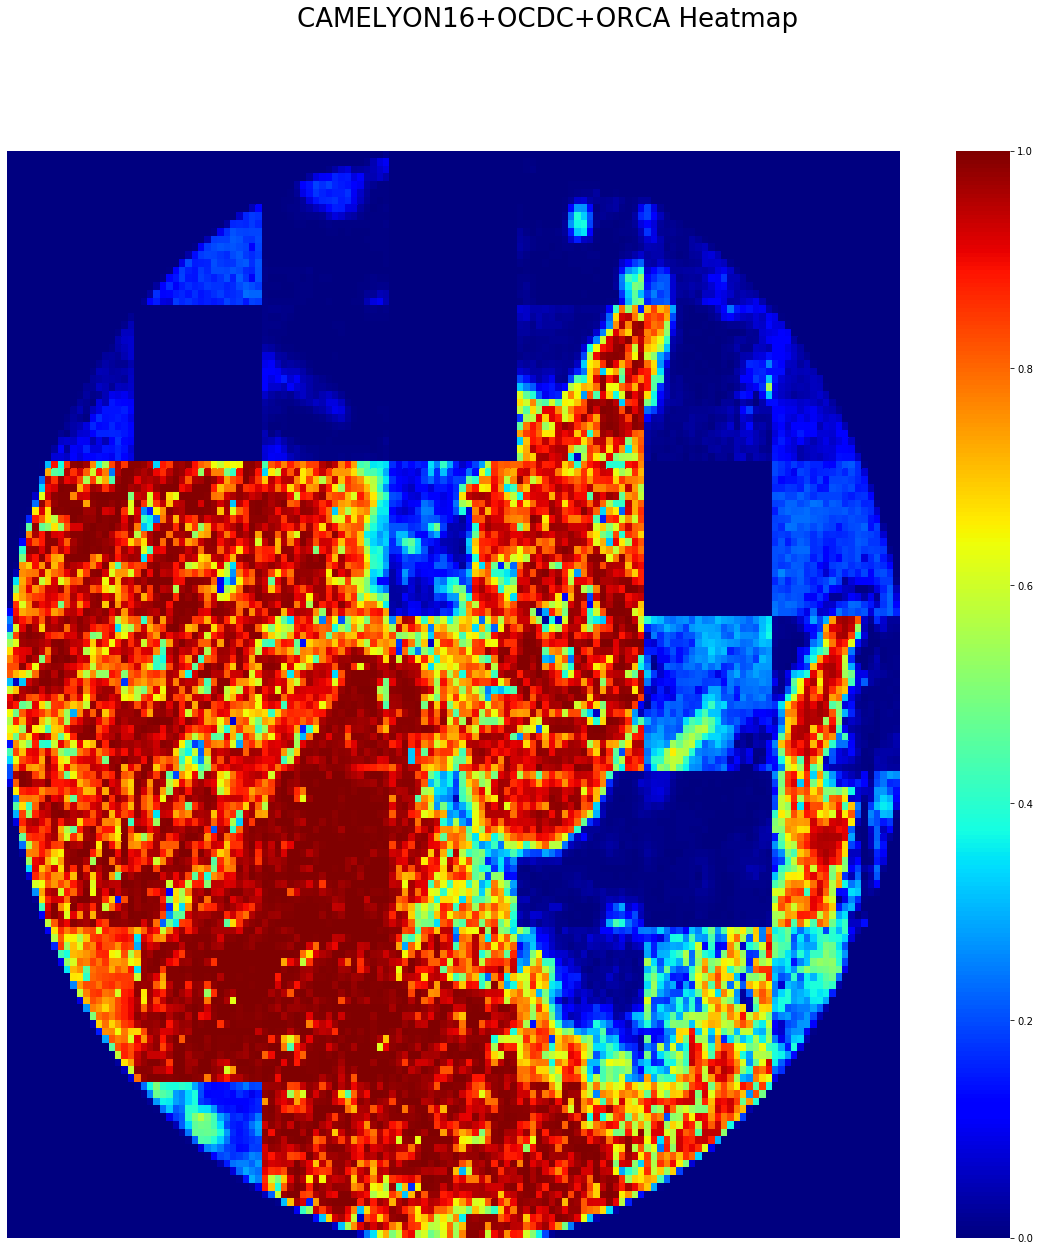

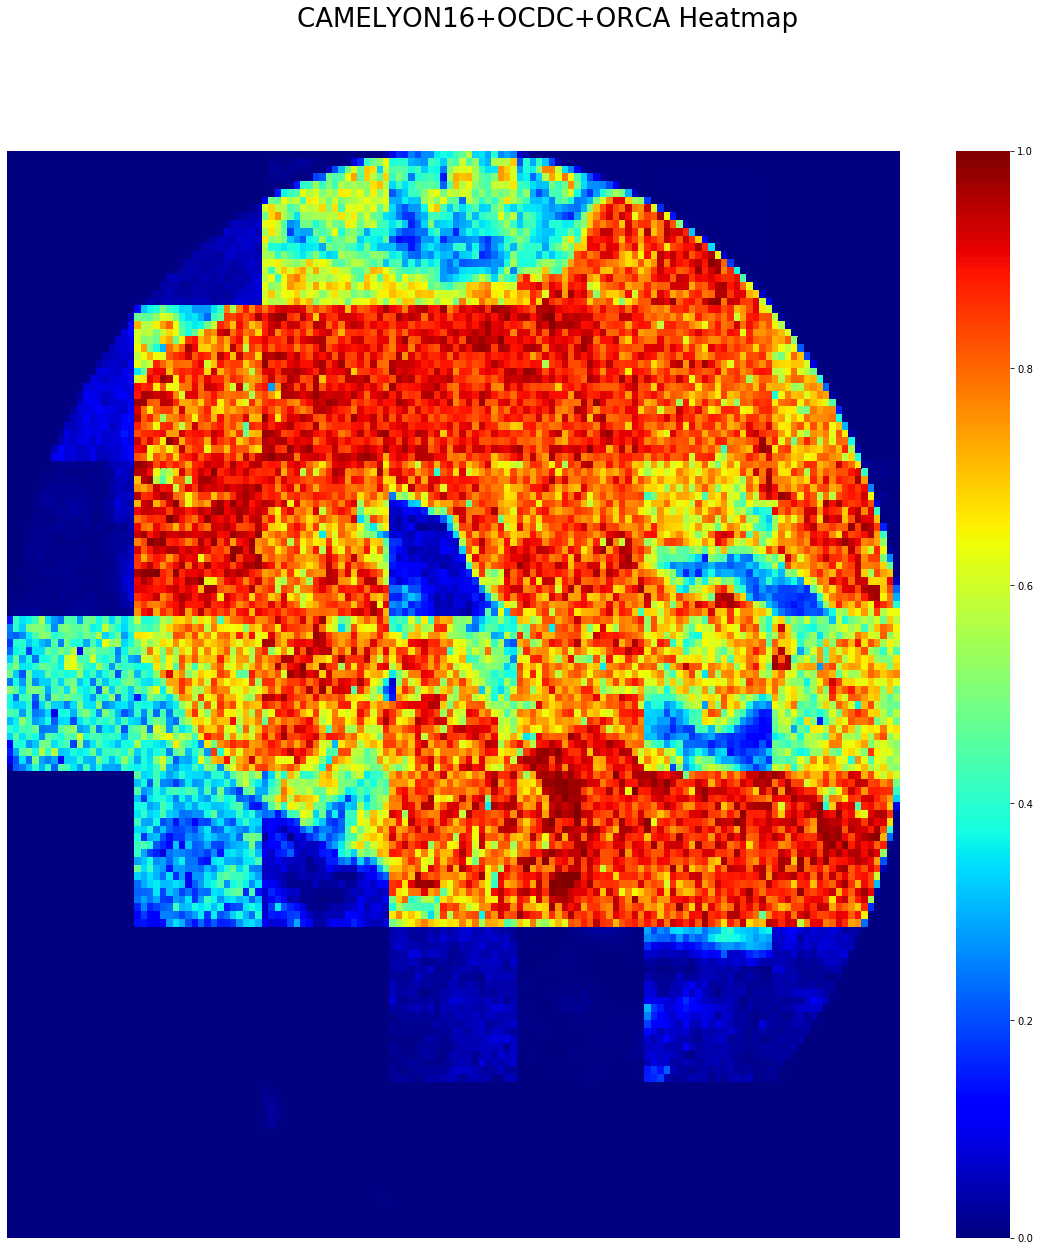

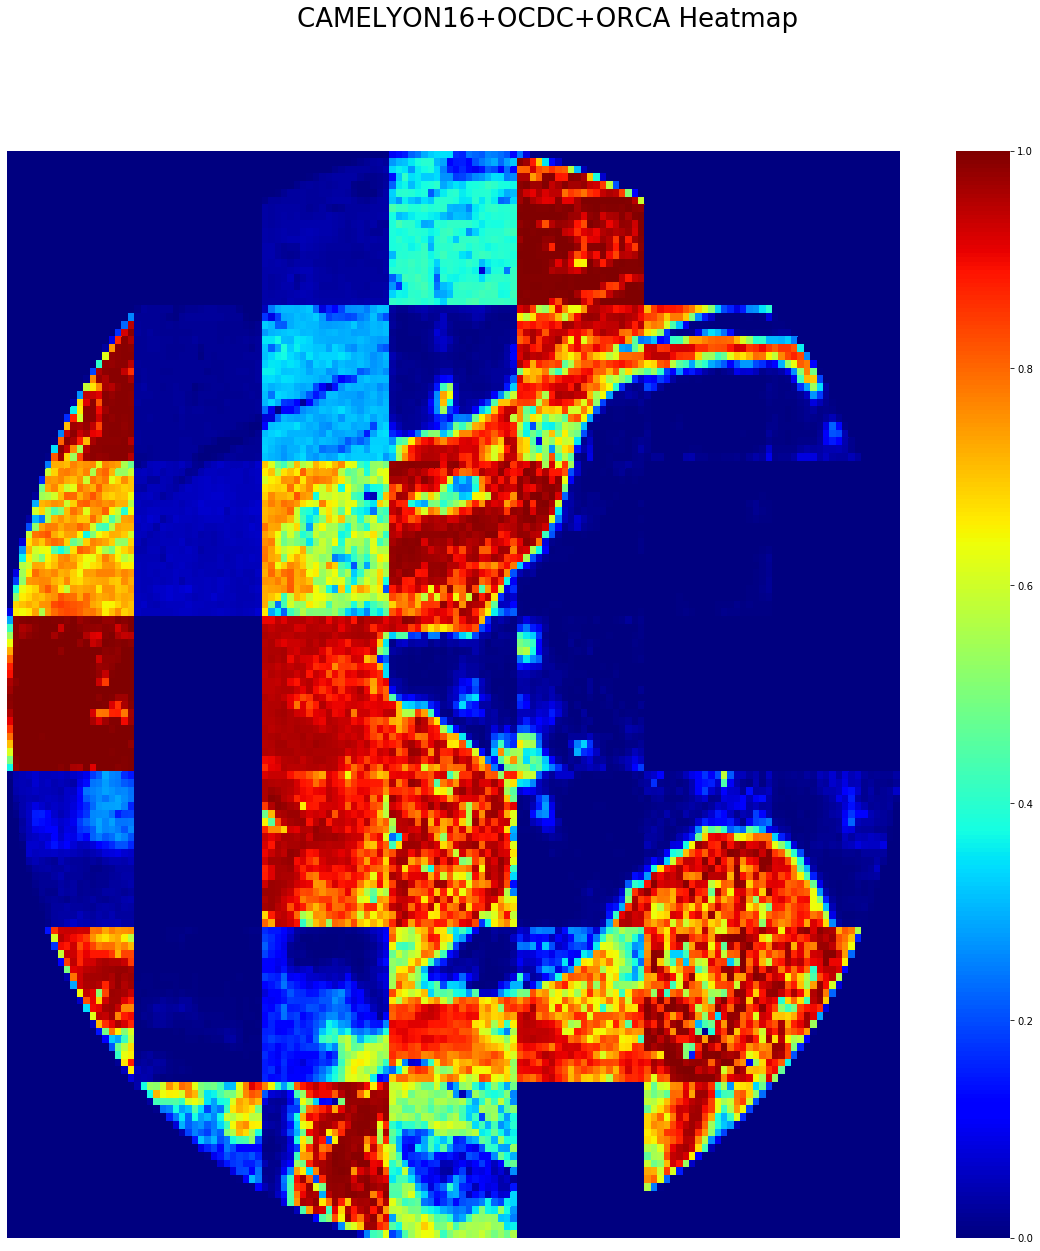

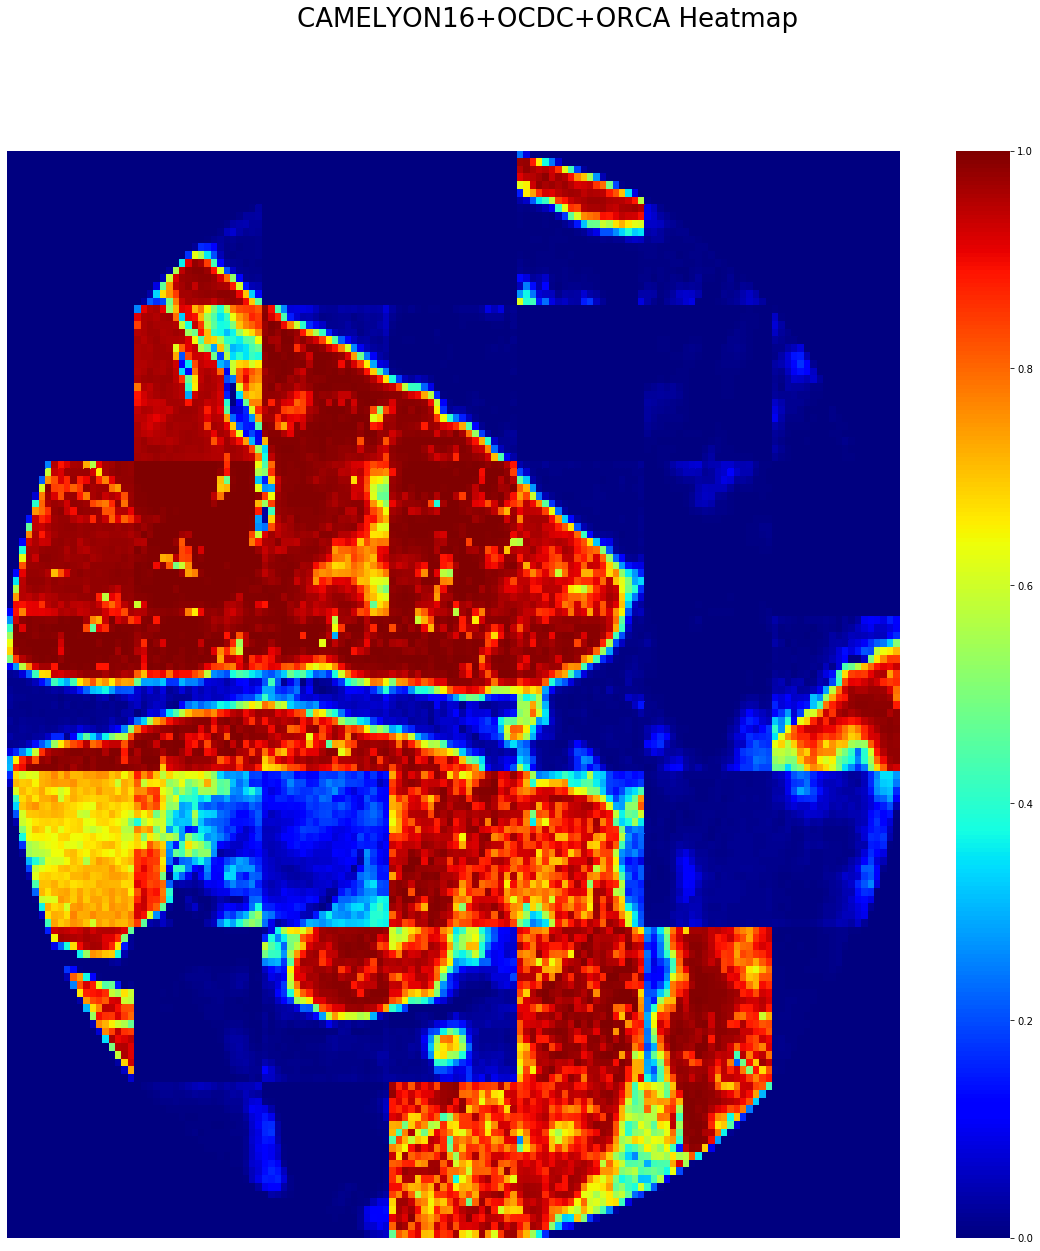

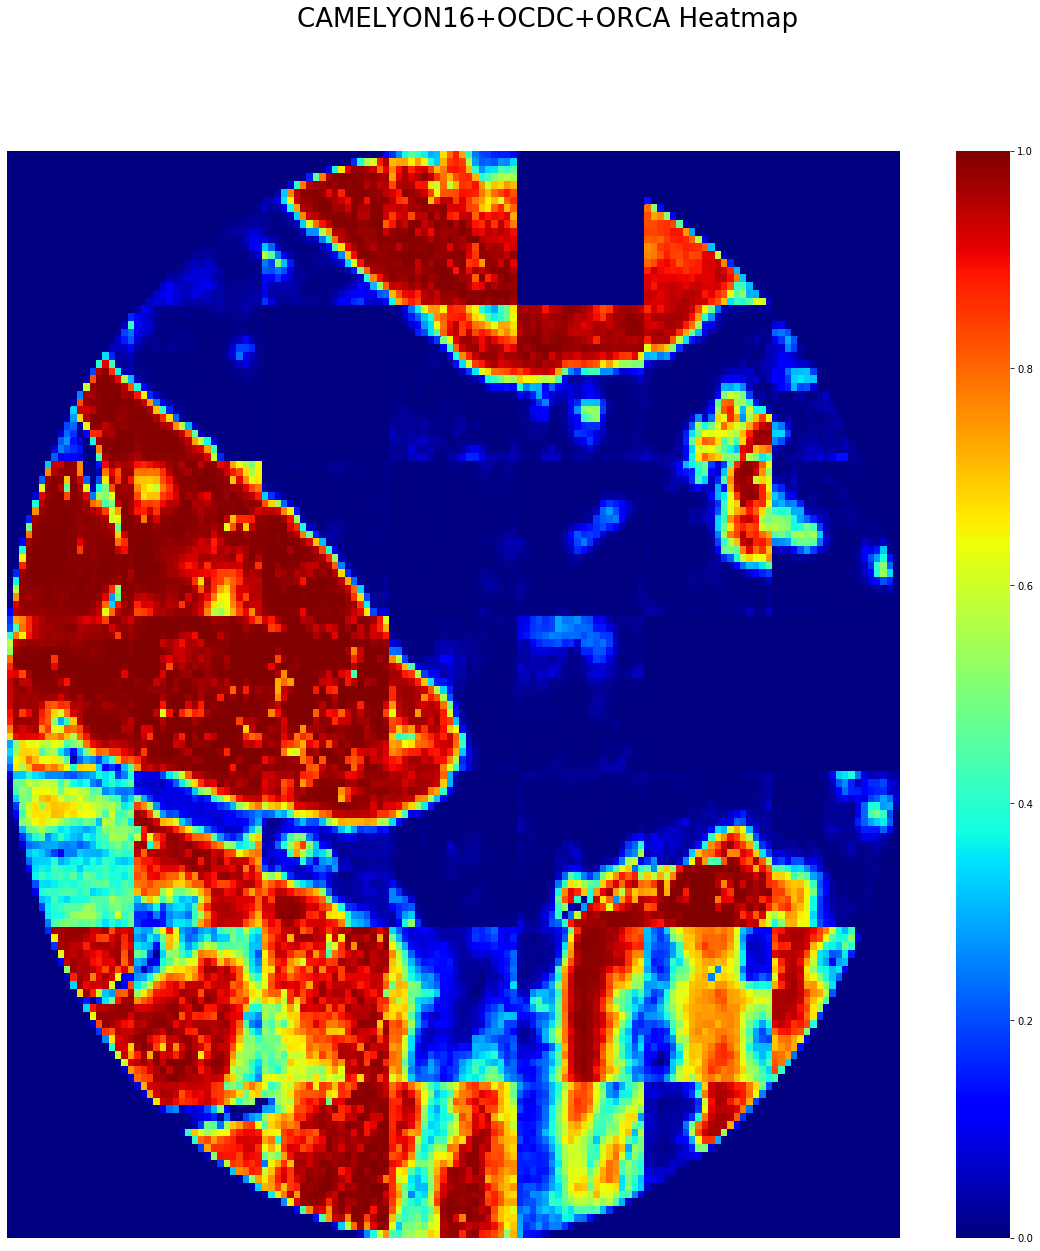

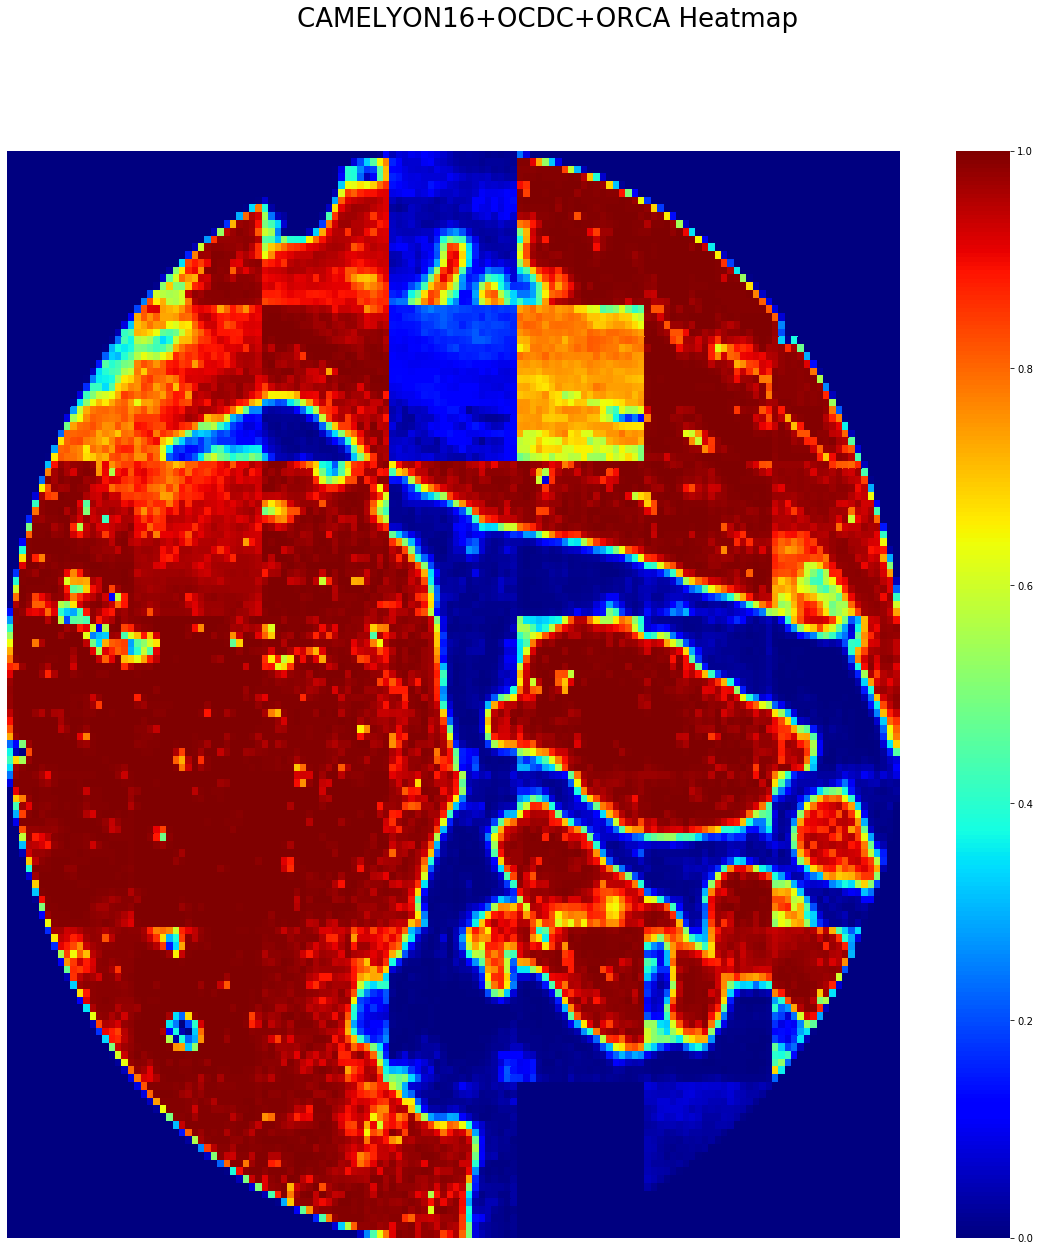

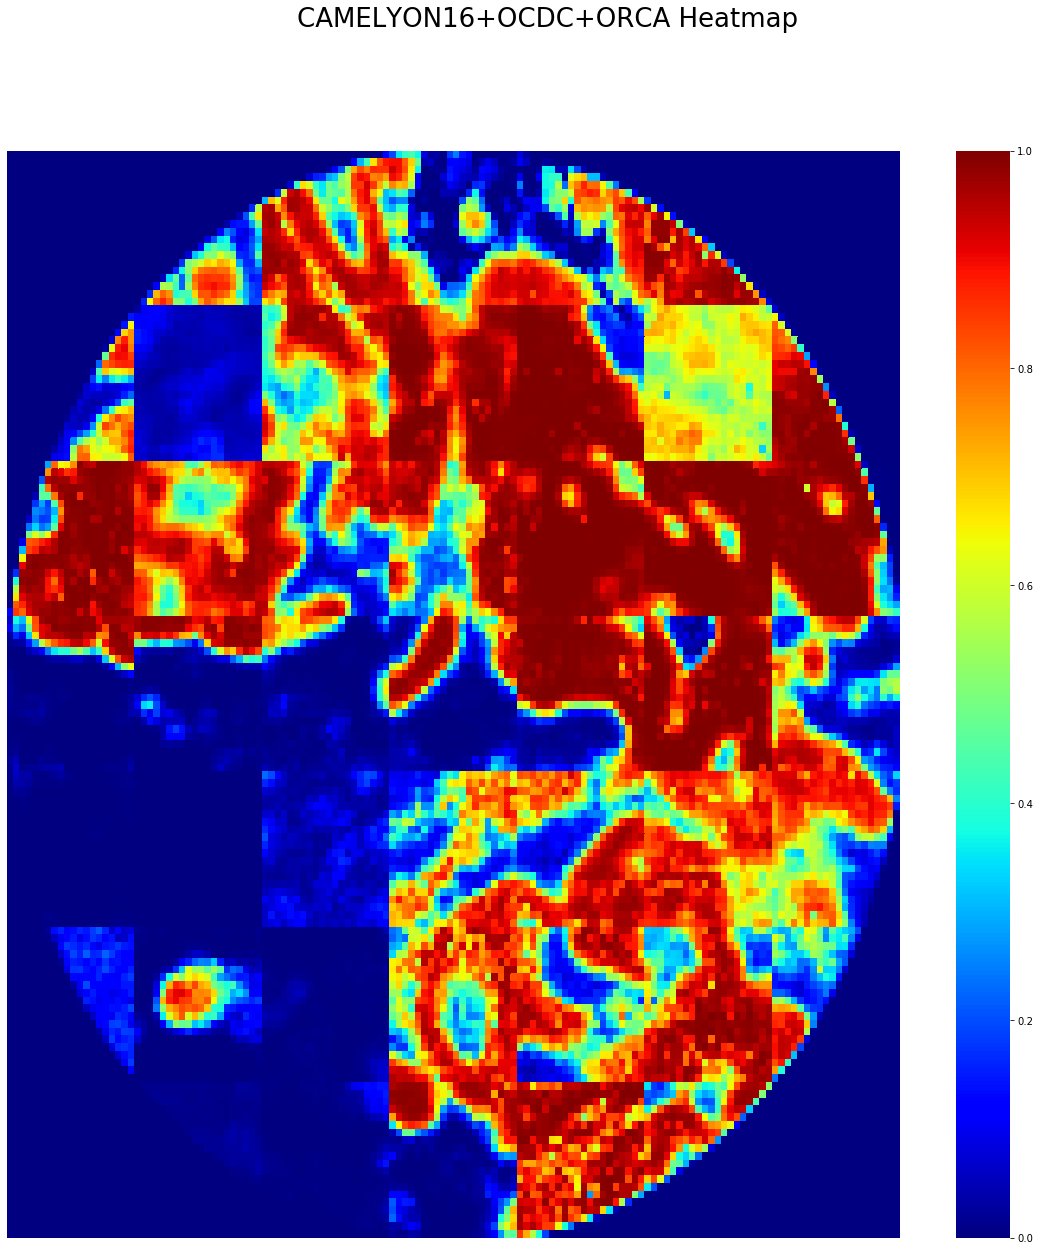

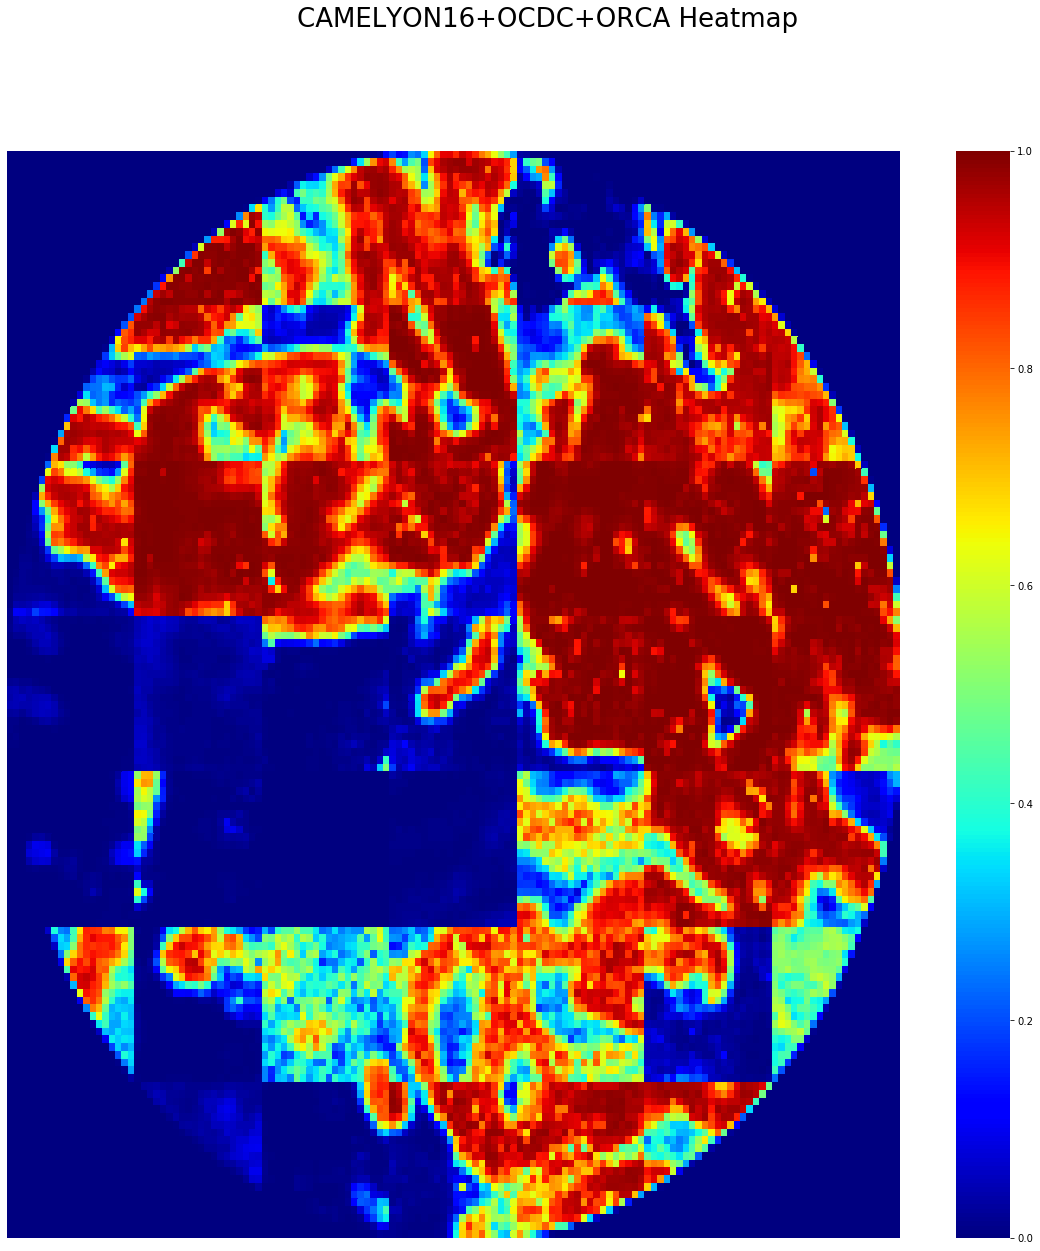

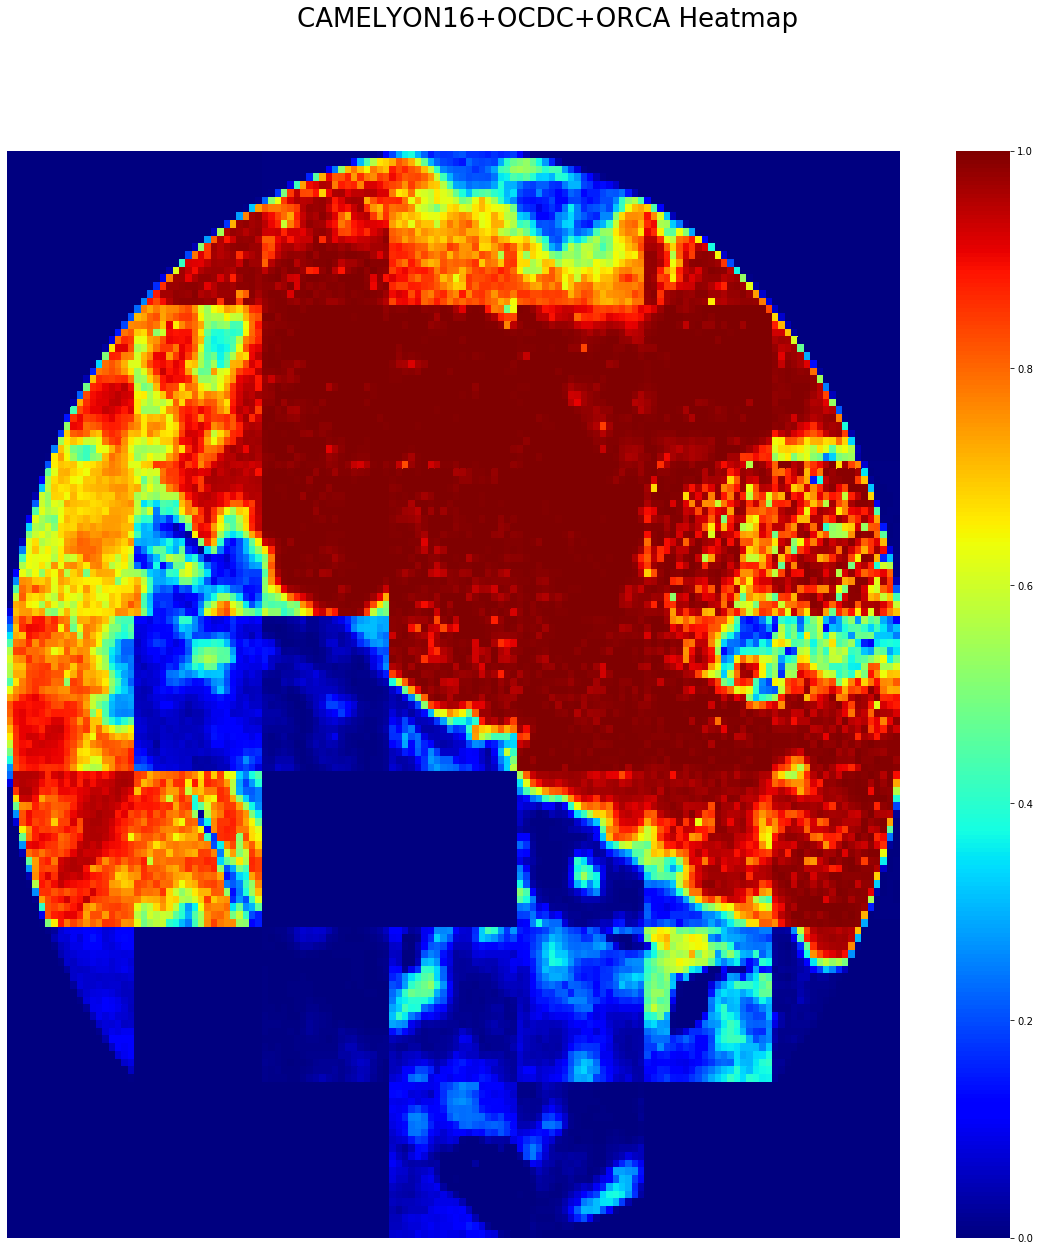

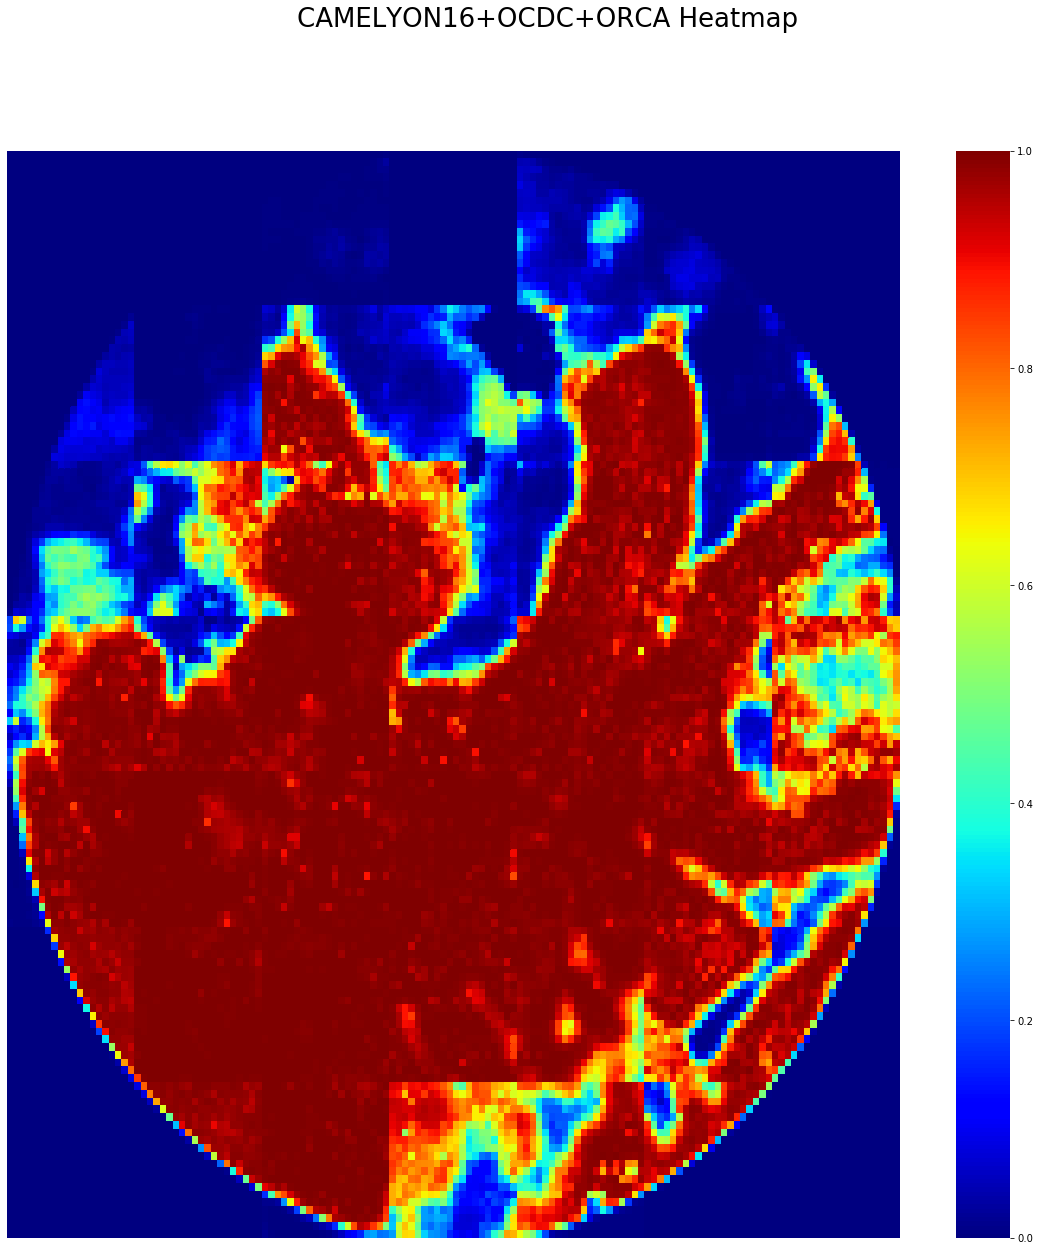

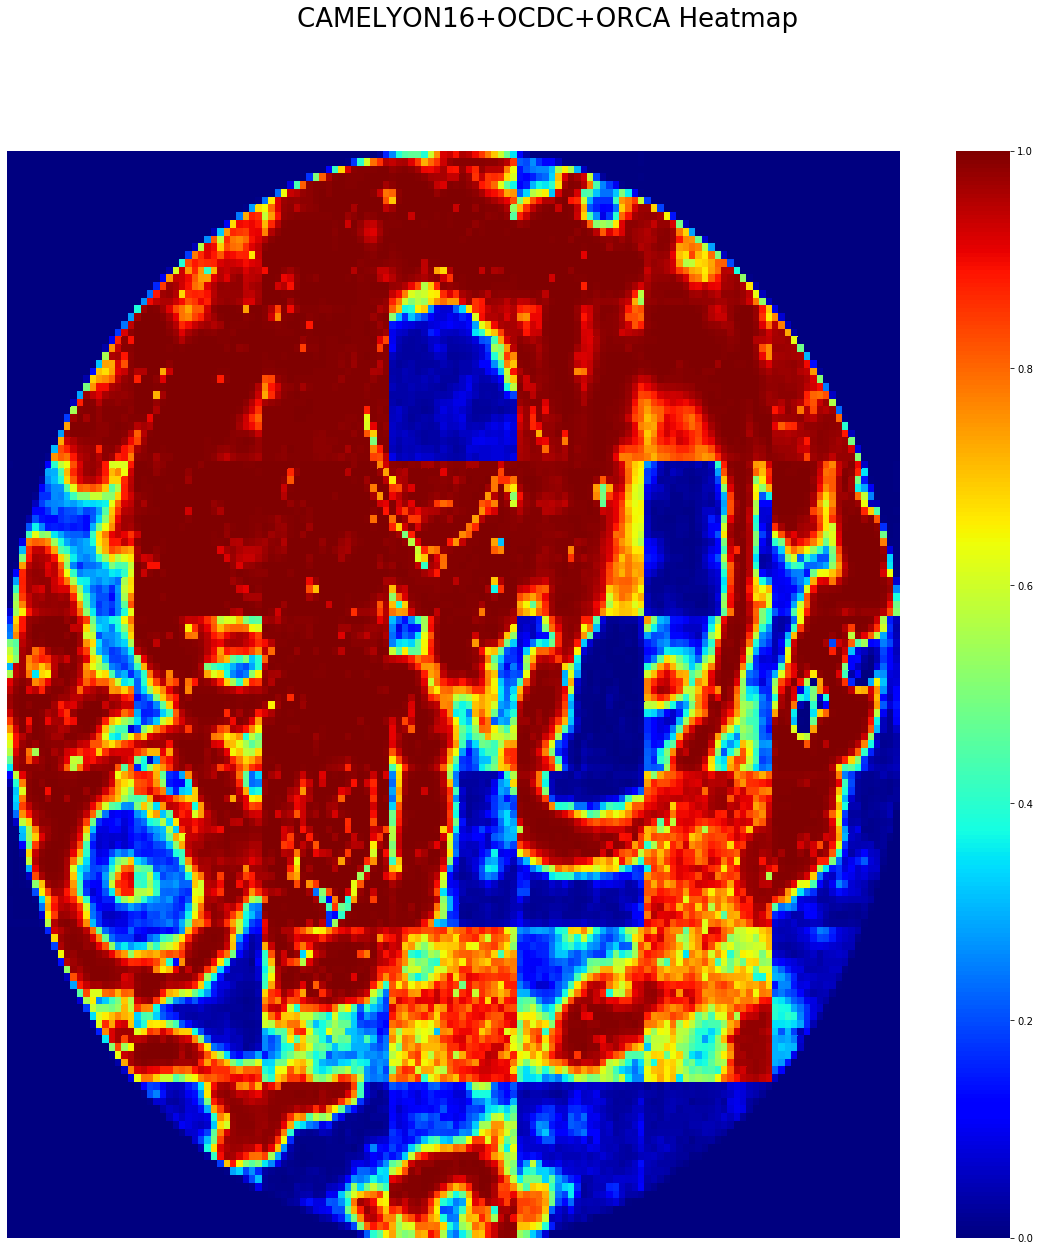

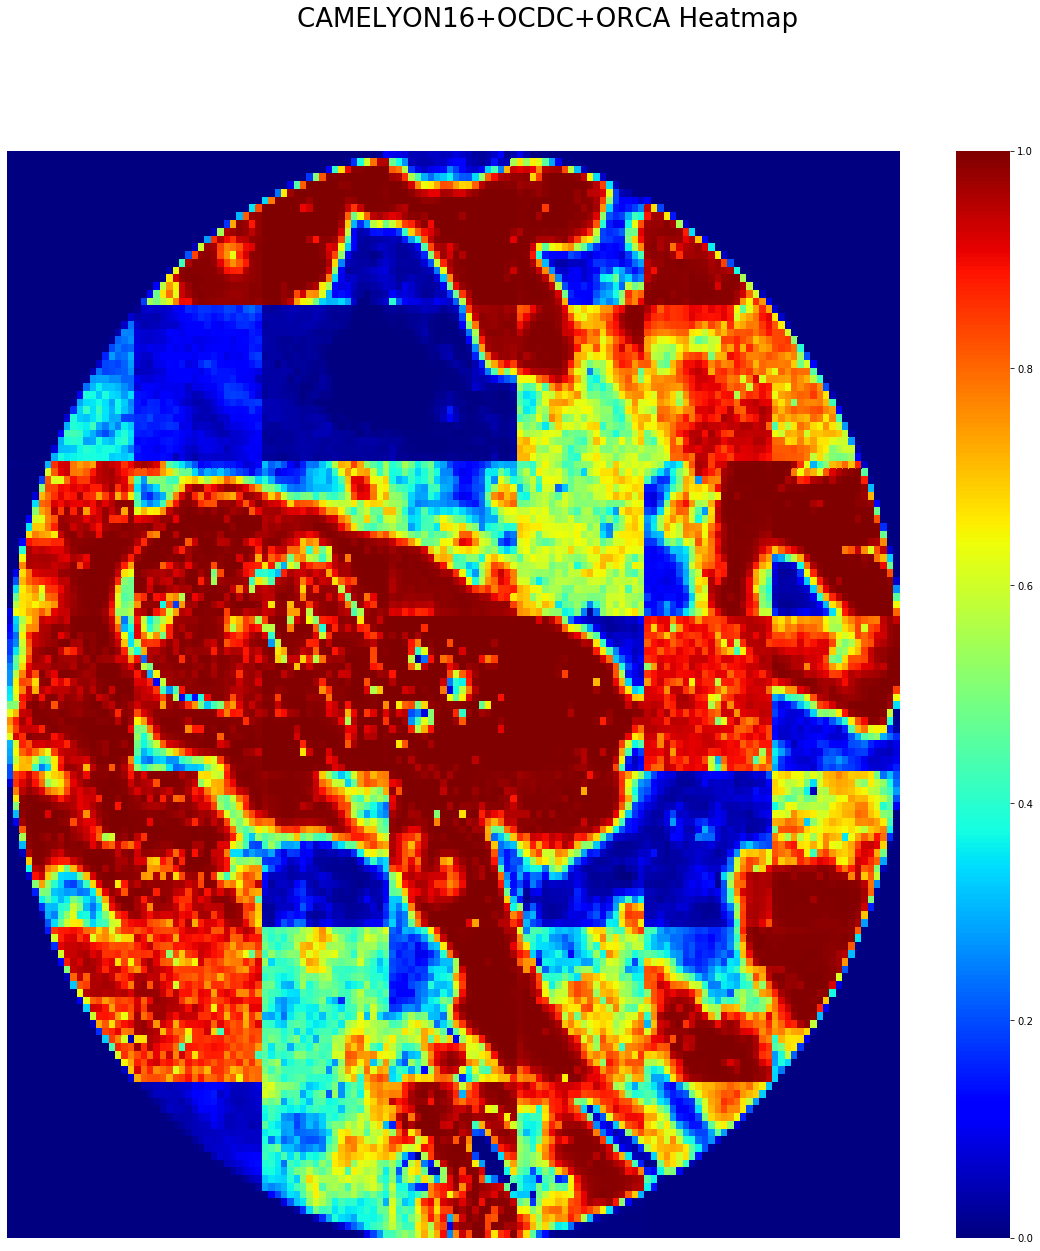

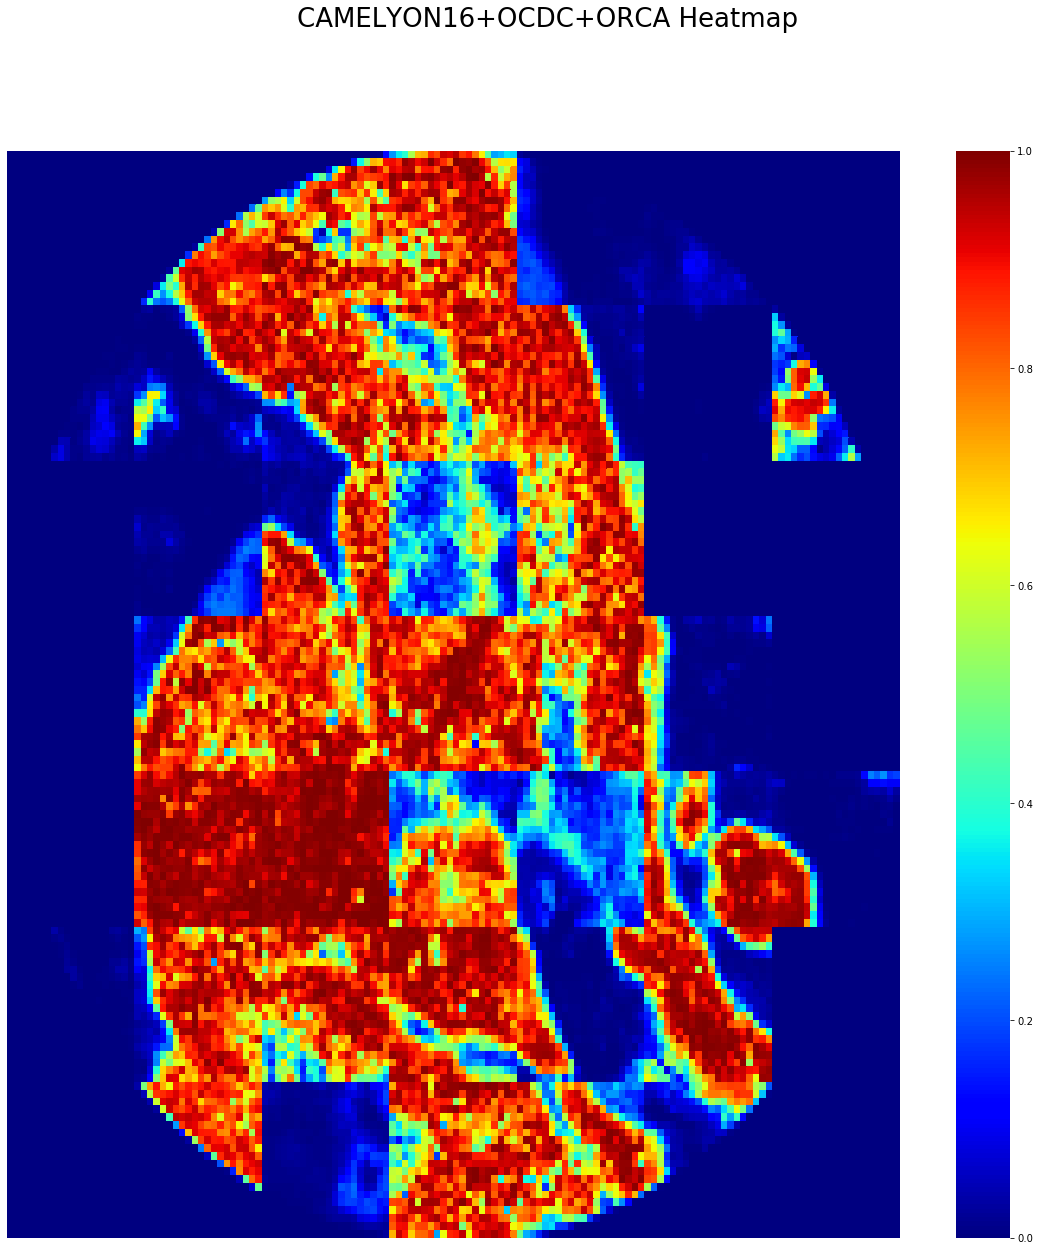

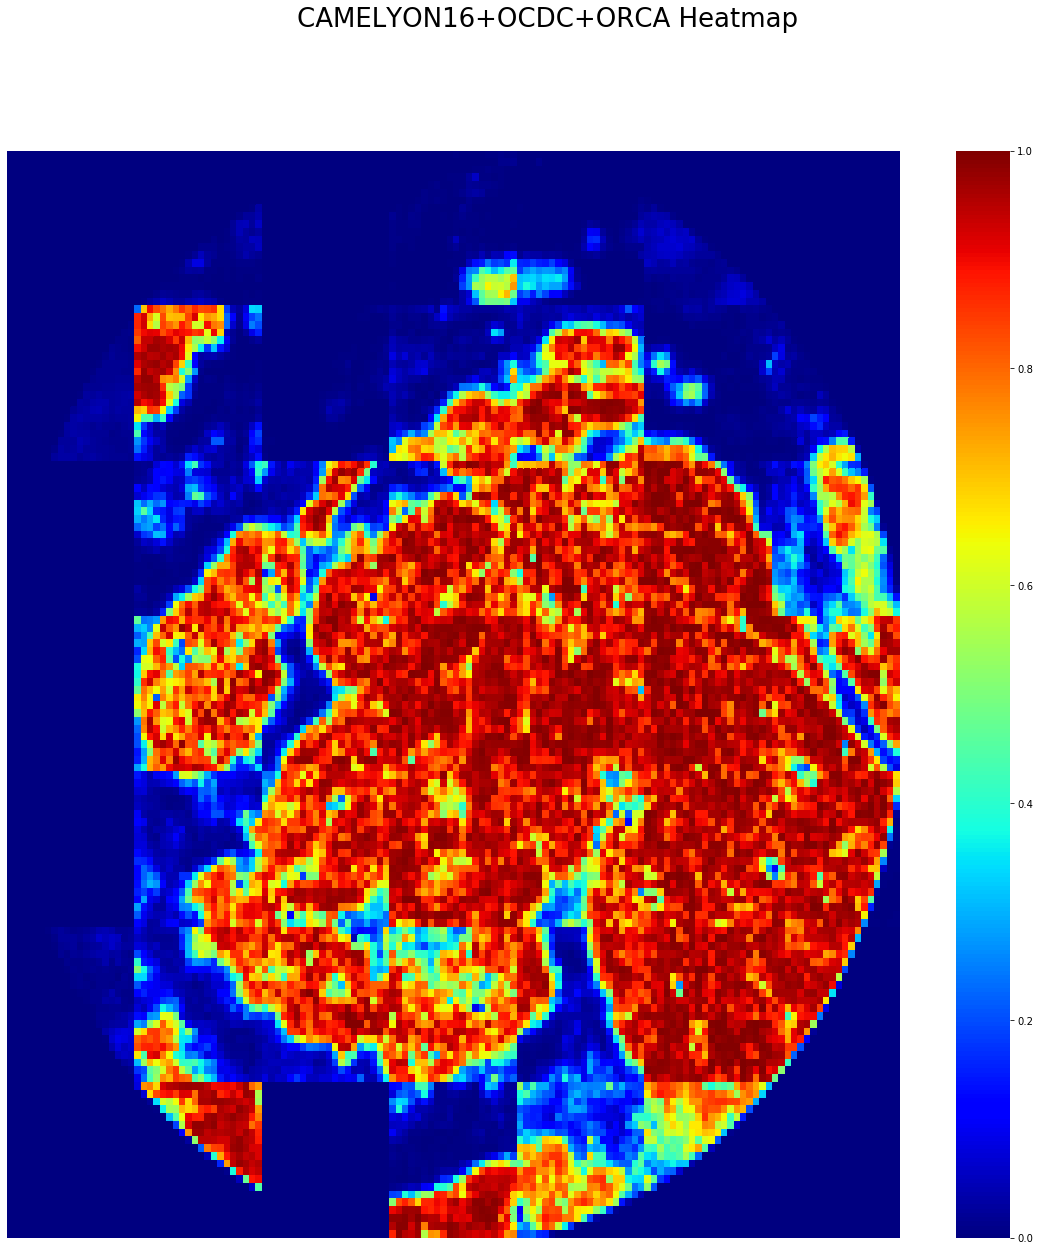

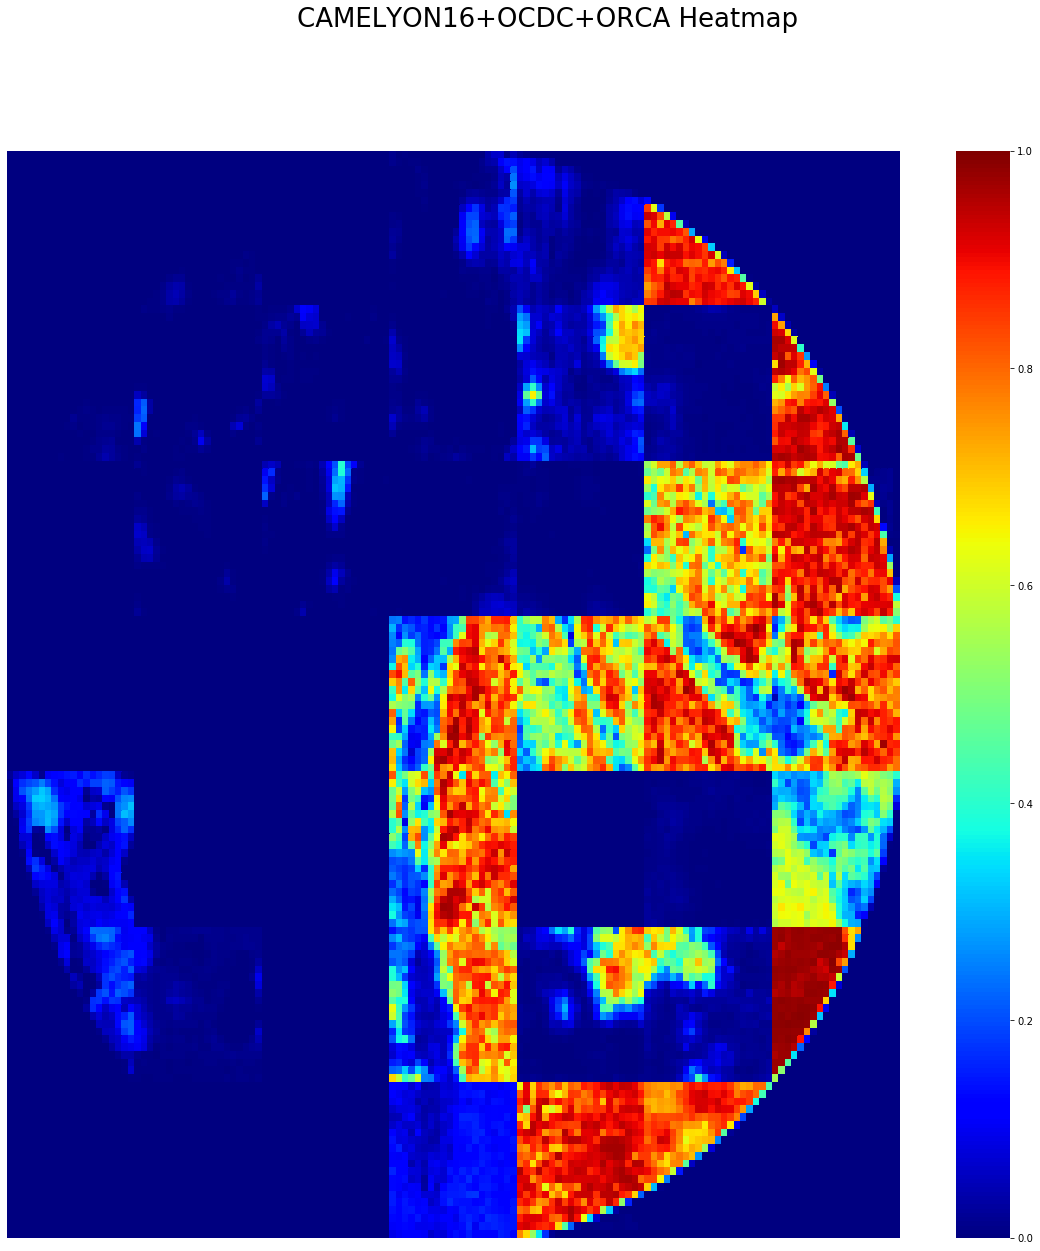

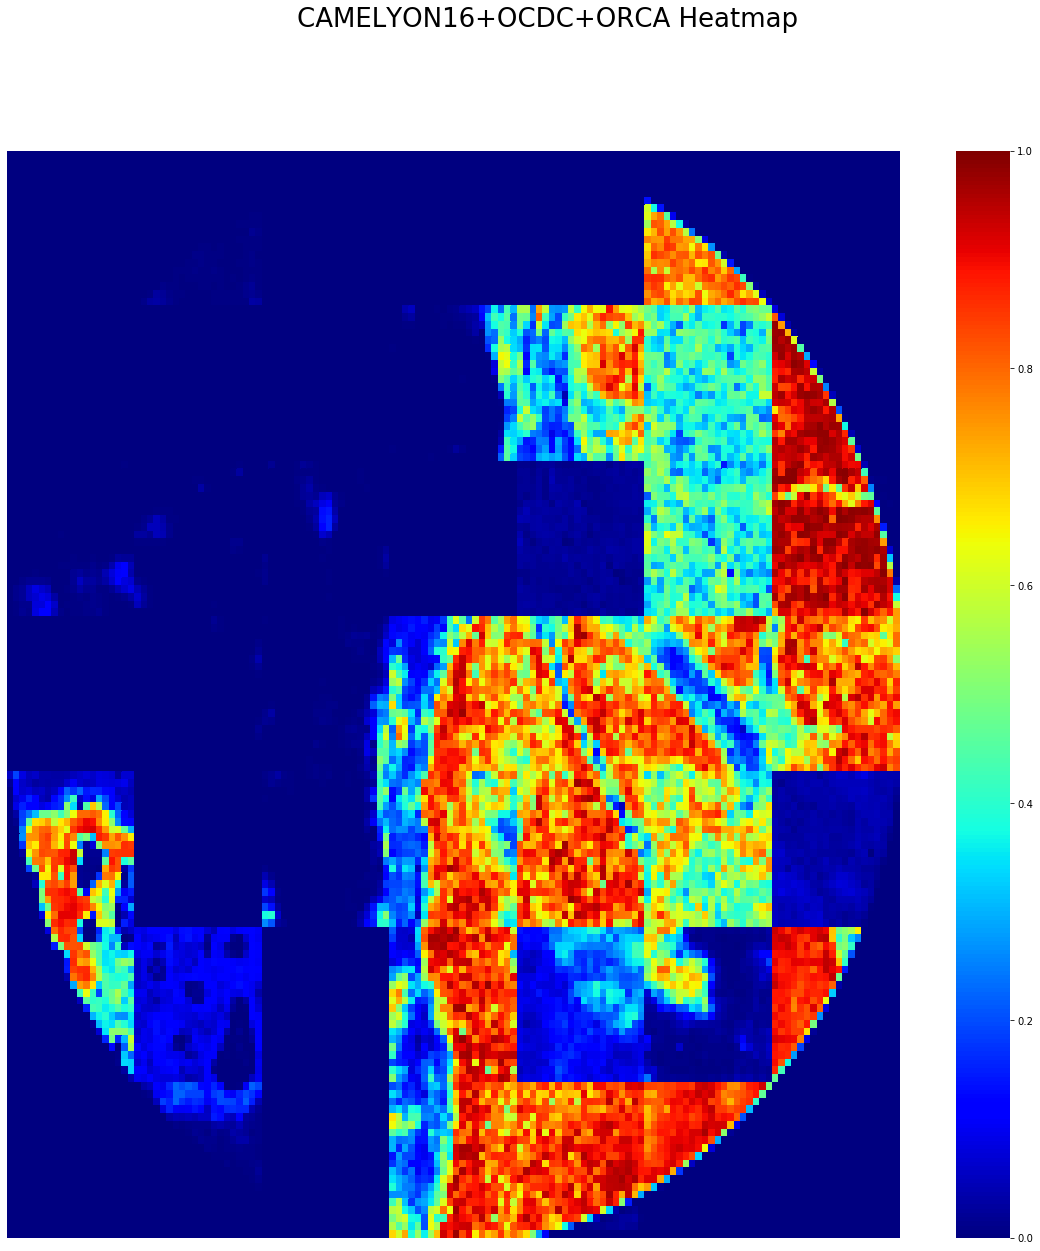

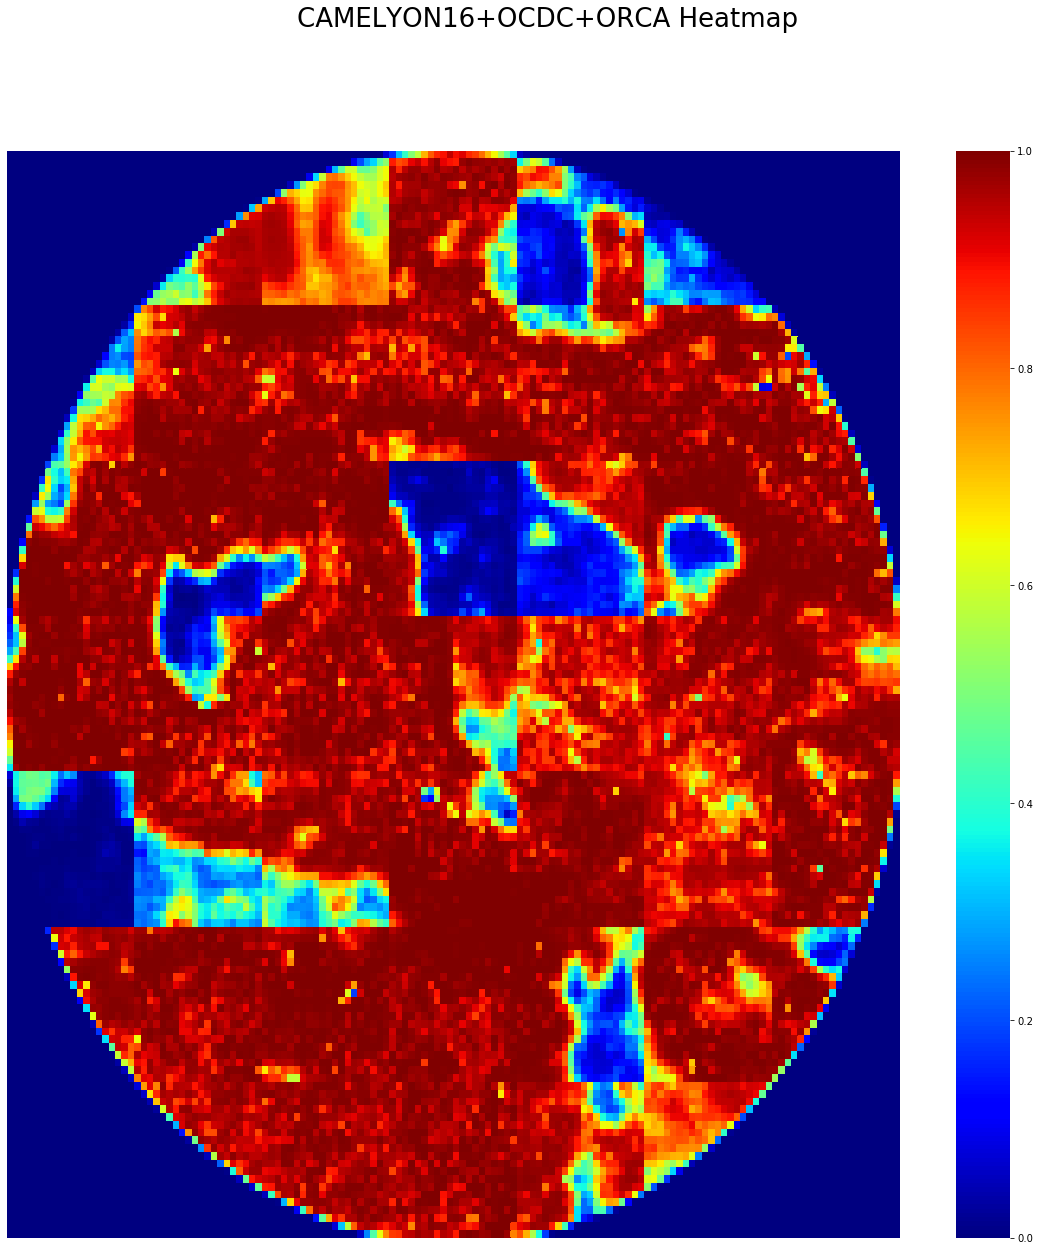

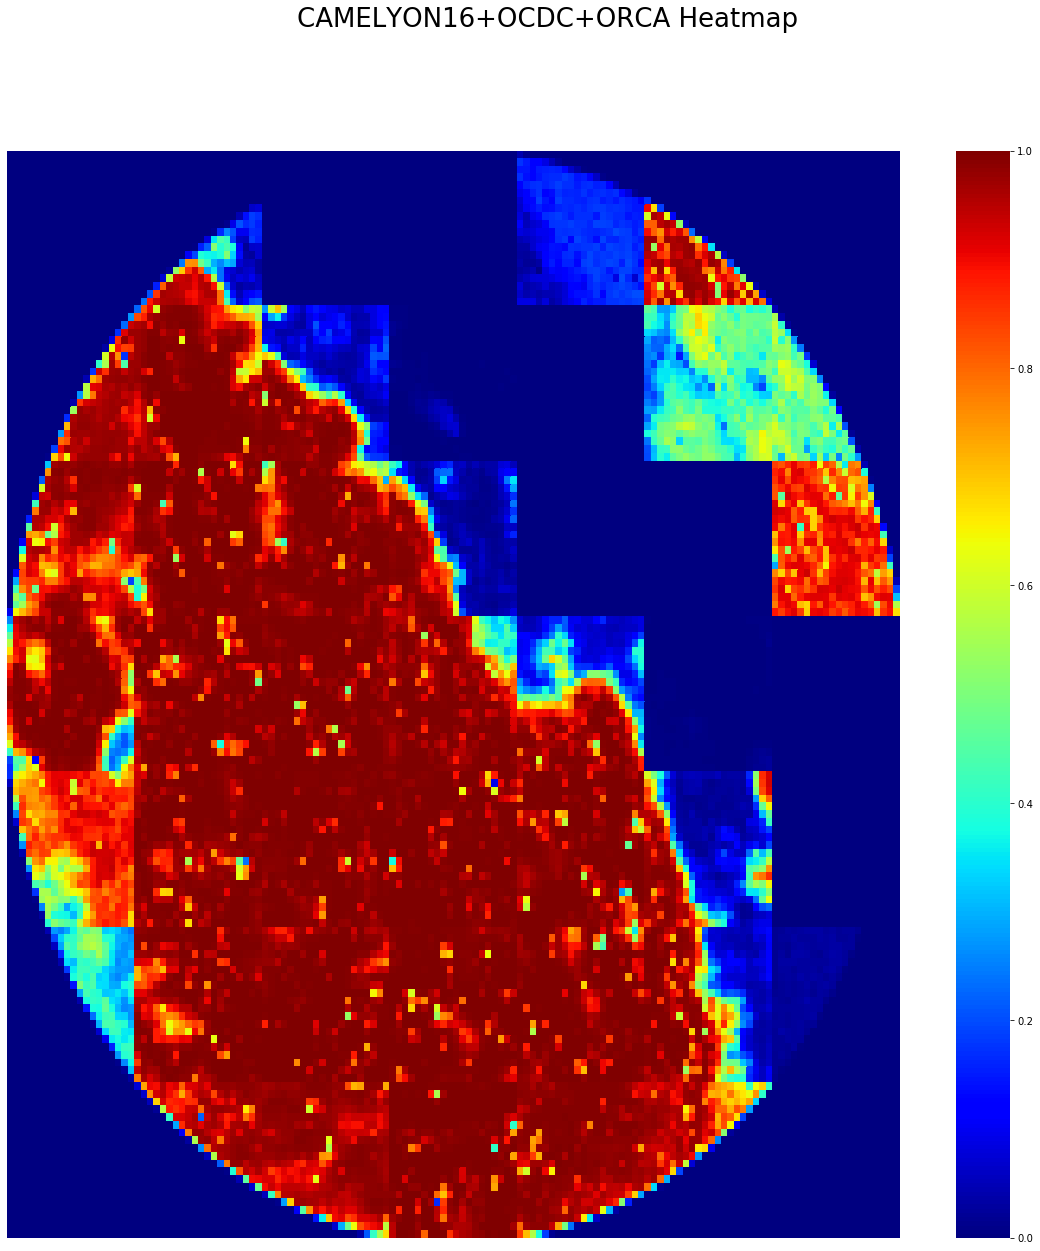

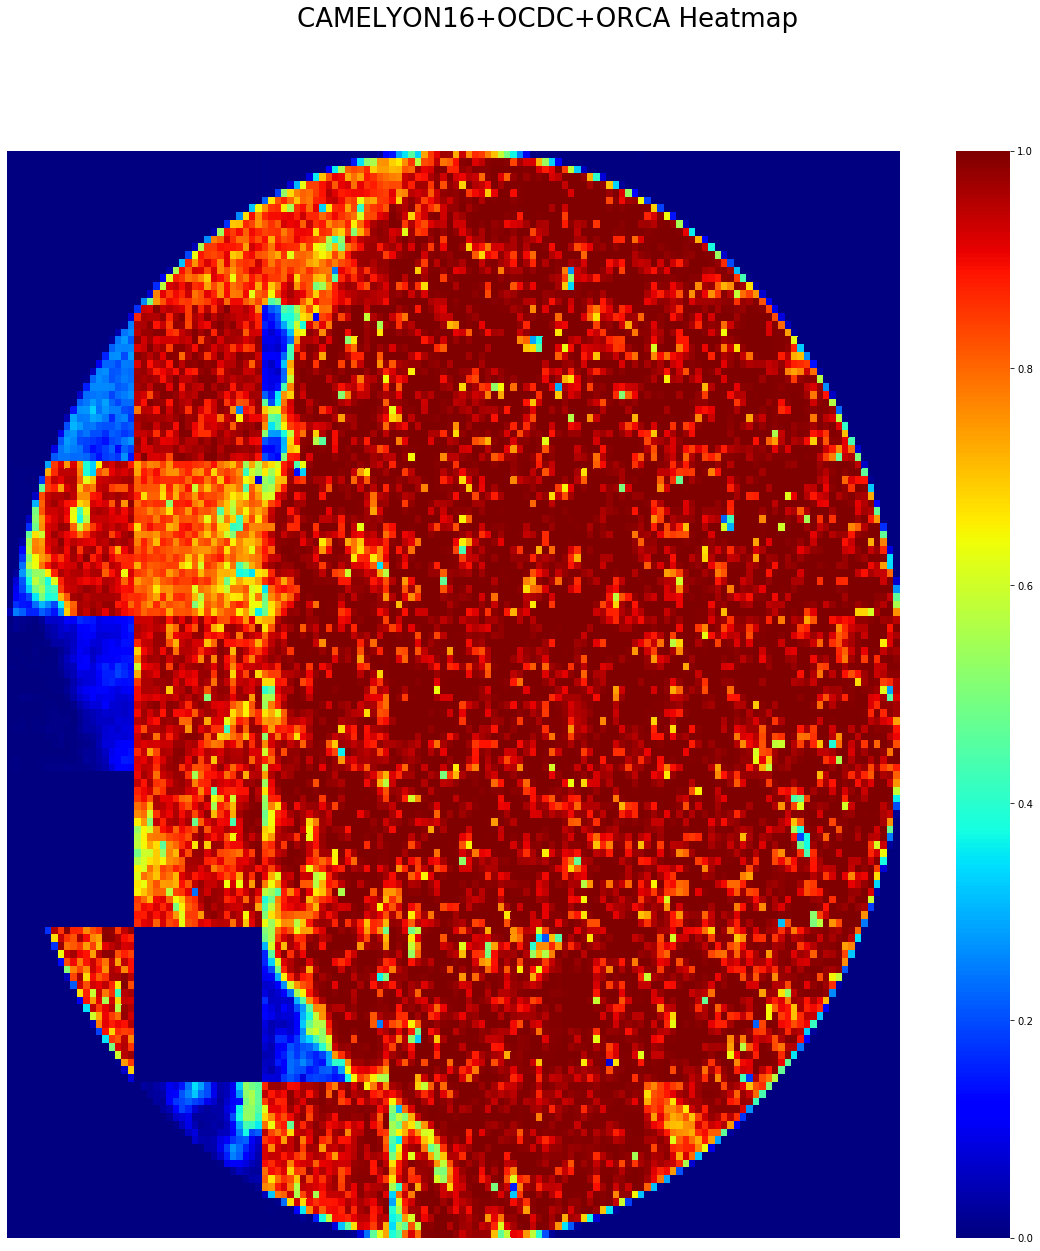

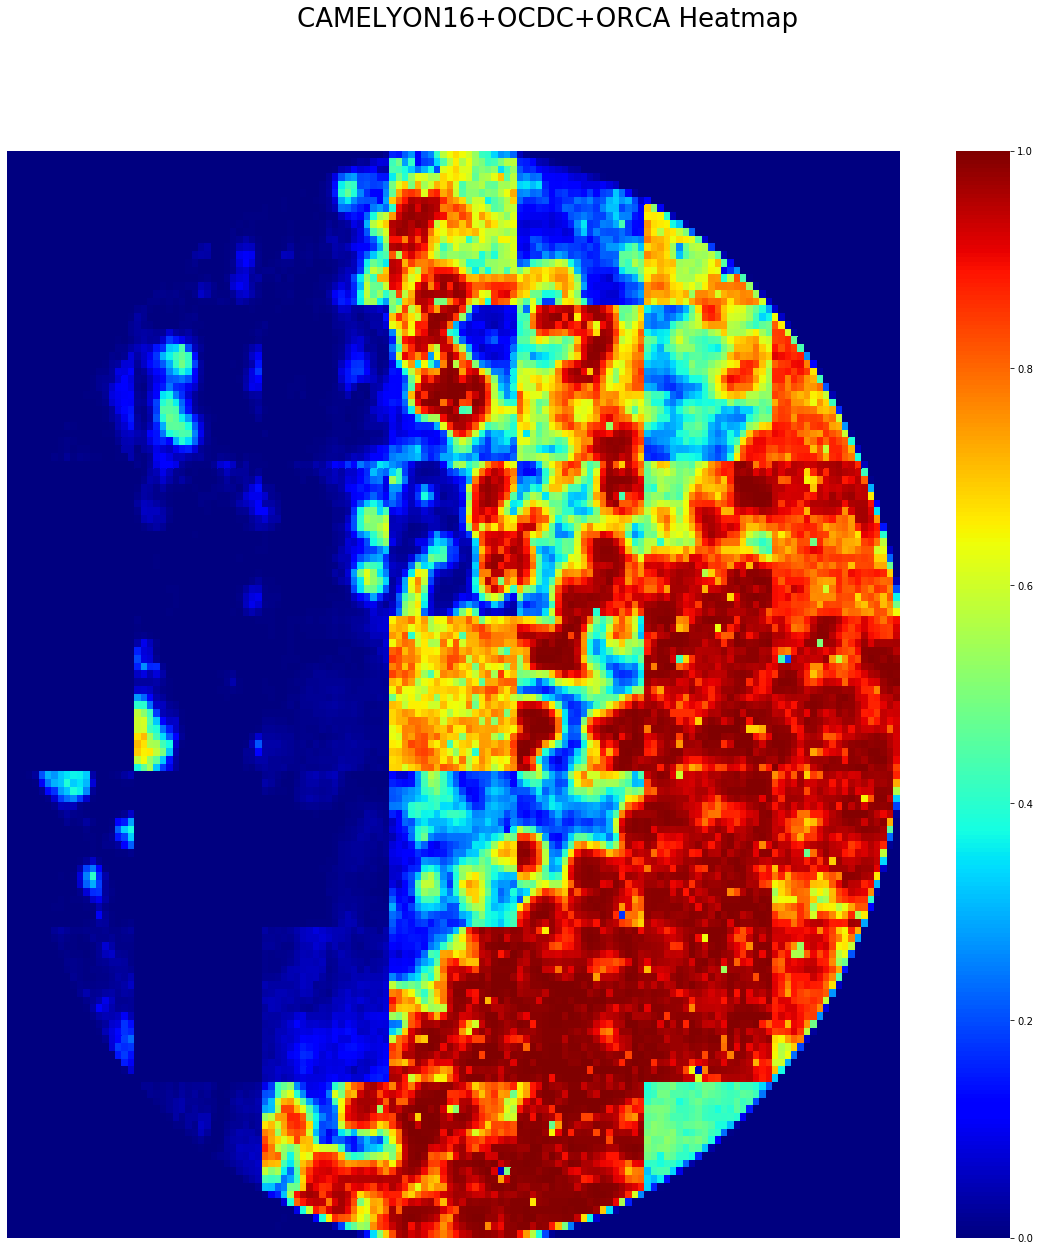

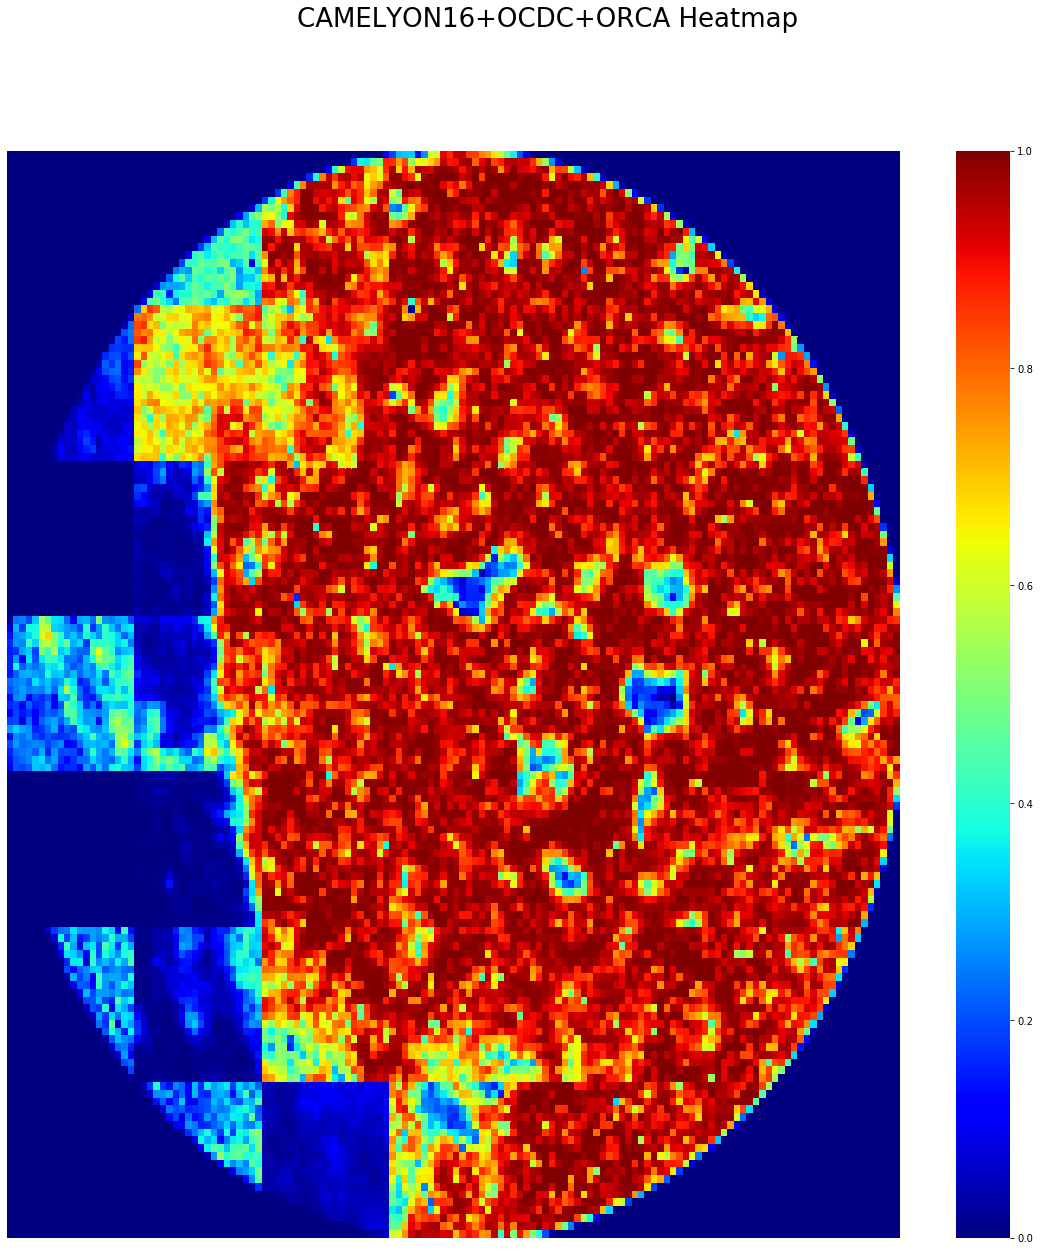

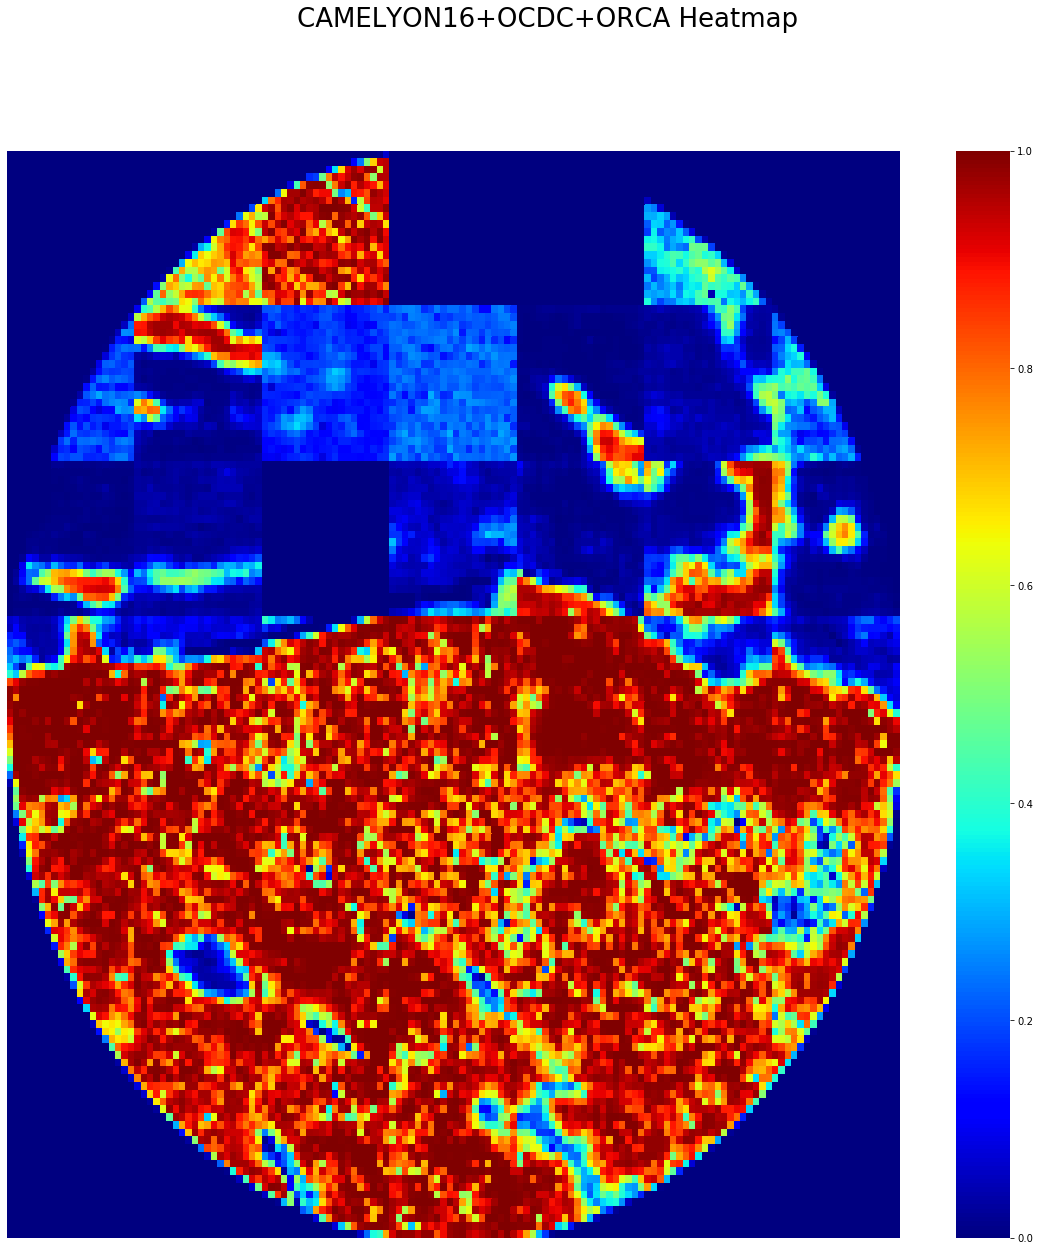

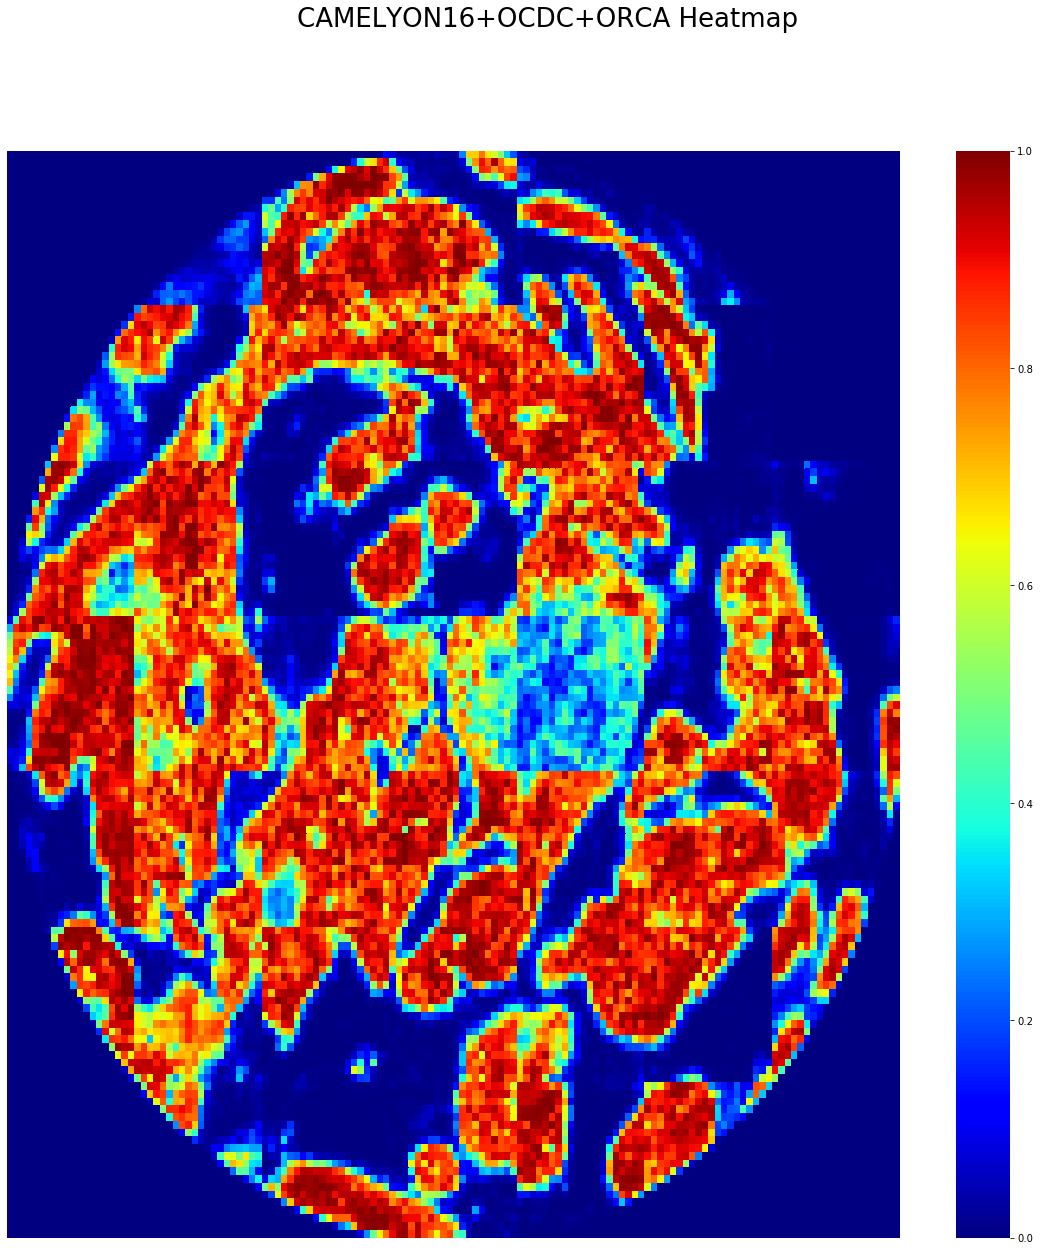

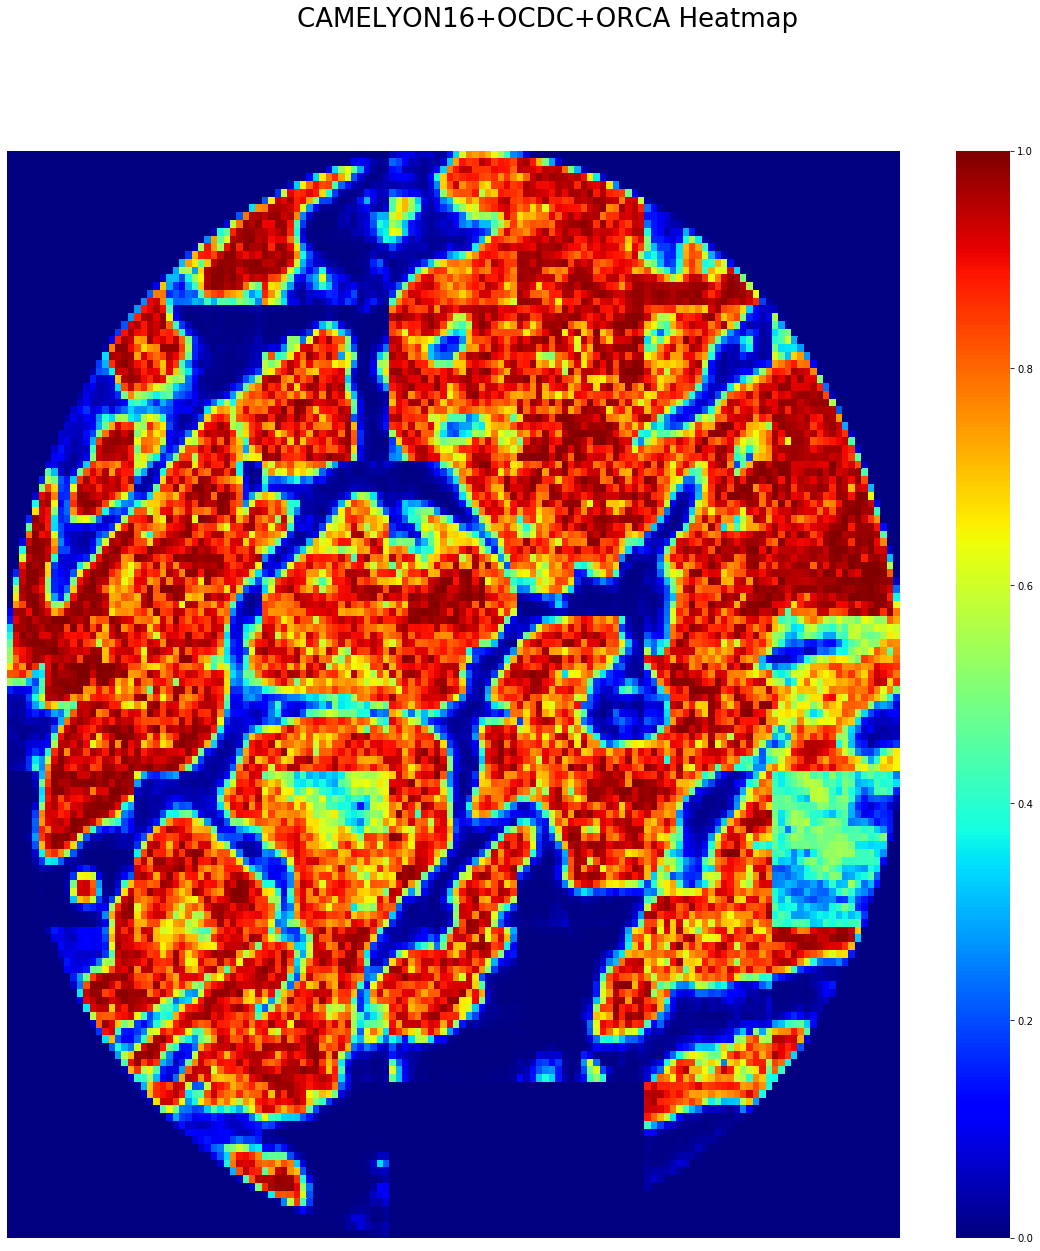

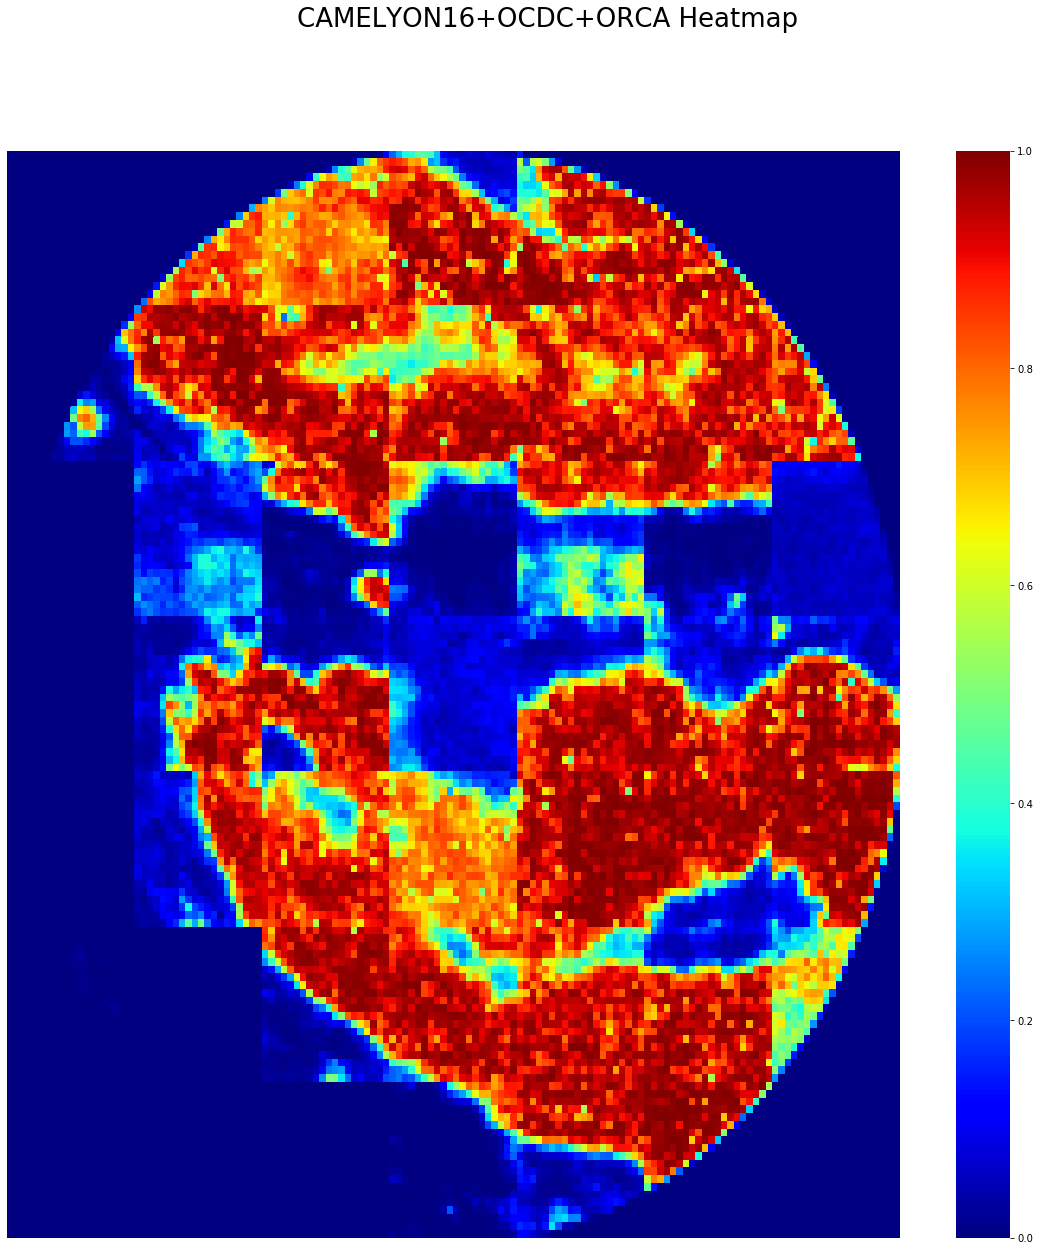

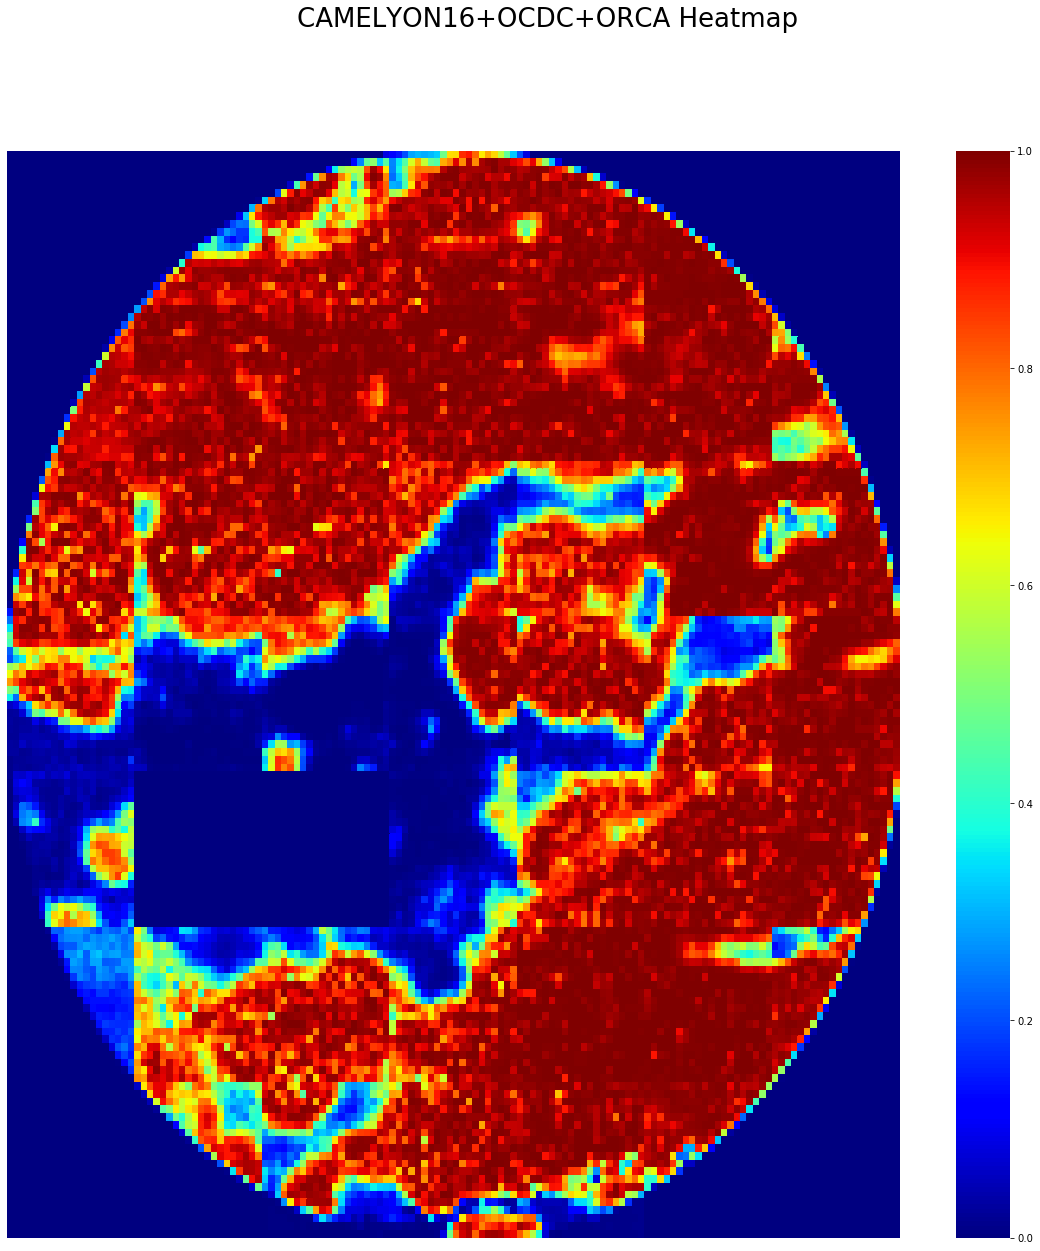

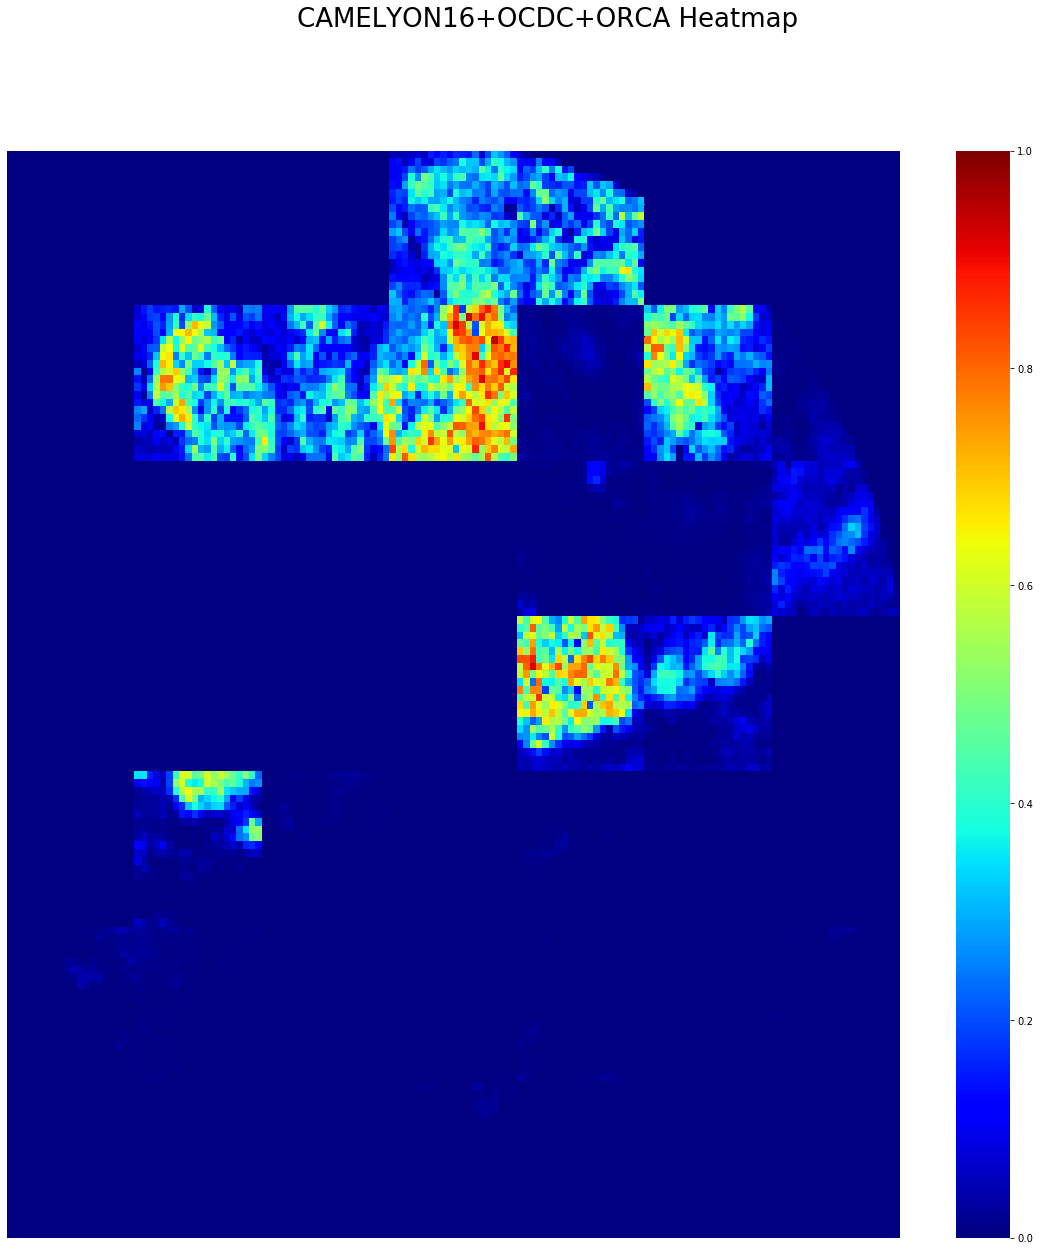

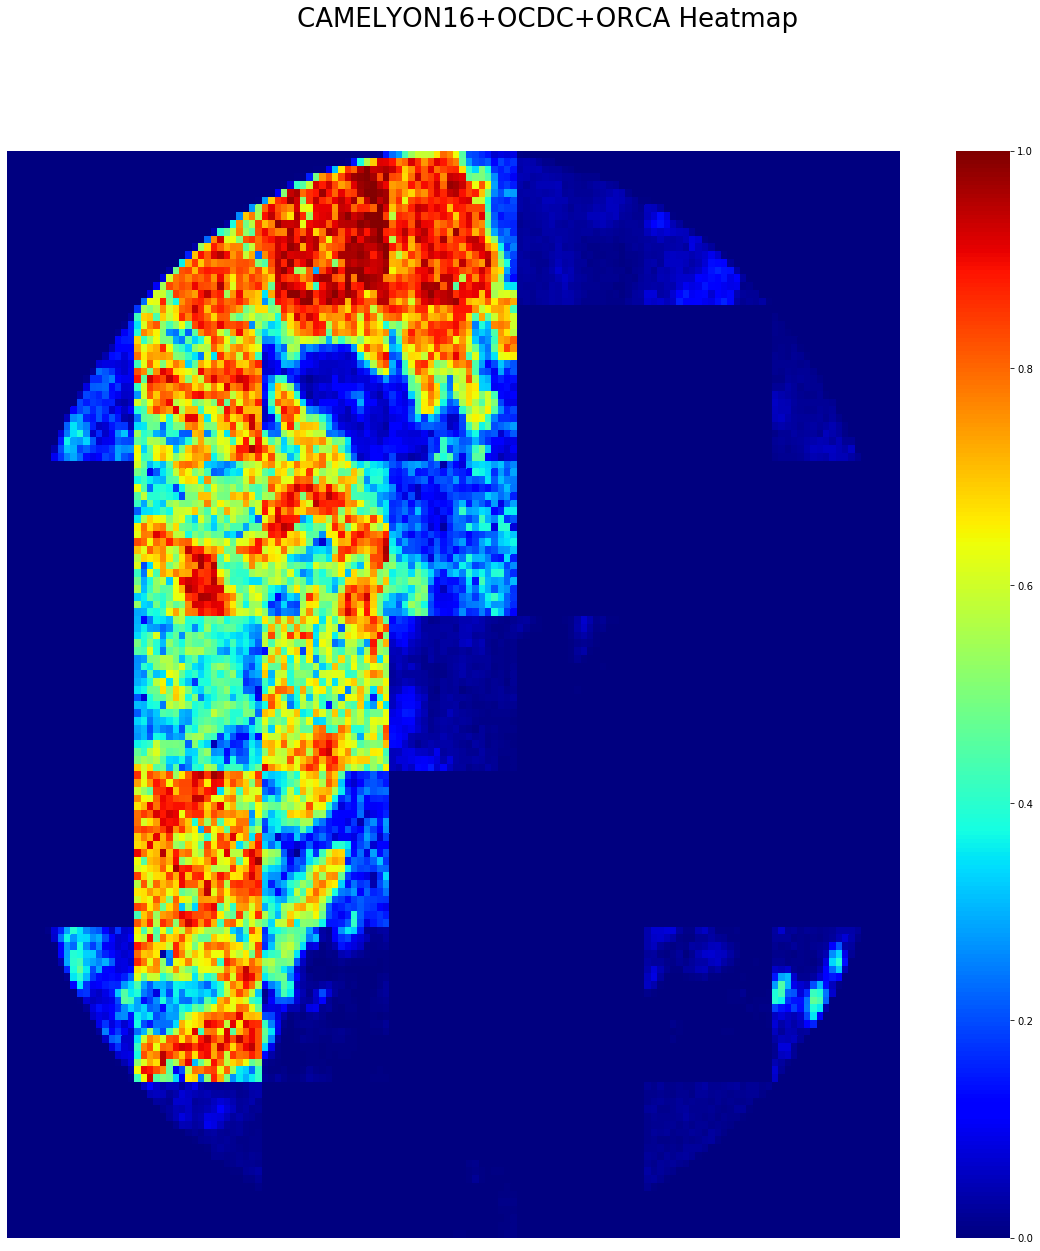

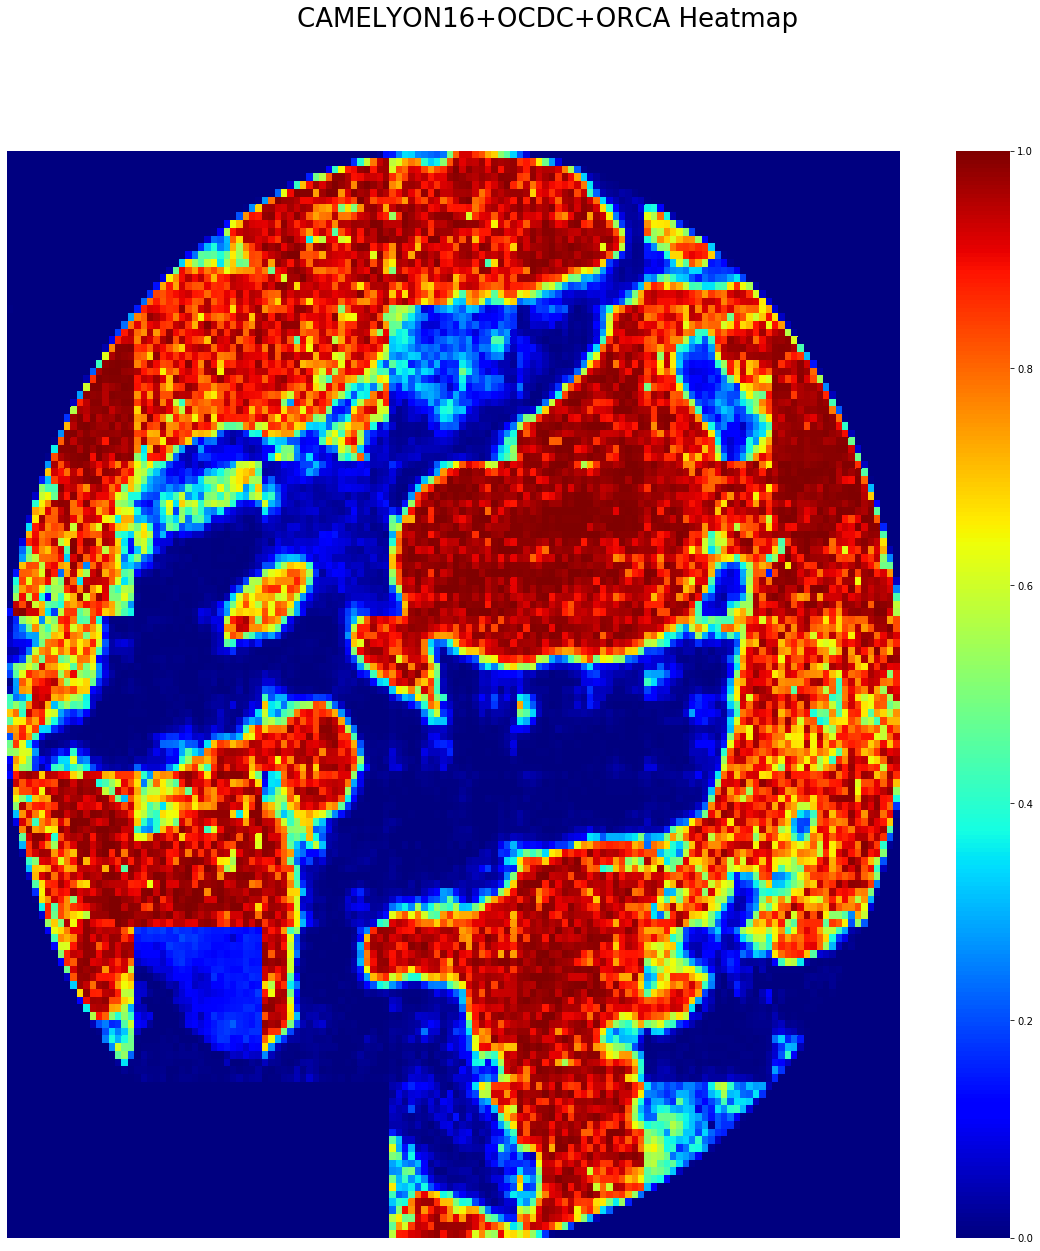

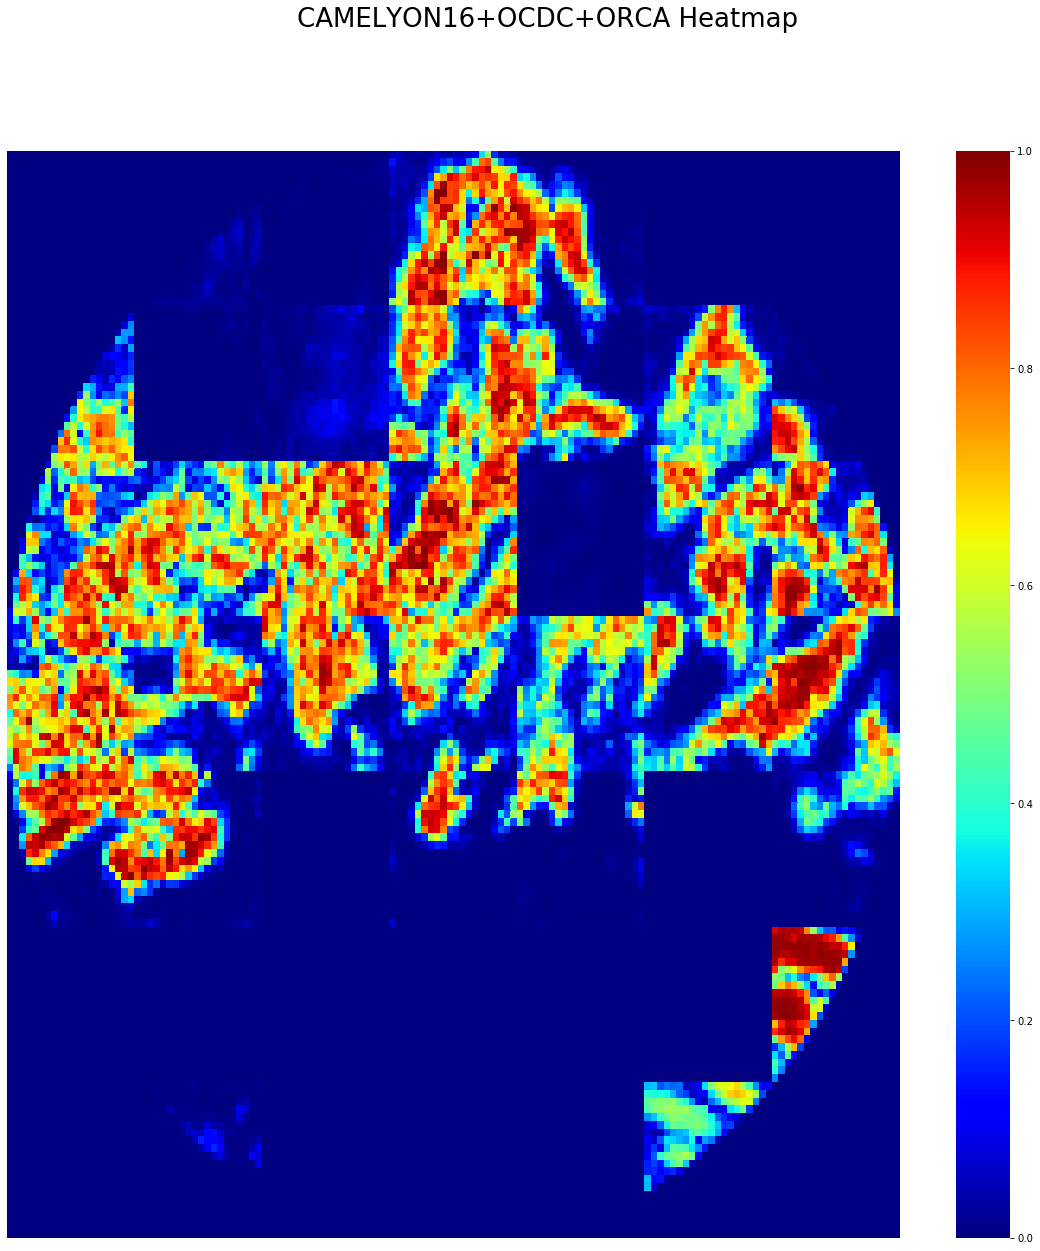

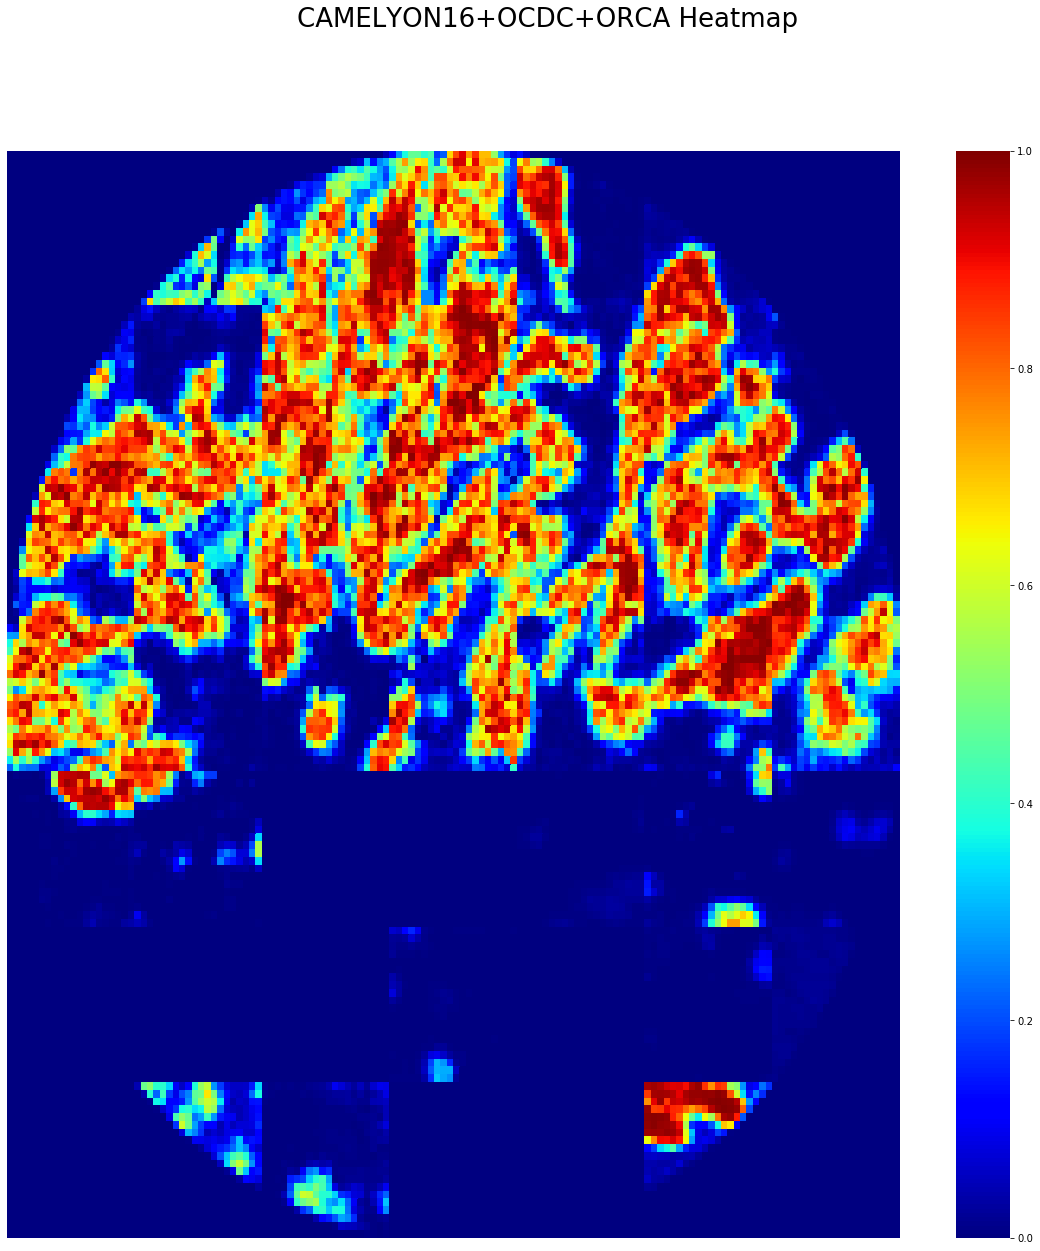

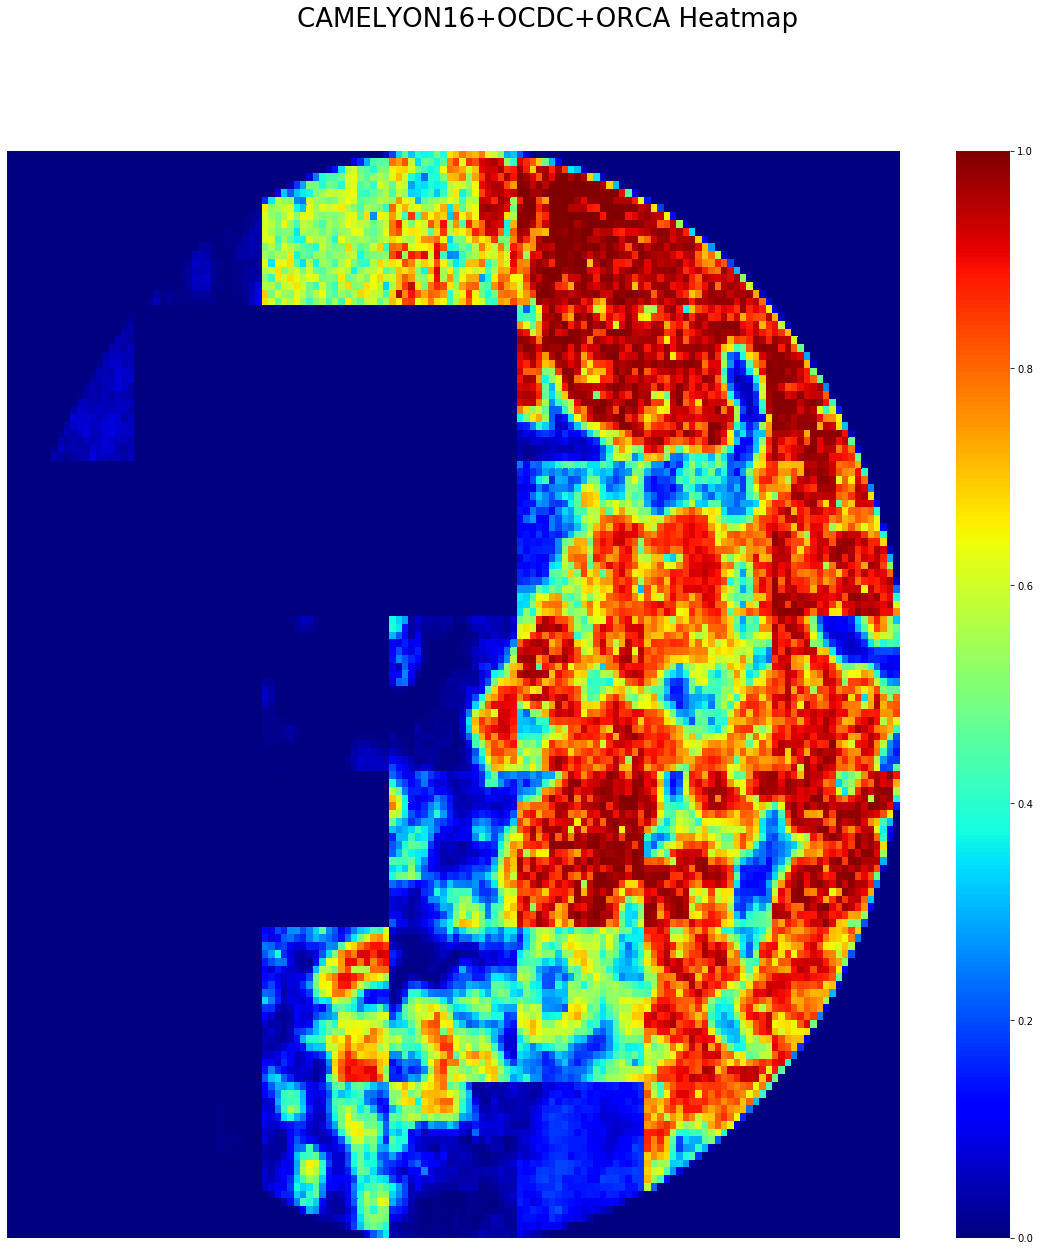

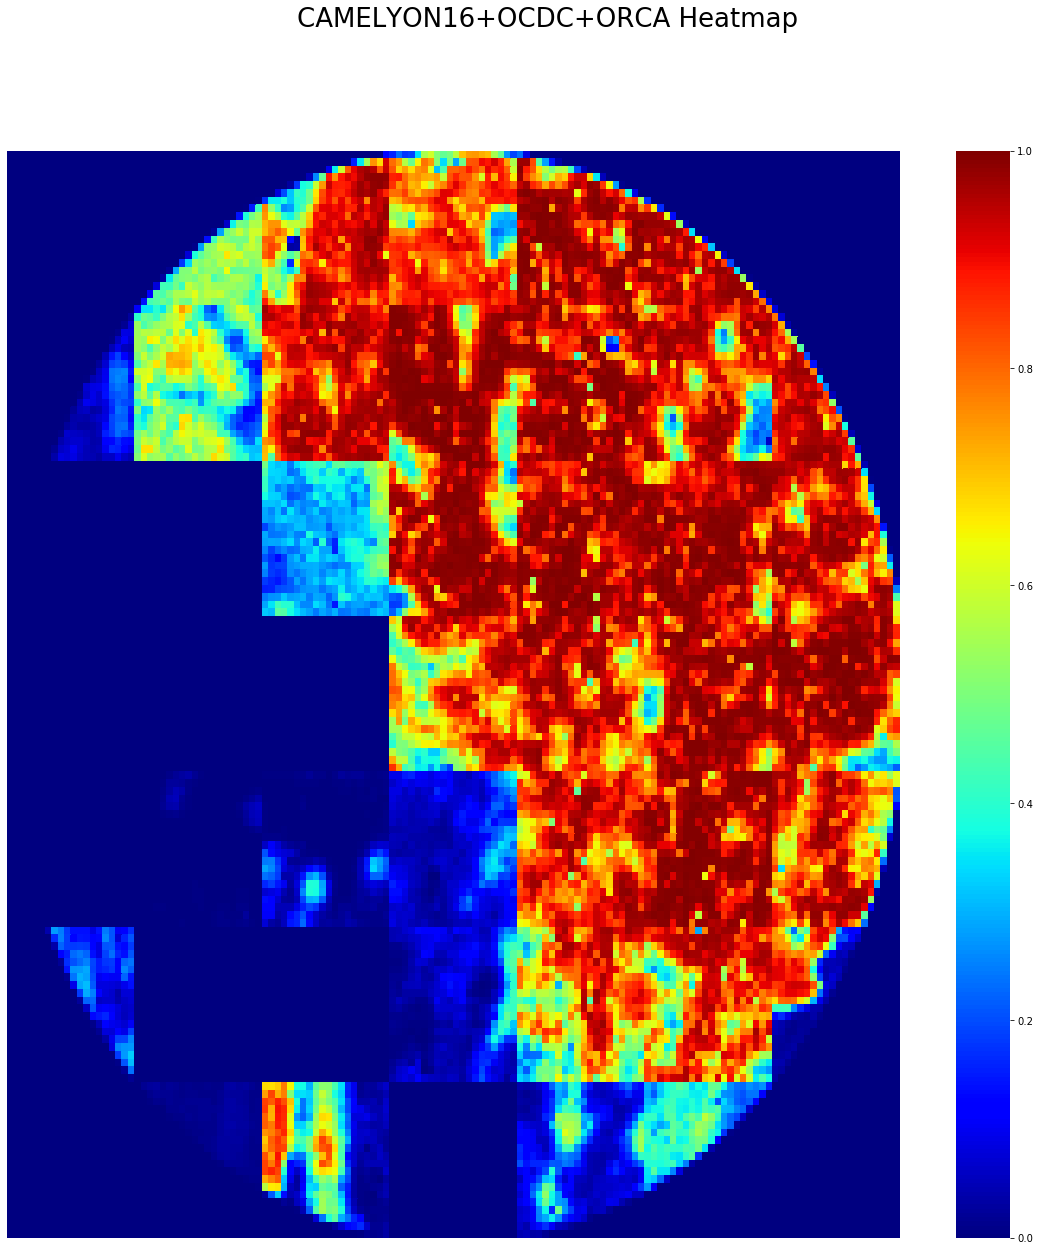

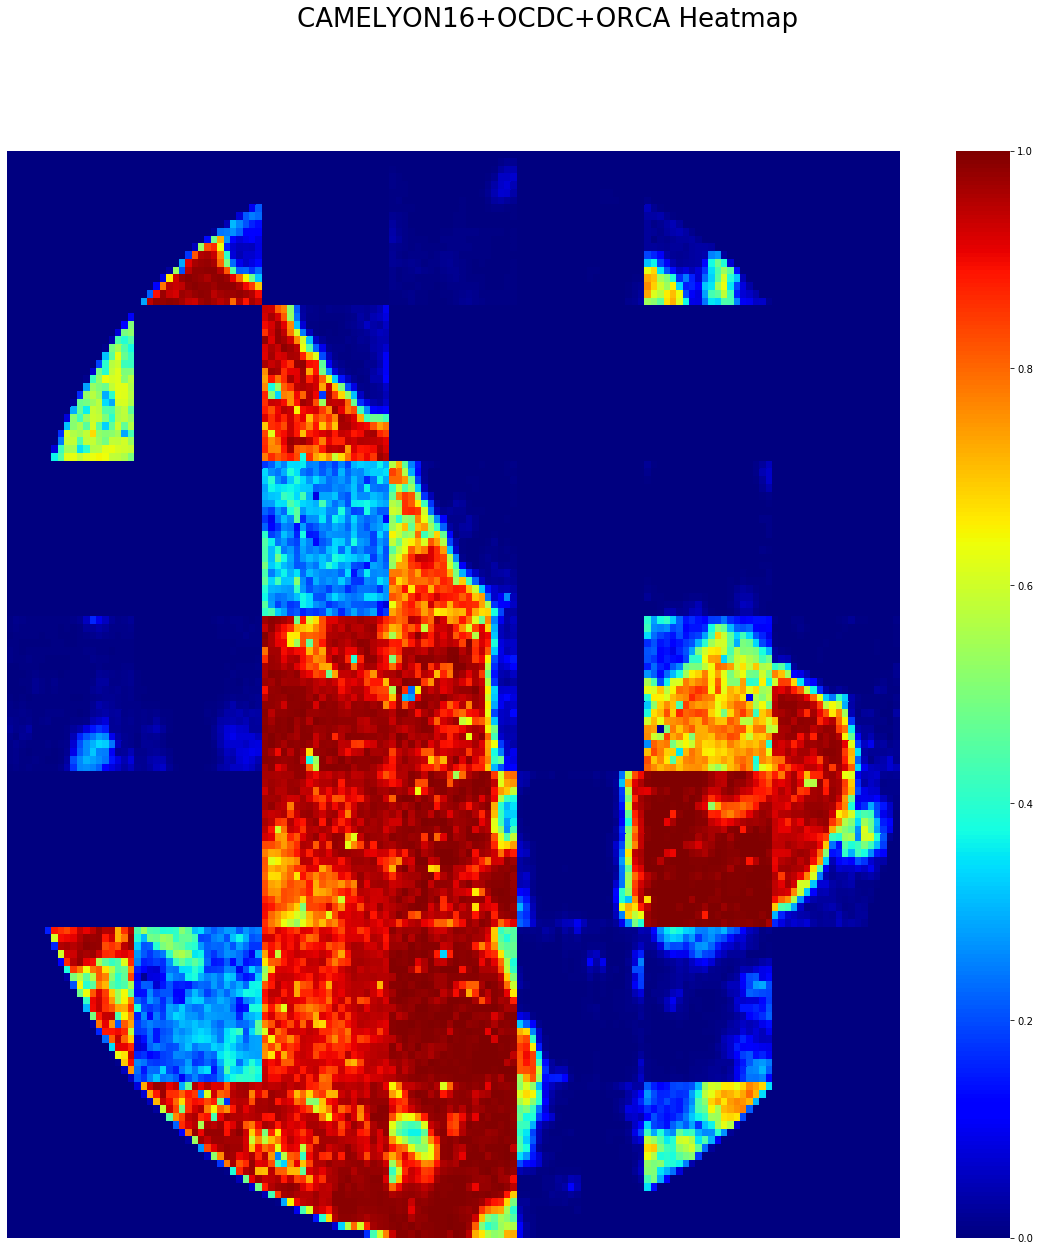

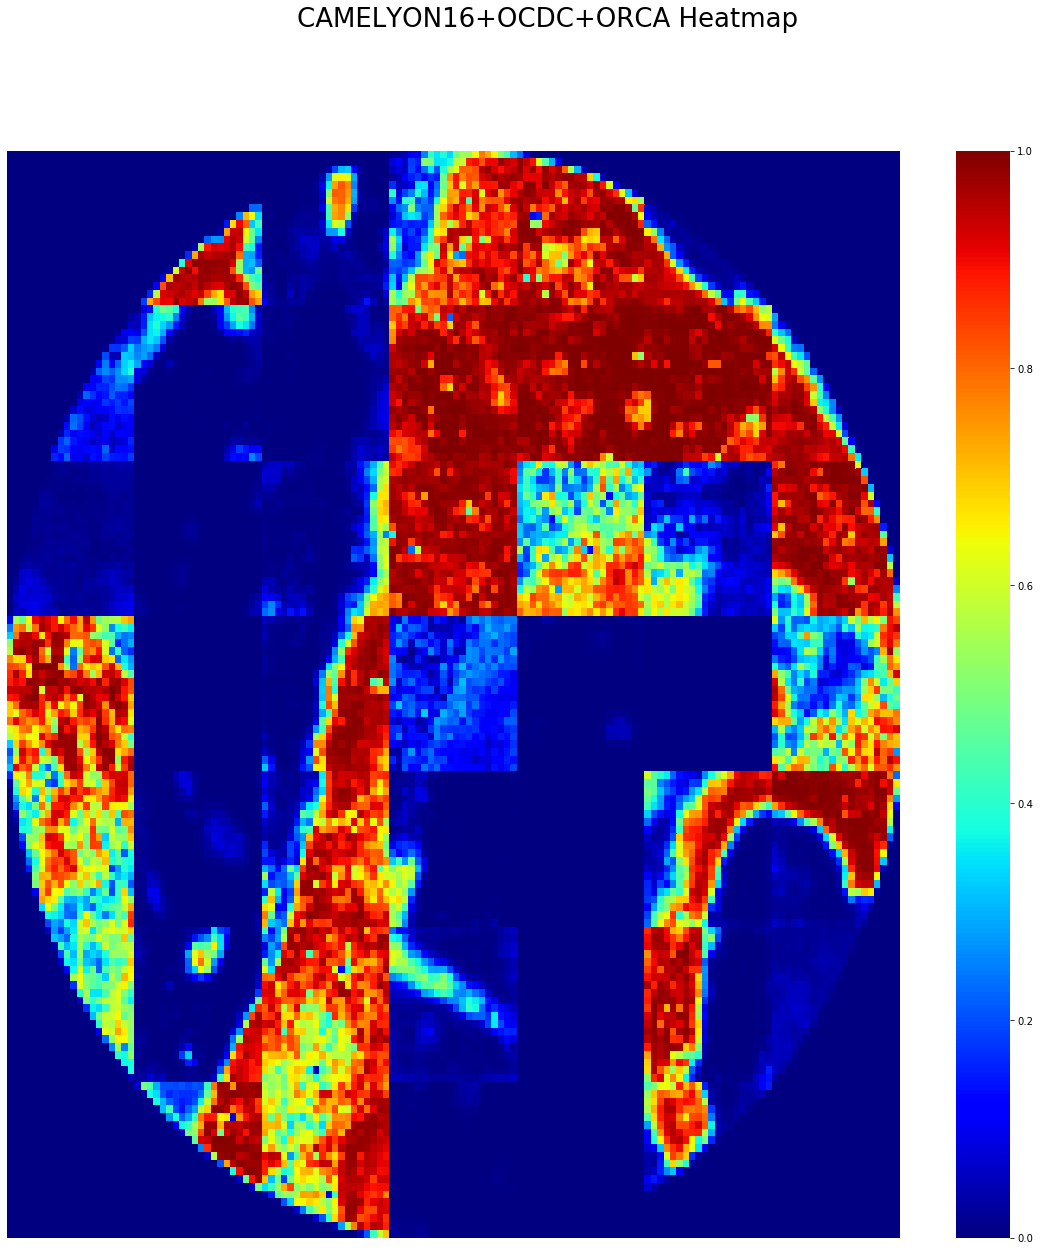

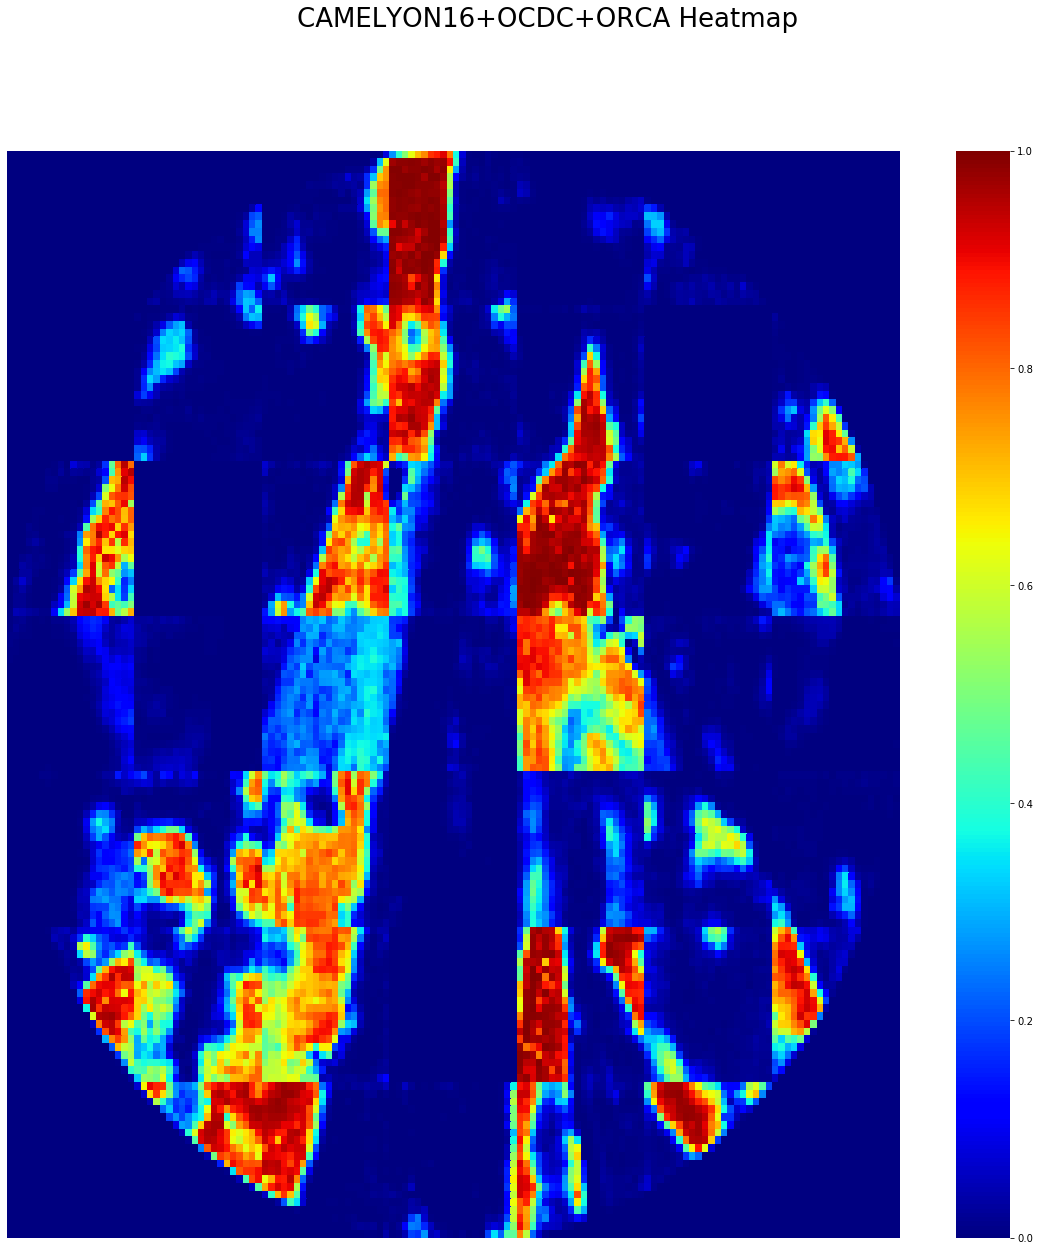

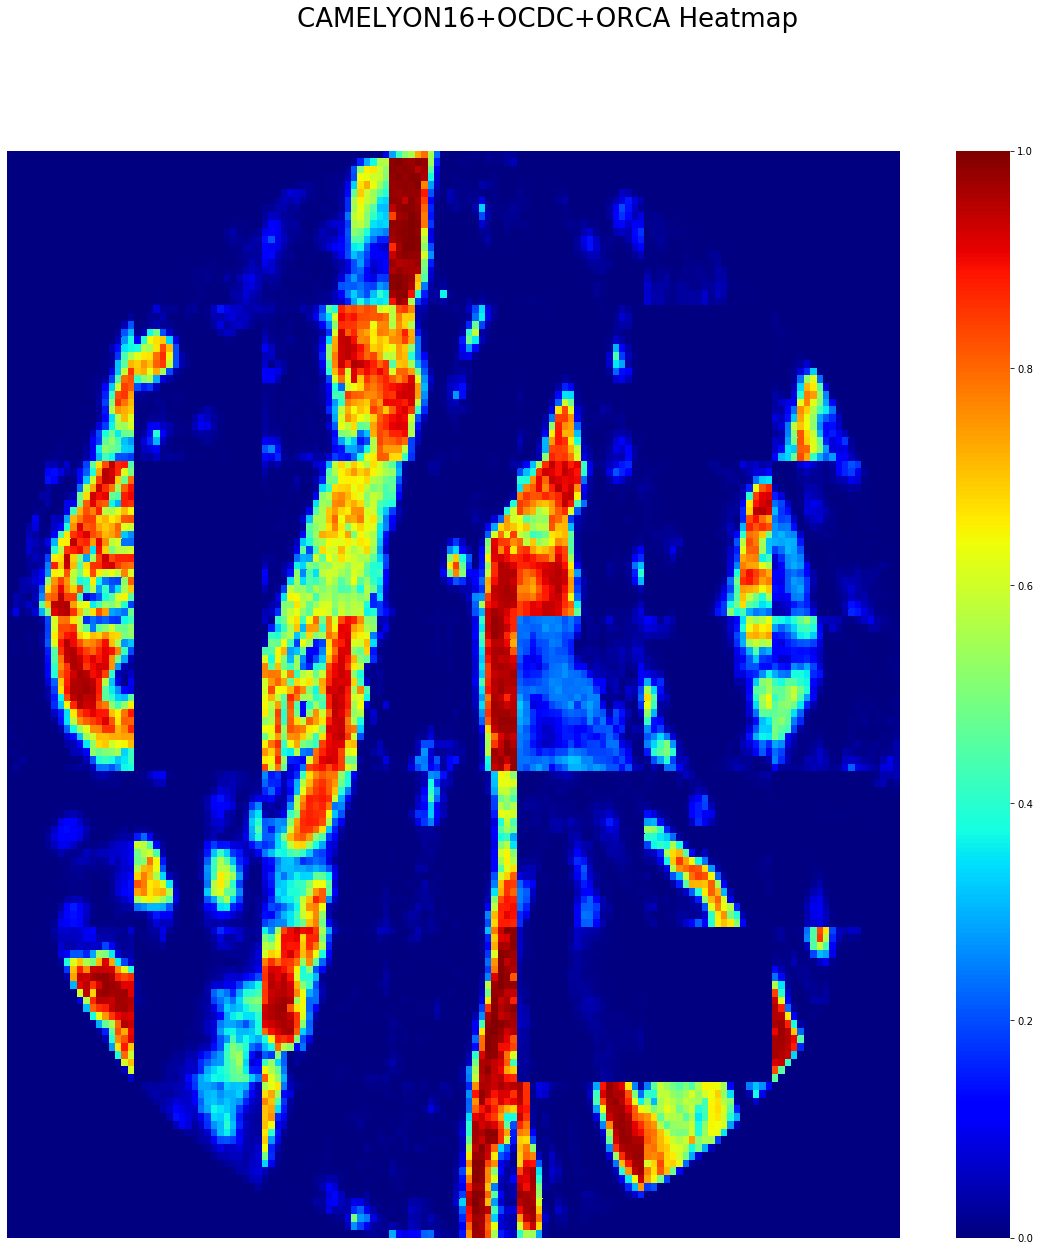

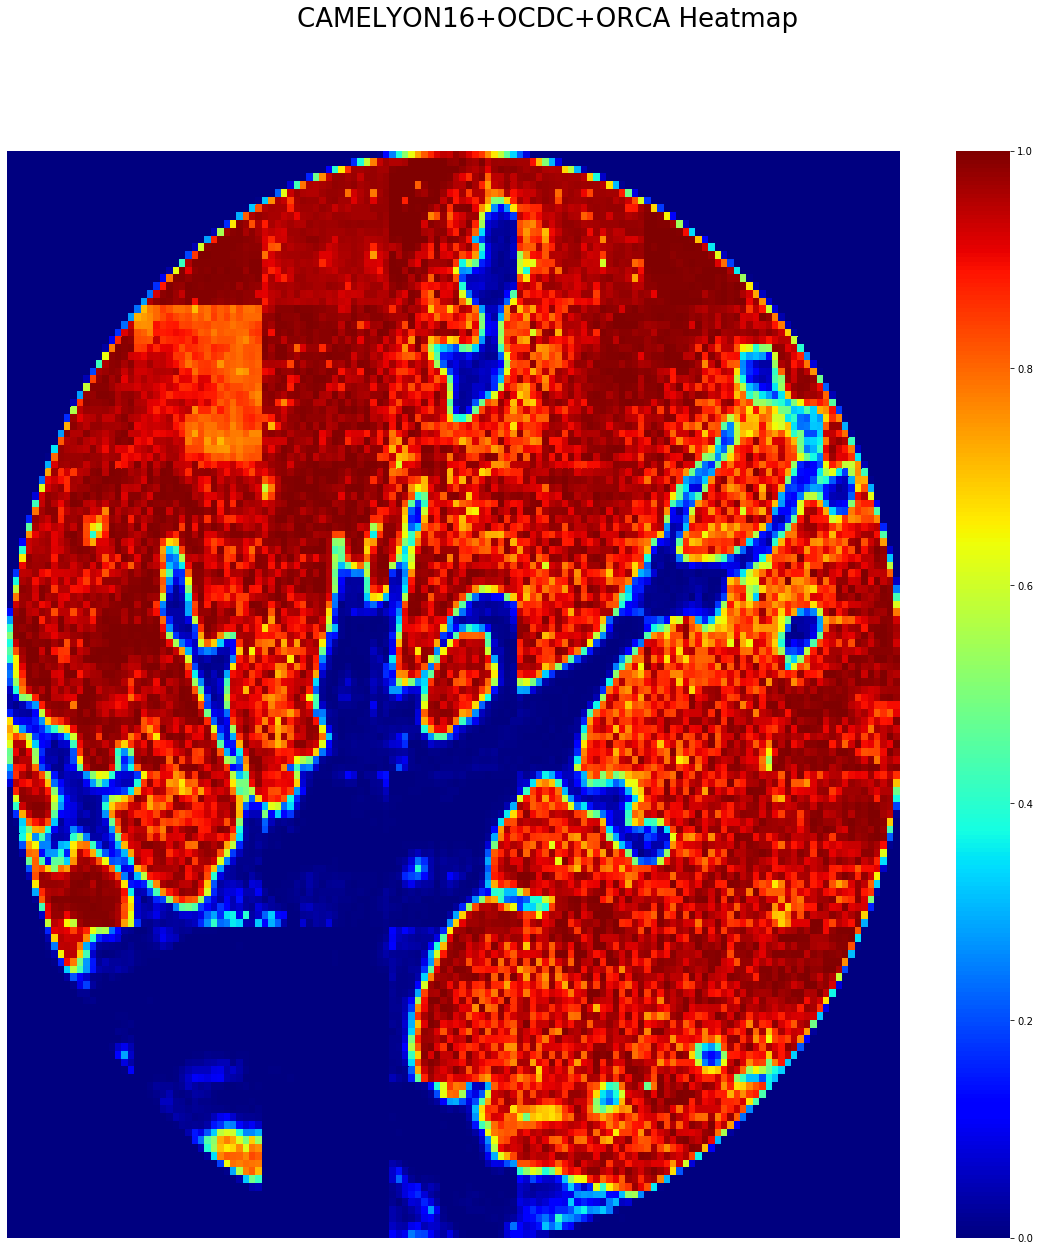

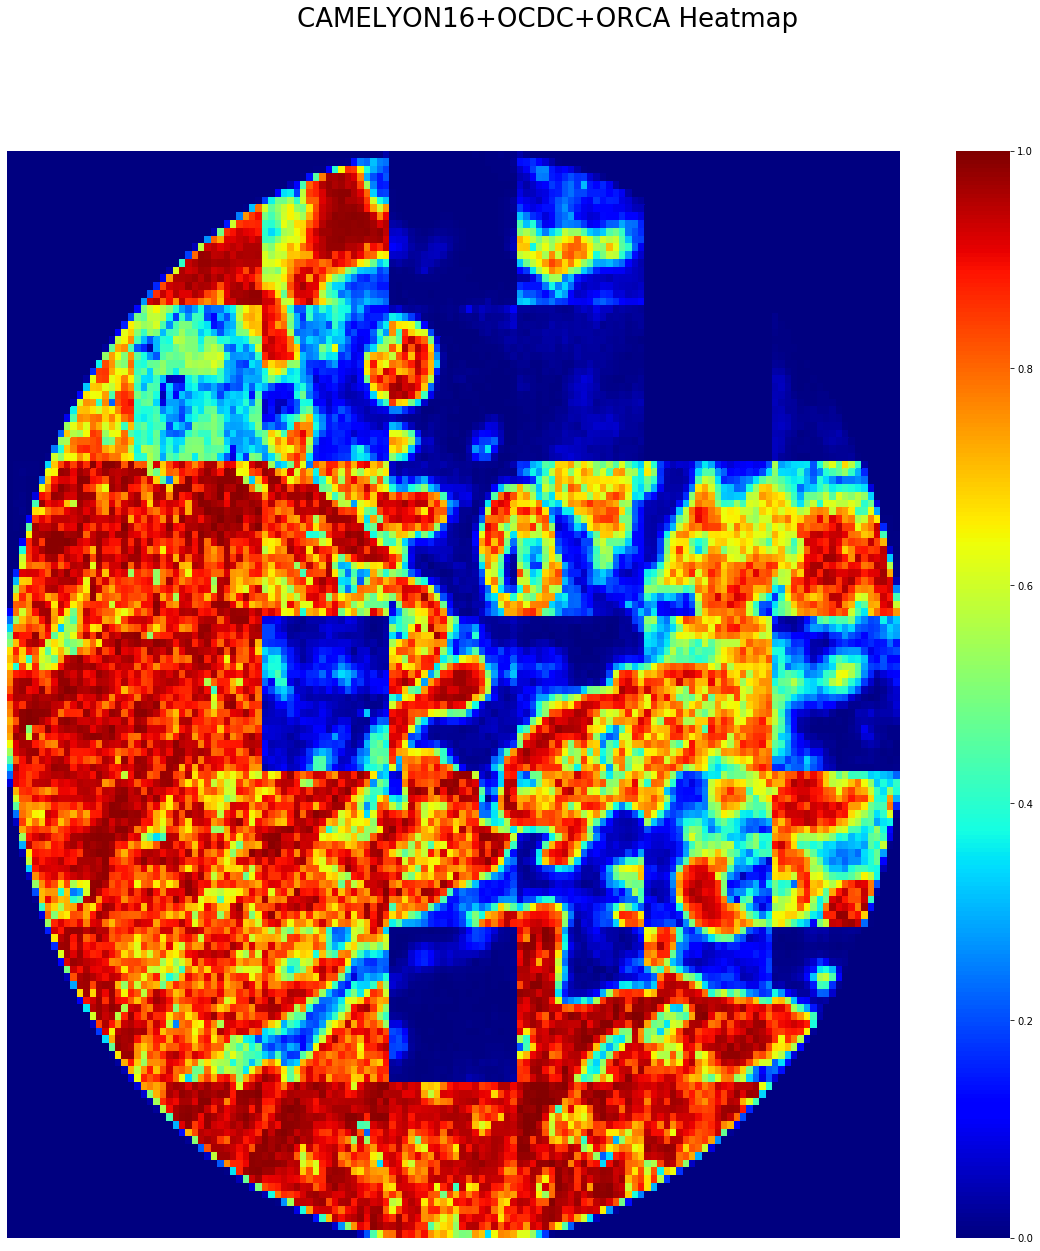

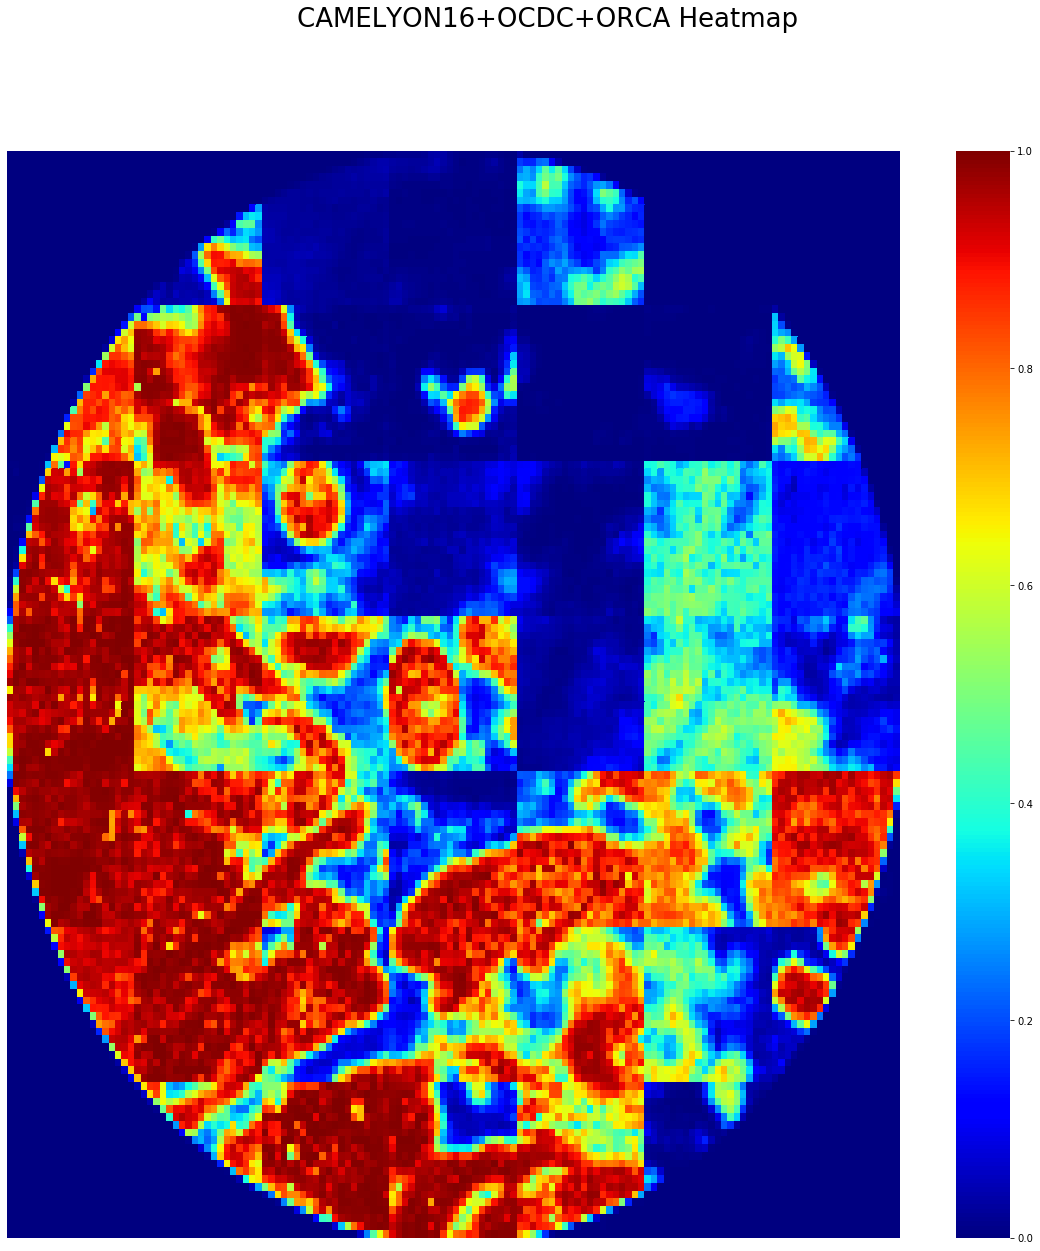

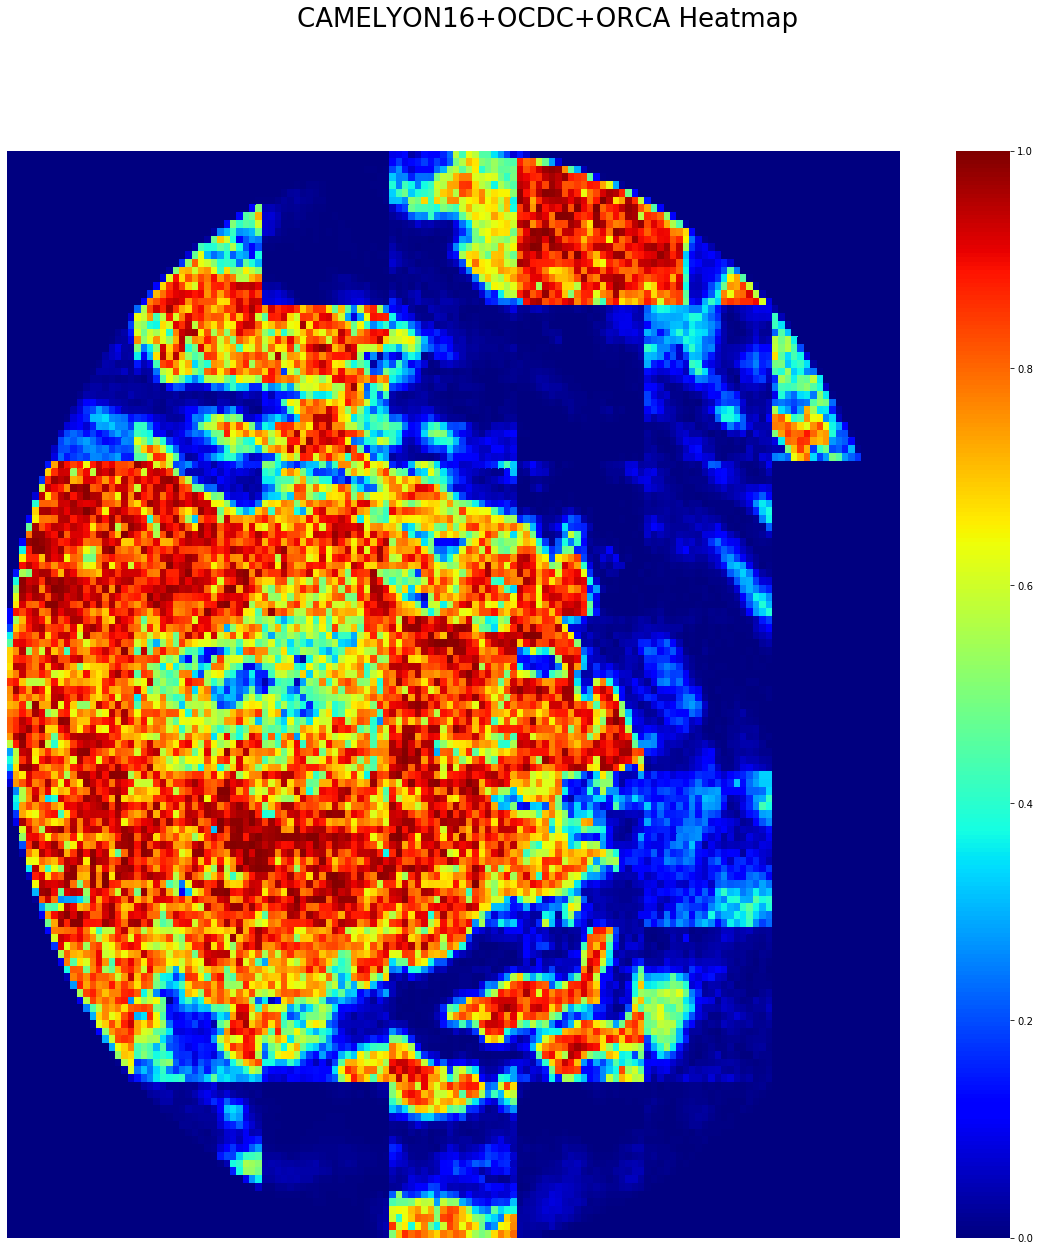

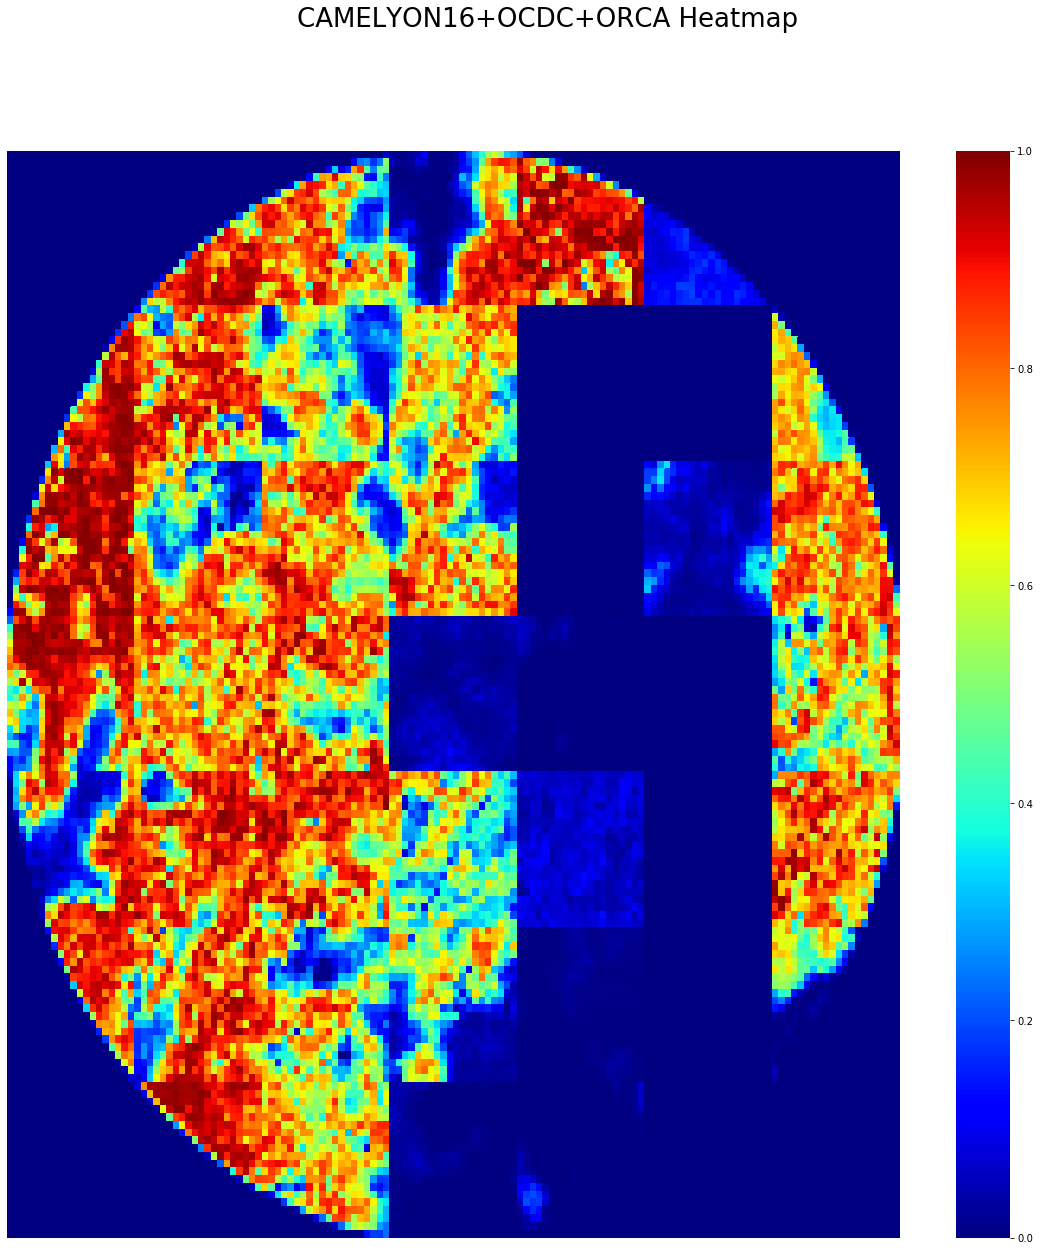

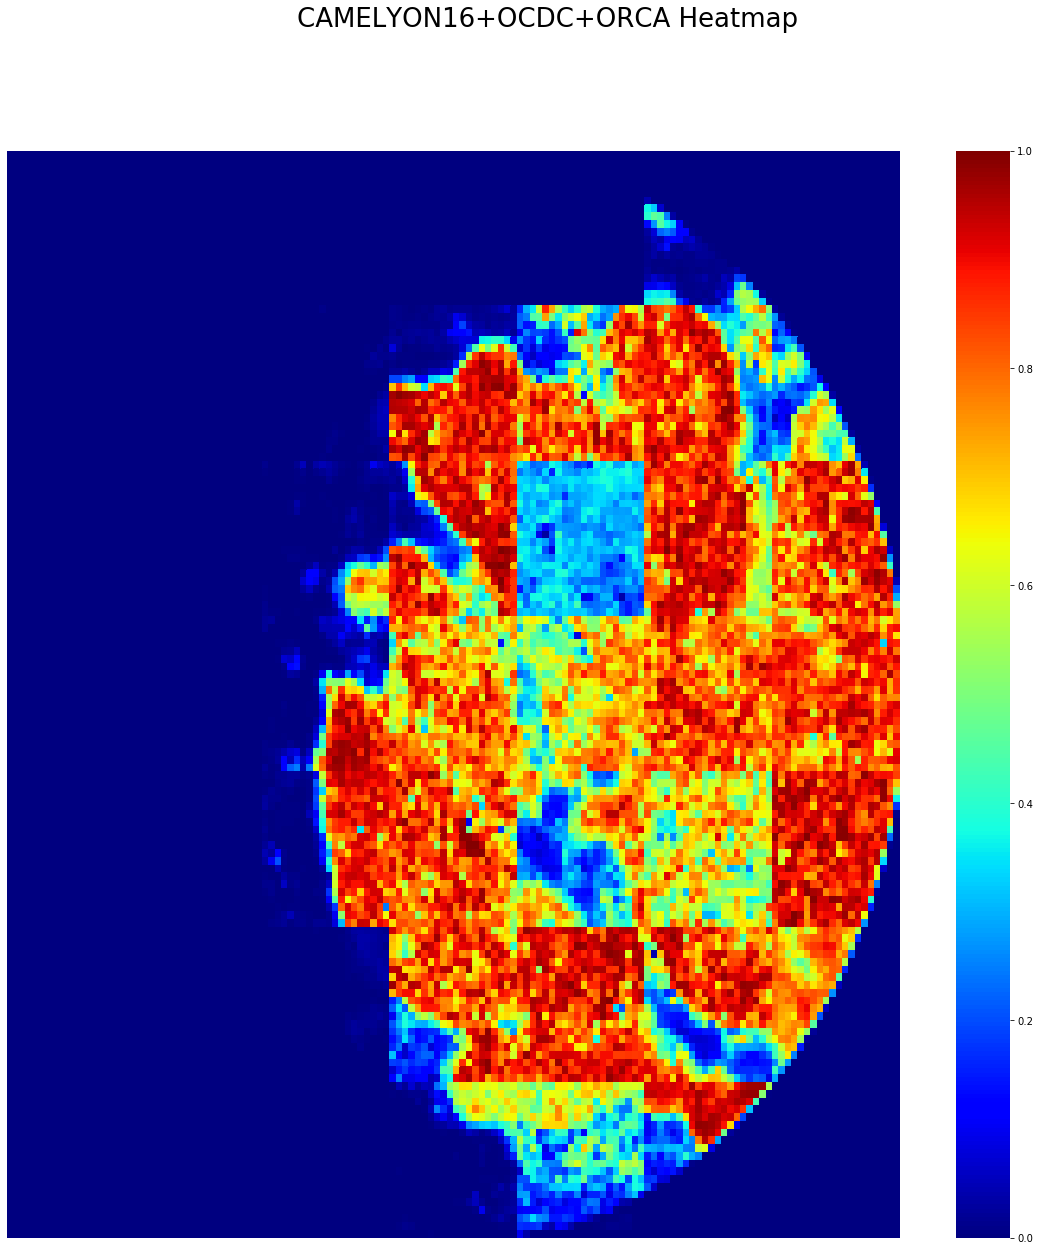

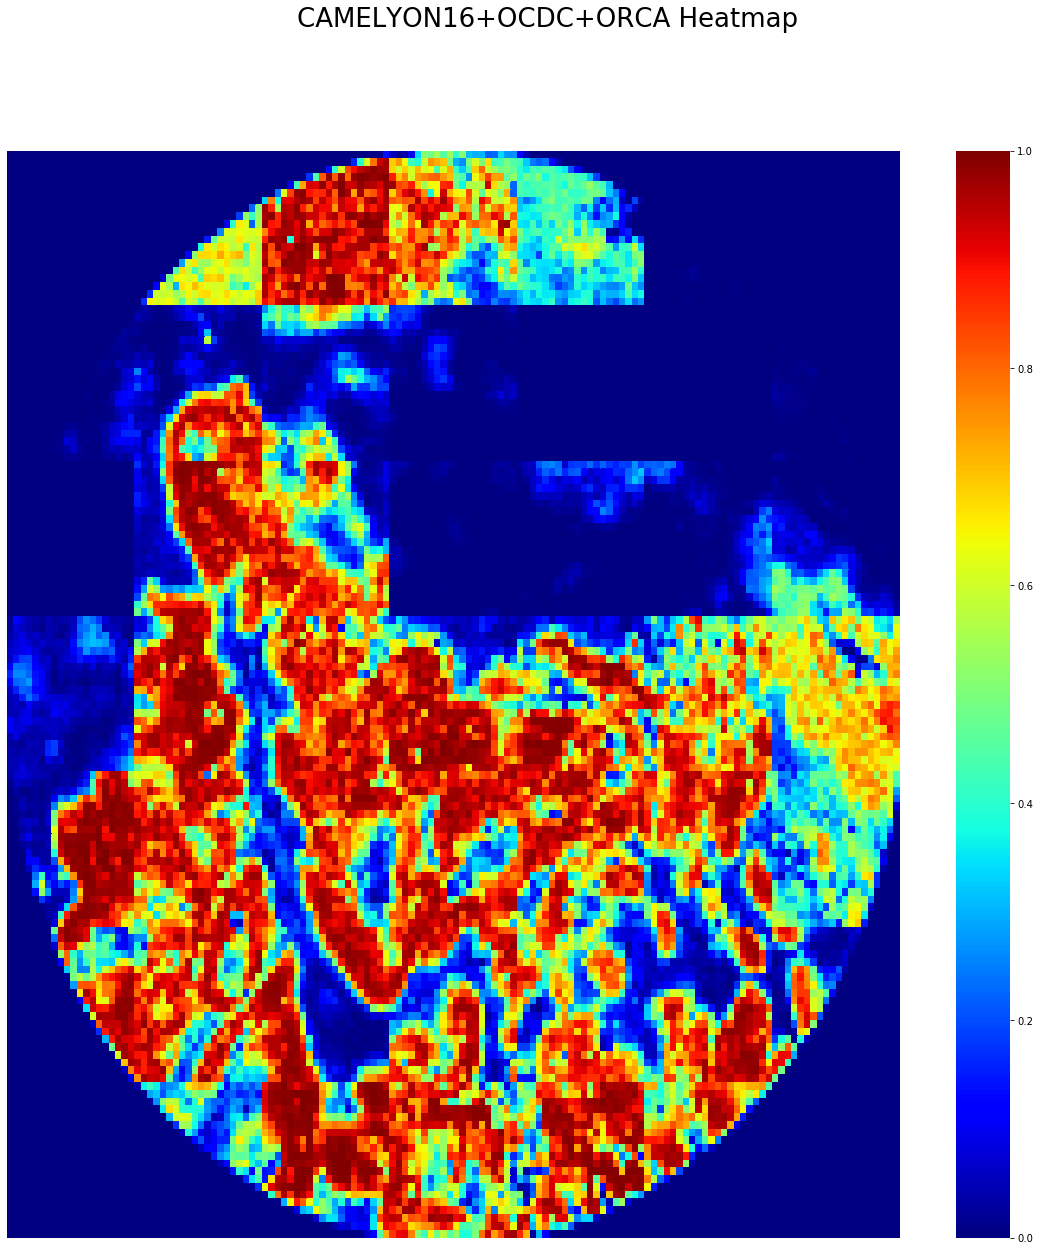

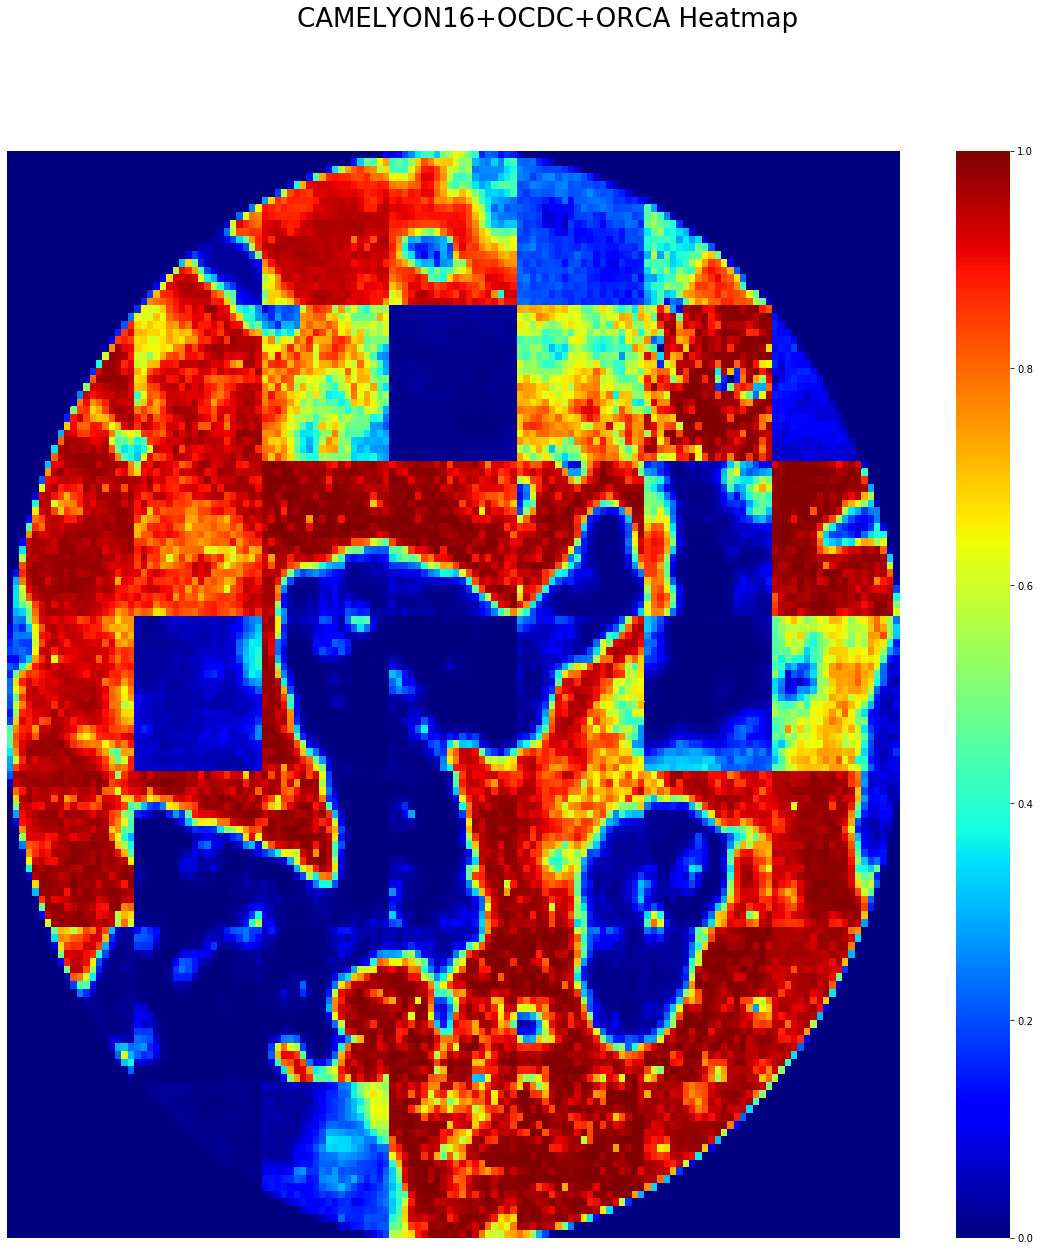

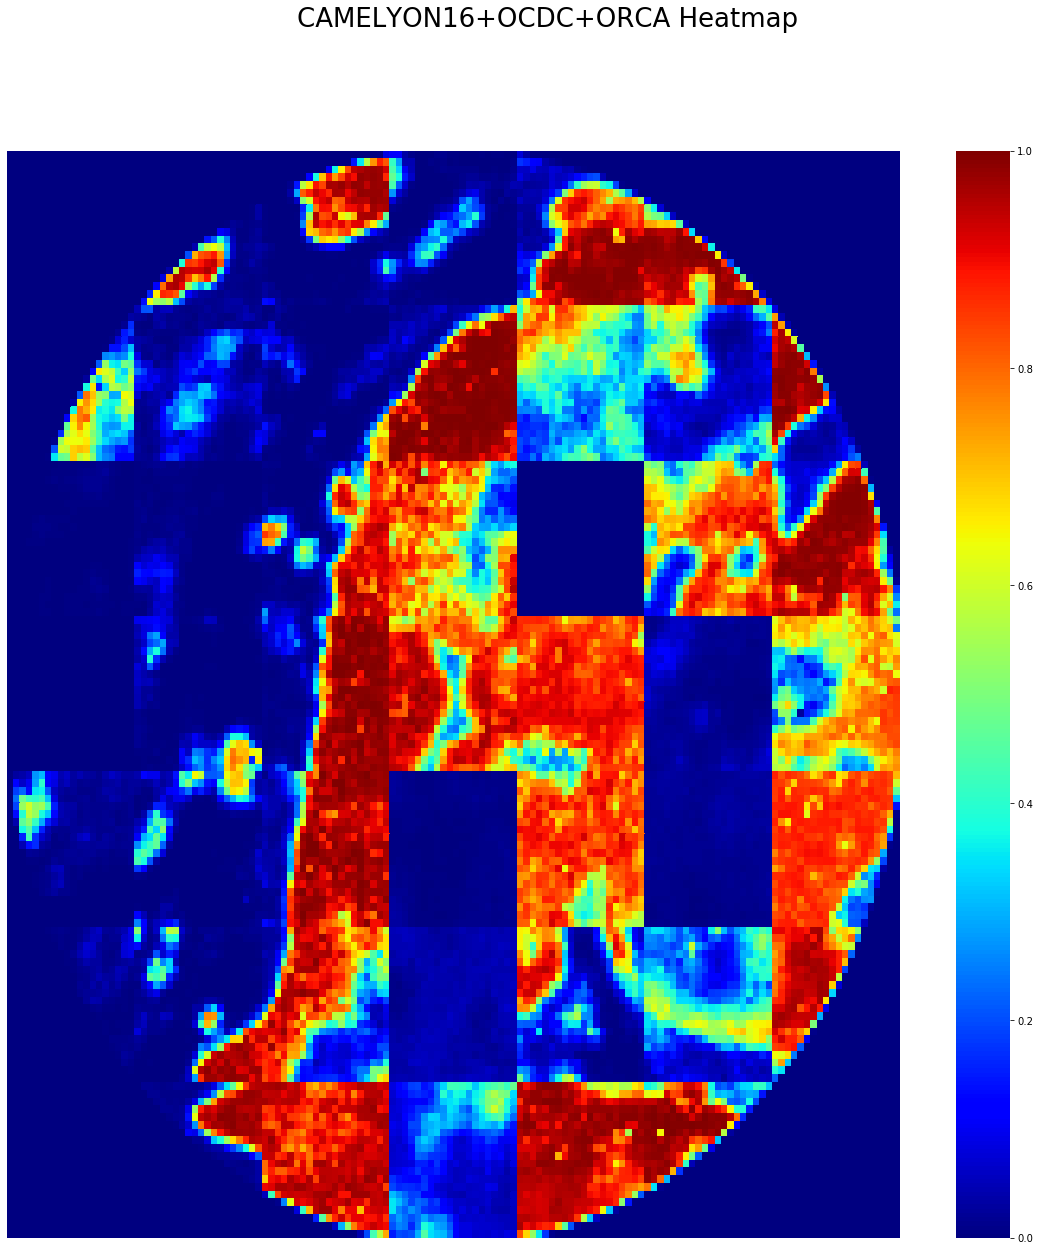

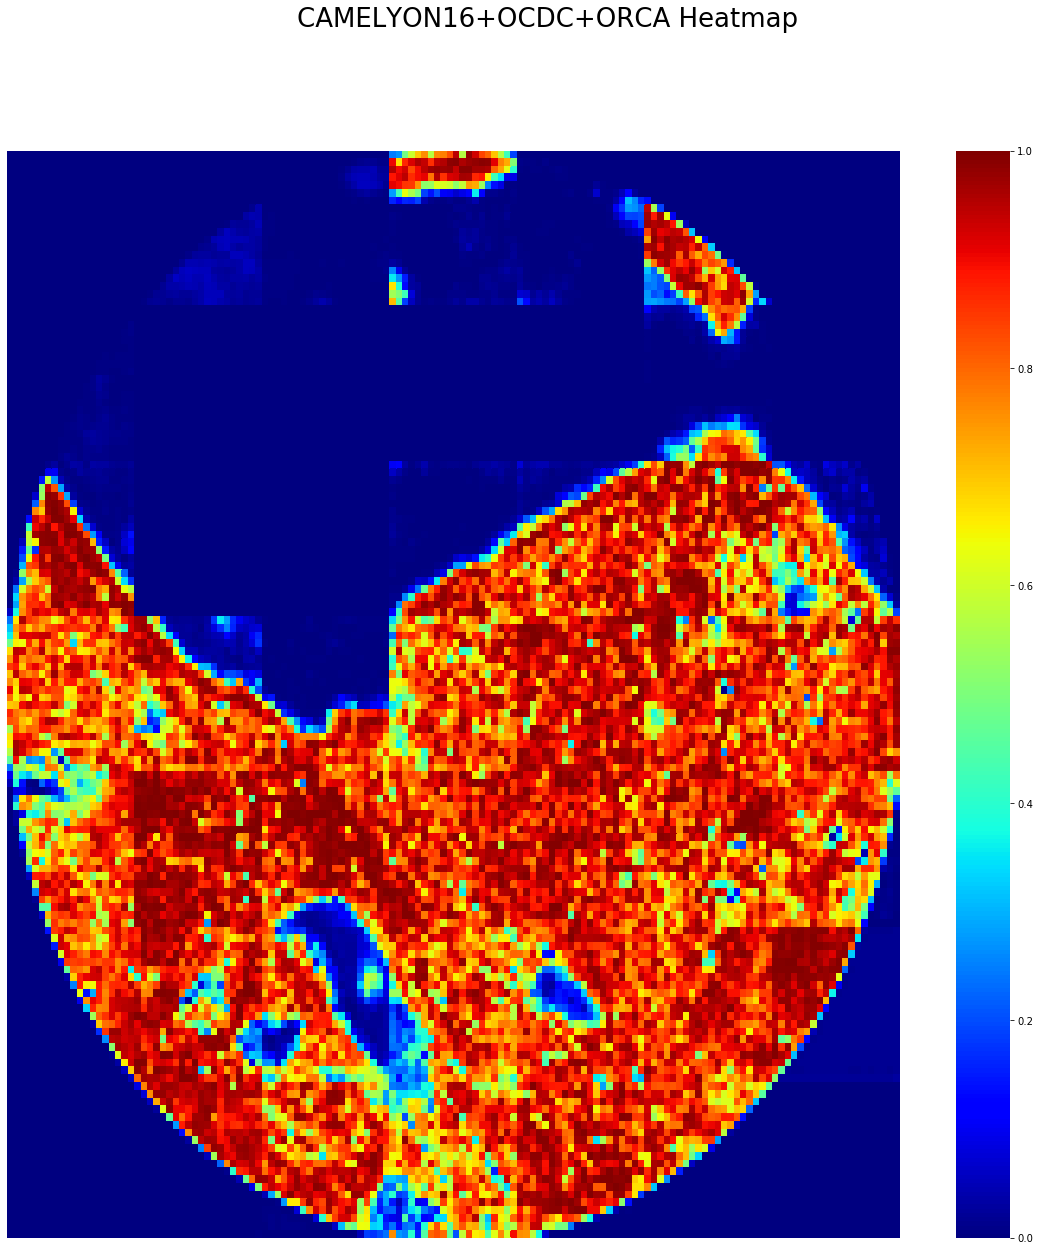

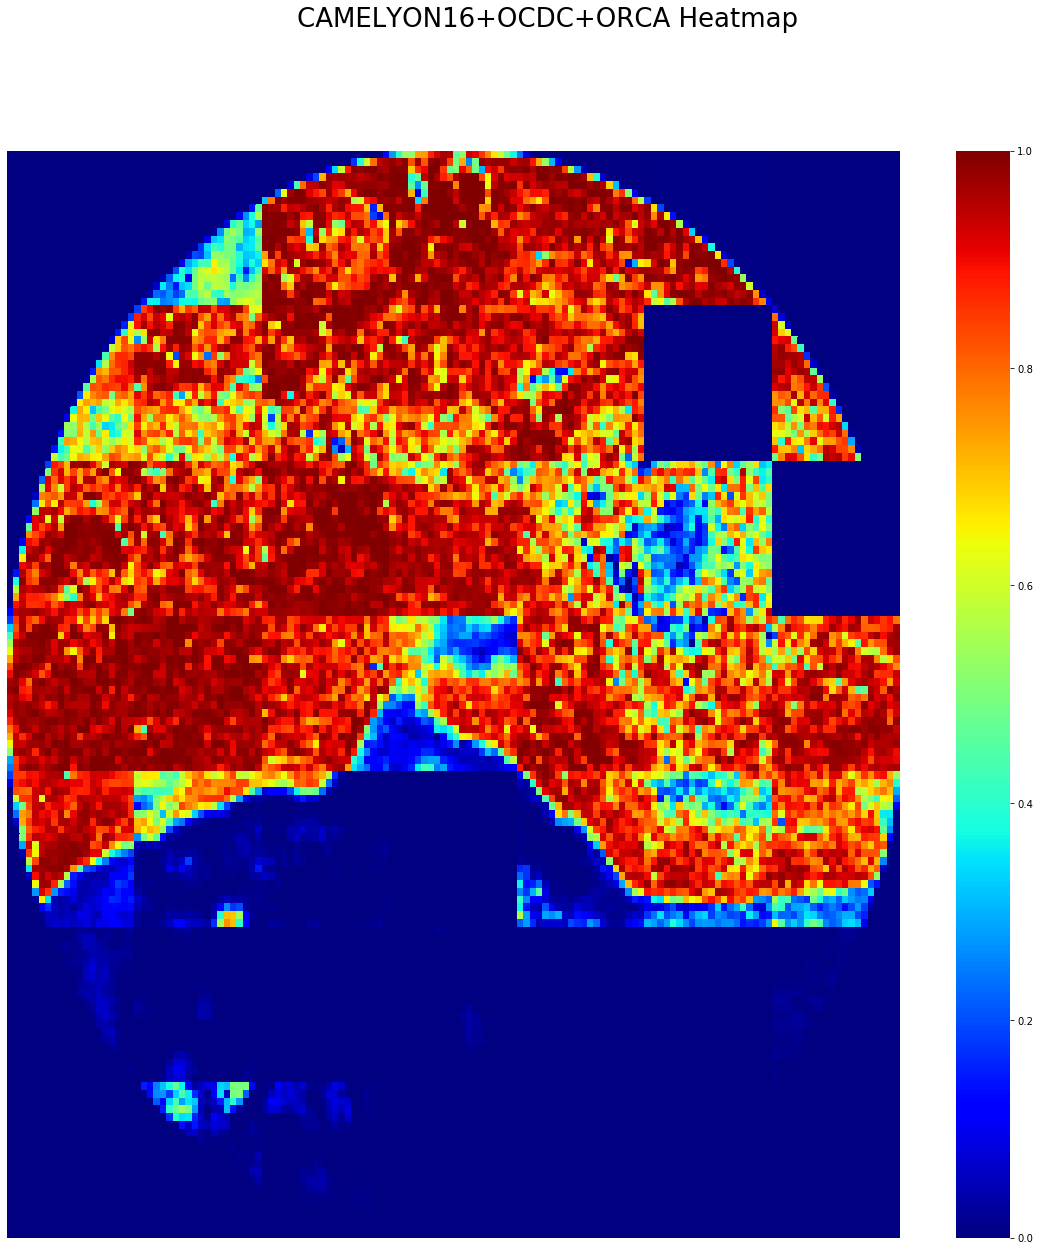

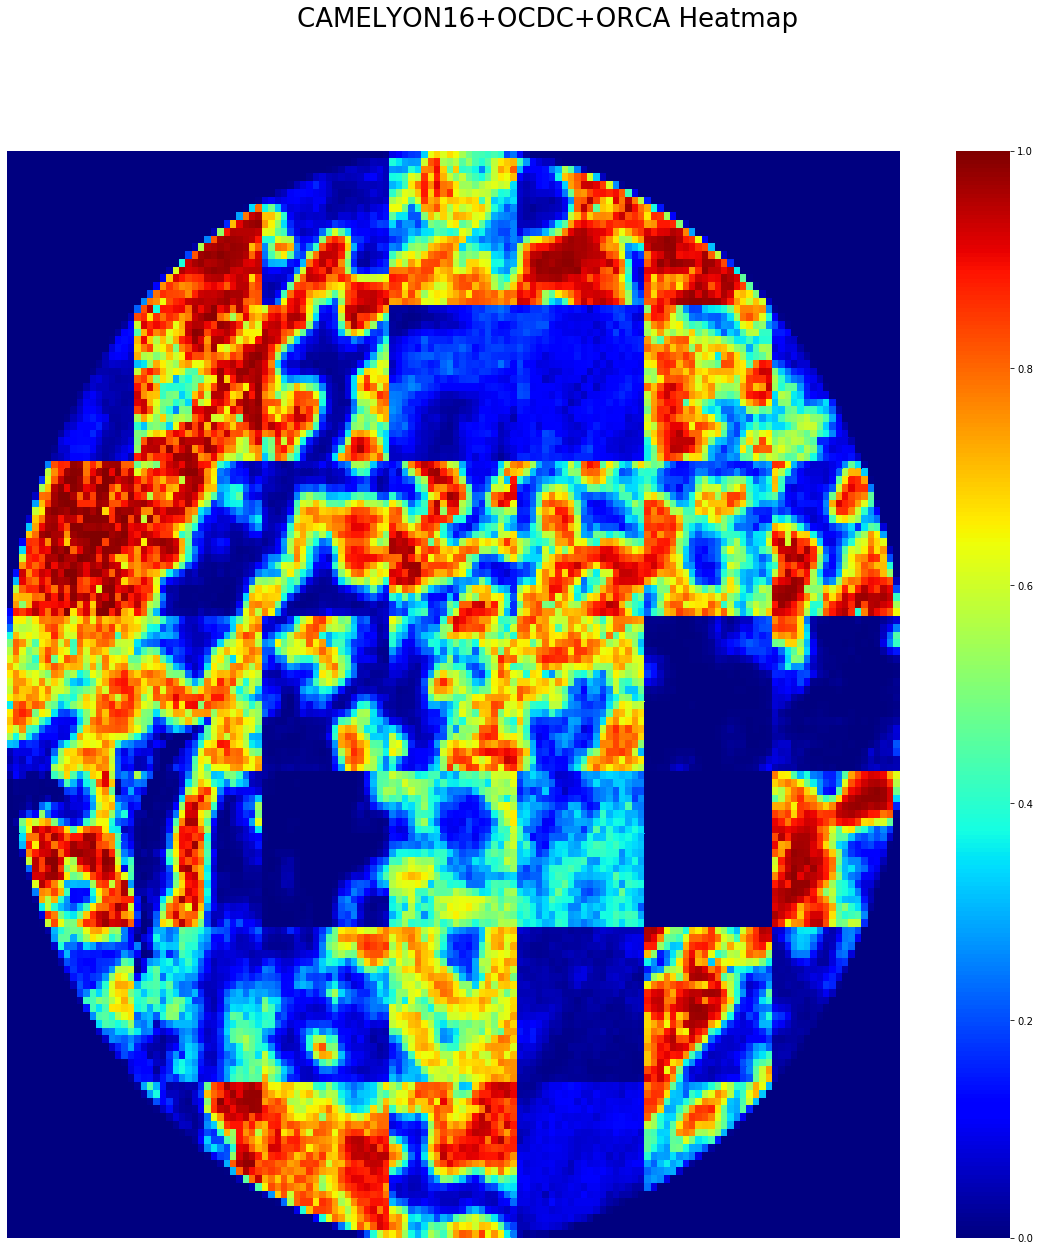

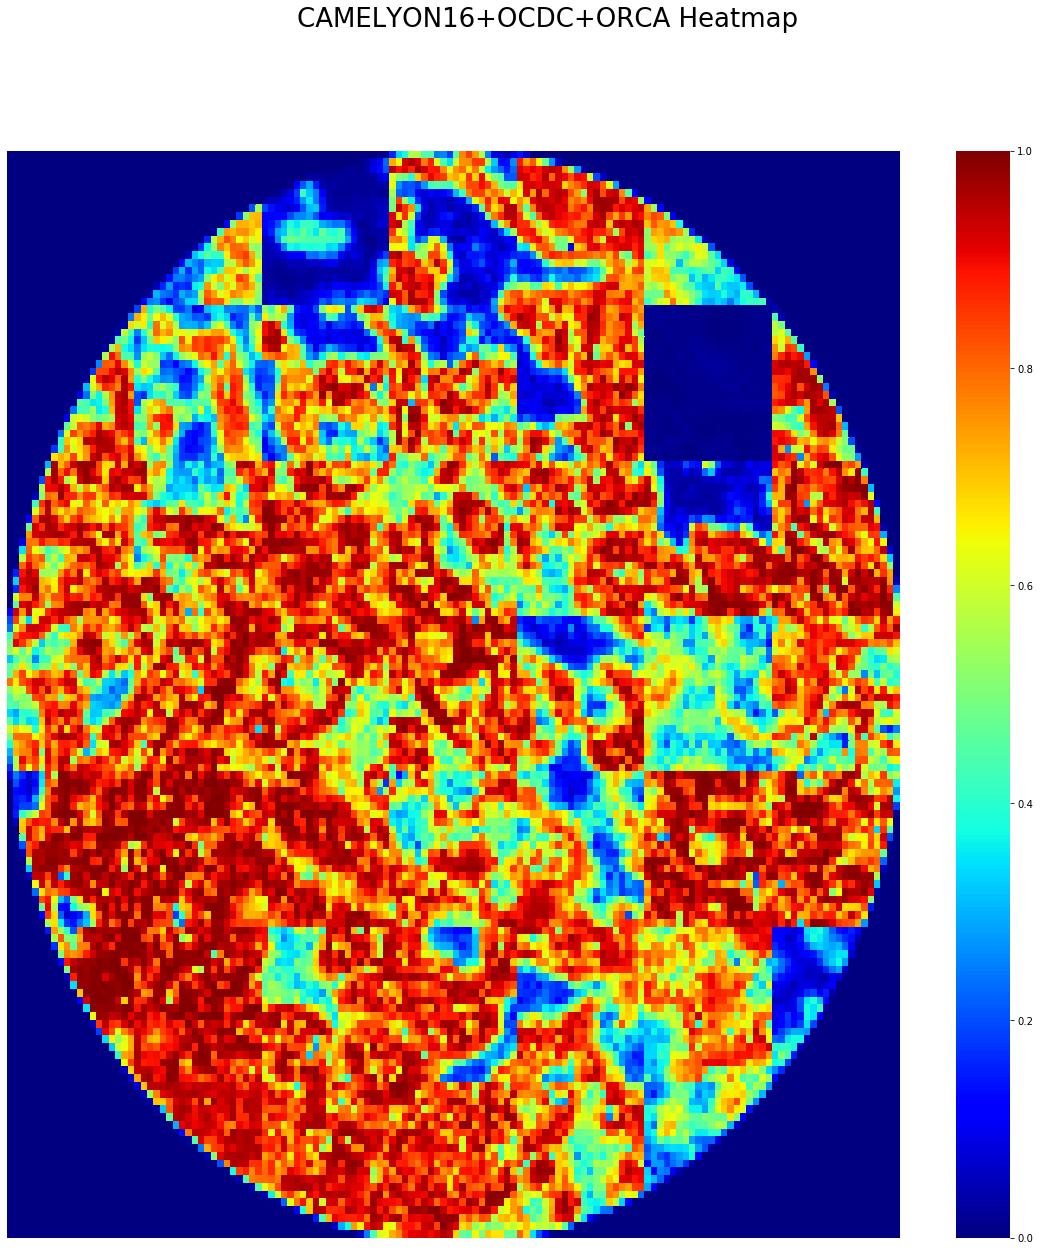

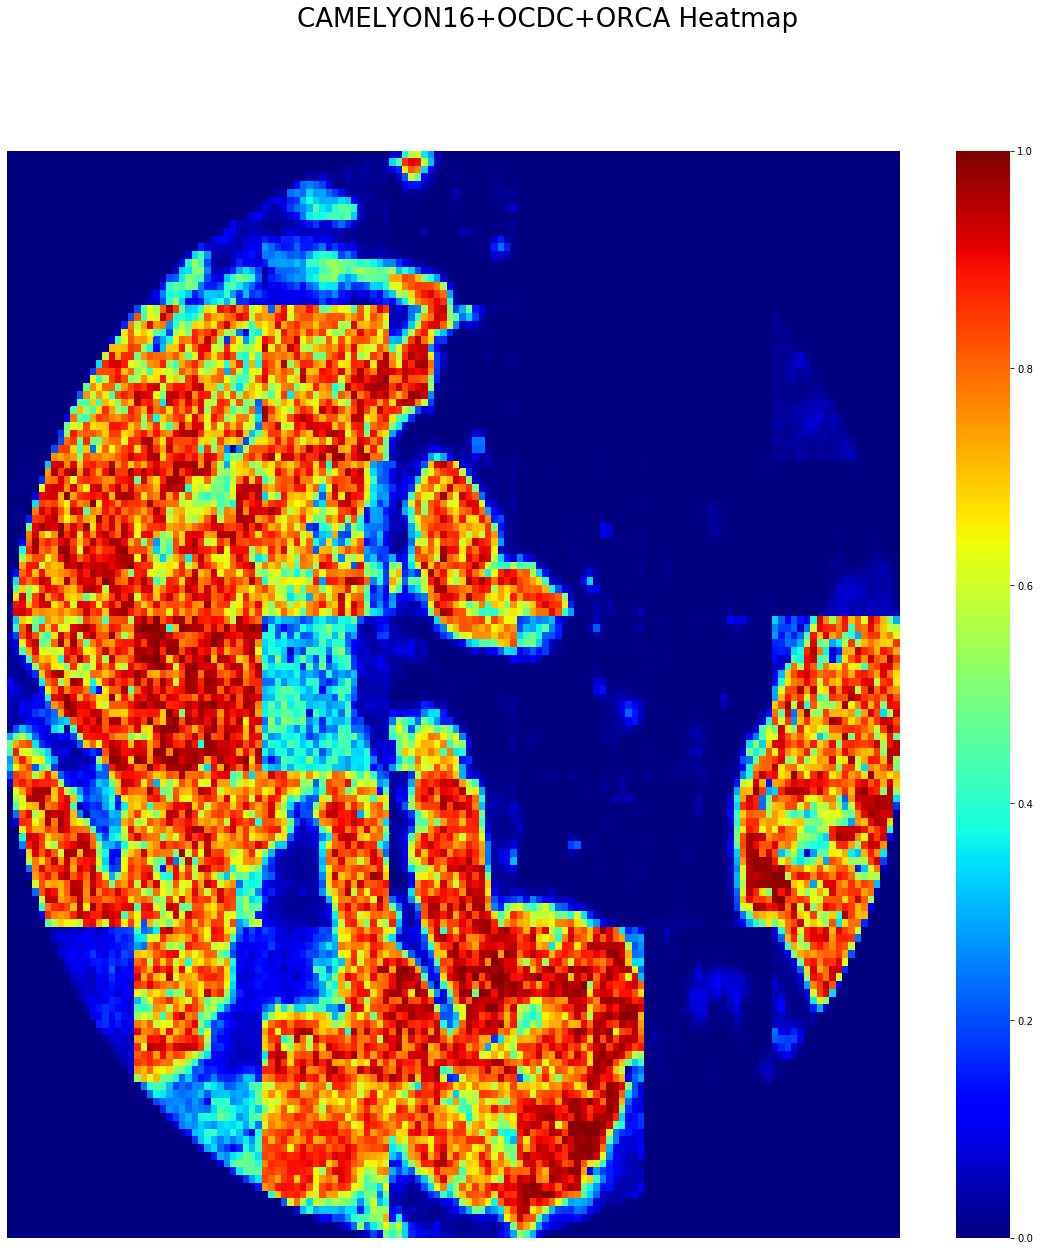

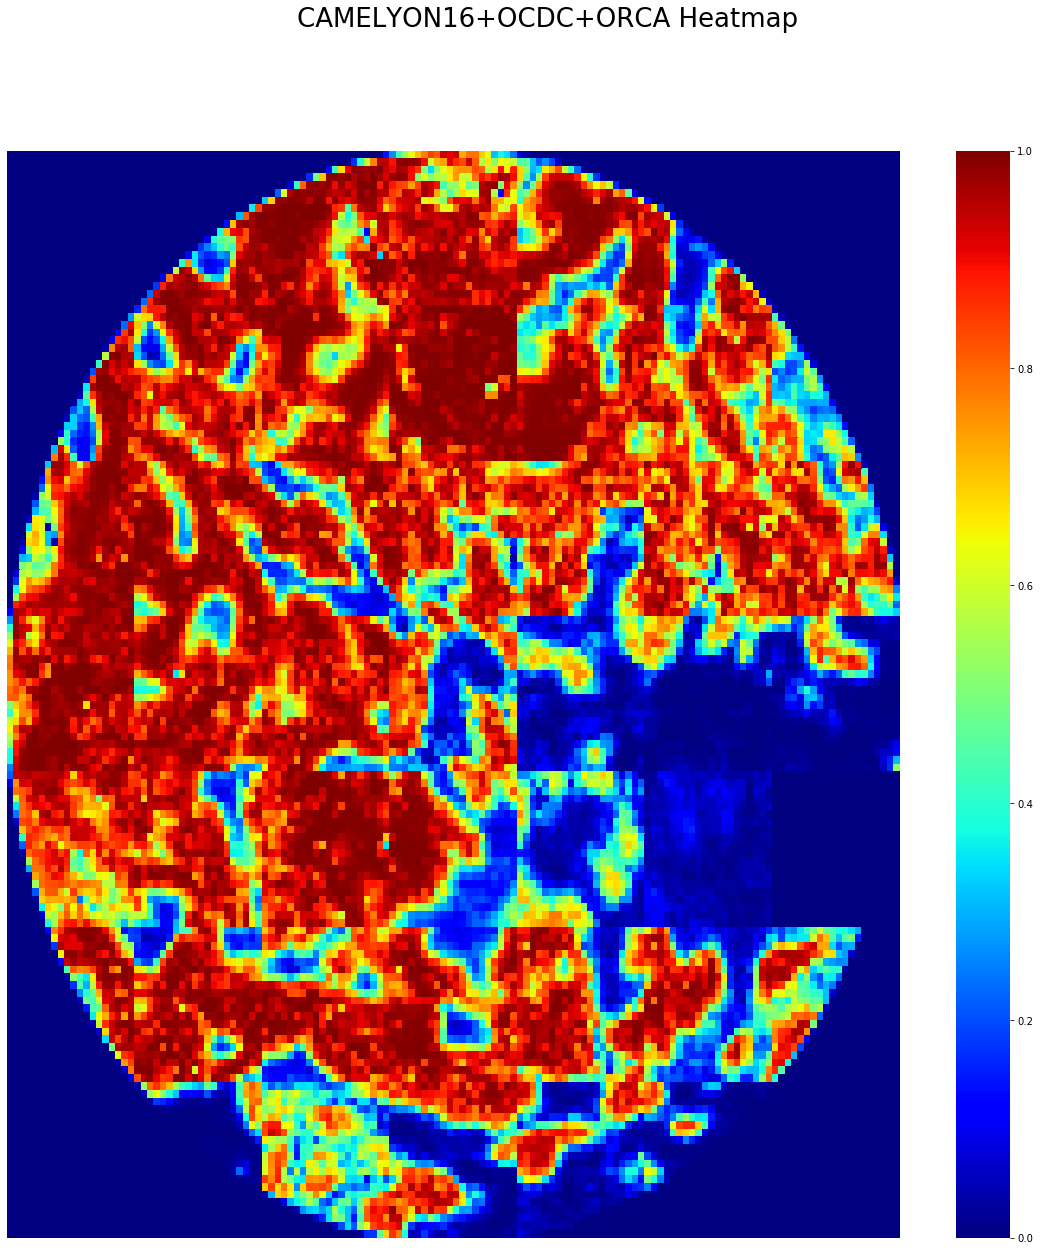

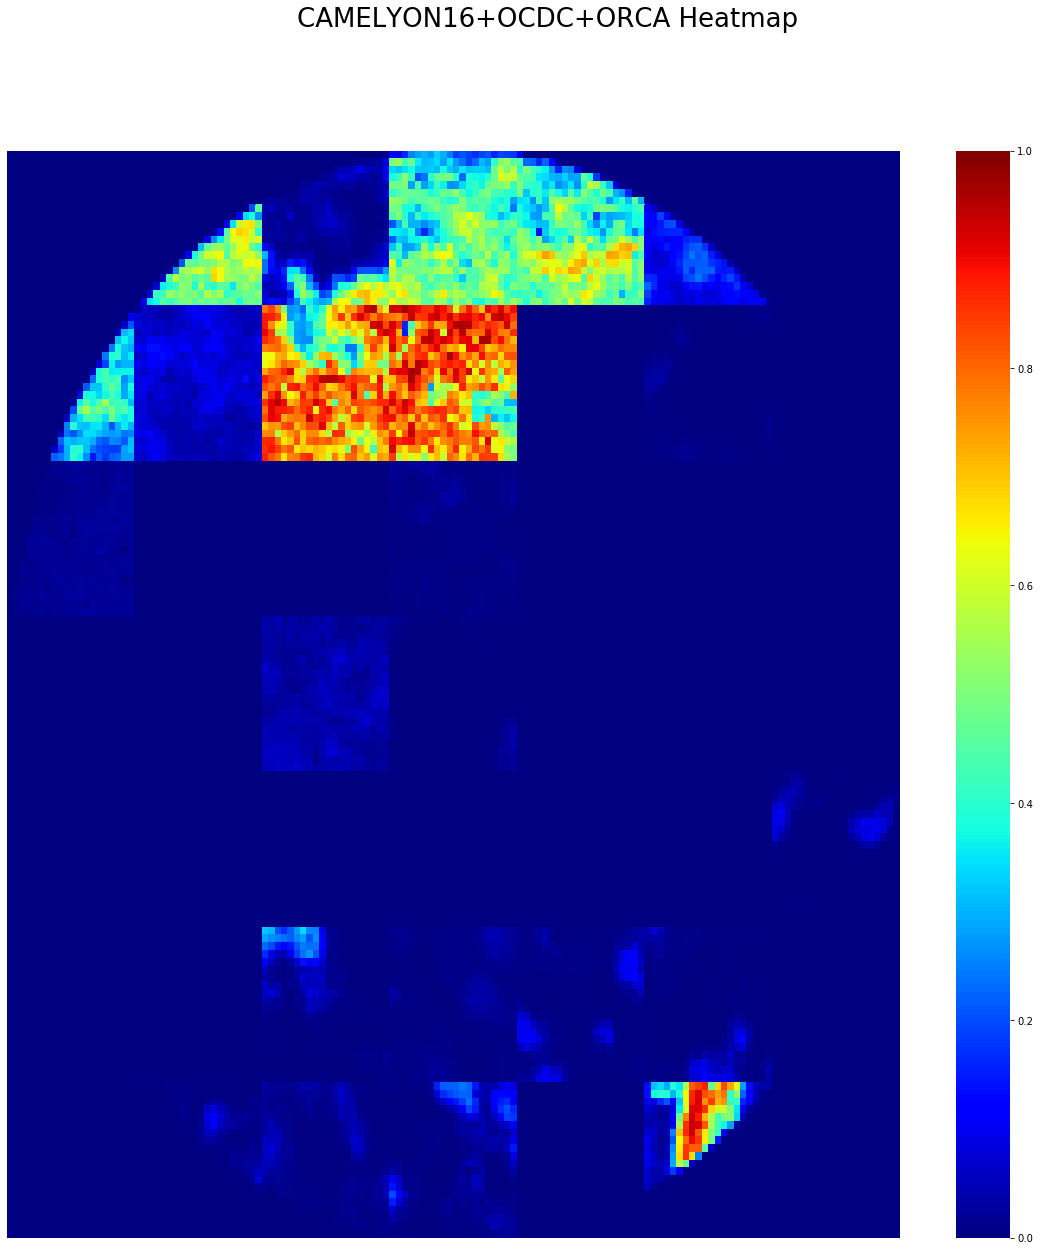

In [3]:
from sourcecode.wsi_image_utils import *

import os
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import *
%matplotlib inline

import torchvision.transforms.functional as TF
from torchvision import utils


dataset_dir = "../../datasets/ORCA"
model_dir = "../../models"
trained_model_version = "CAMELYON16+OCDC+ORCA__Size-640x640_Epoch-100_Images-4181_Batch-1"

color_model = "LAB"
magnification = 0.625
scale = get_scale_by_magnification(magnification)
tile_size = 20
tile_size_original = int(scale * tile_size)
patch_size = (tile_size_original, tile_size_original)


dataset_type = "testing"
classes = ["tumor"]
for cls in classes:

    annotations_dir = "{}/{}/lesion_annotations".format(dataset_dir, dataset_type)
    wsi_images_dir = "{}/{}/{}/wsi".format(dataset_dir, dataset_type, cls)
    patch_images_dir = "{}/{}/{}/patch/640x640".format(dataset_dir, dataset_type, cls)
    patch_images_results_dir = "{}/results/{}/{}/{}/patch/640x640".format(dataset_dir, trained_model_version, dataset_type, cls)
    wsi_images_results_dir = "{}/results/{}/{}/{}/wsi".format(dataset_dir, trained_model_version, dataset_type, cls)

    for r, d, f in sorted(os.walk(wsi_images_dir)):
        for wsi_file in sorted(f):

            wsi_image_file = "{}/{}".format(r, wsi_file)
            wsi_image_number = wsi_file.replace(".png", "")

            file_is_png = wsi_image_file.lower().endswith('.png')
            if file_is_png:

                logger.info("Segmenting wsi image: '{}'".format(wsi_file))
                unet_results_dir = "{}/{}/01-unet_result".format(patch_images_results_dir, wsi_image_number)
                if not os.path.exists(unet_results_dir):
                    logger.info("\t This WSI image was not processed by our fcn based method yet.")
                    logger.info("\t {}".format(unet_results_dir))
                    continue
                
                original_img_path = "{}/{}/{}.png".format(wsi_images_results_dir, wsi_image_number, wsi_image_number)
                pil_original_image = load_pil_image(original_img_path, gray=False)
                np_scaled_down_image = pil_to_np(pil_original_image)

                # fcn roi identification
                count_tiles = 0
                np_heatmap = np.zeros((np_scaled_down_image.shape[0], np_scaled_down_image.shape[1]))
                np_tissue_roi = np.zeros_like(np_scaled_down_image)
                for _, _, unet_tile_files in sorted(os.walk(unet_results_dir)):
                    for unet_tile_image_file in sorted(unet_tile_files):
                        if os.path.isfile("{}/{}".format(unet_results_dir, unet_tile_image_file)):

                            # load the unet image-patch result
                            np_tile_unet = np.copy(pil_to_np(load_pil_image("{}/{}".format(unet_results_dir, unet_tile_image_file), gray=True)))
                            np_tile_unet = np_tile_unet * (1.0/255)
                            np_tile_unet[np.isnan(np_tile_unet)] = 0

                            # check if exists values greather than 0.x
                            if np.any(np.unique(np_tile_unet > 0.1)):

                                aux_row_column = unet_tile_image_file.split("_")[-1].replace(".png", "").split('c')
                                row = int(aux_row_column[0].replace("r", ""))
                                column = int(aux_row_column[-1])

                                r_s = row * tile_size
                                r_e = r_s + tile_size
                                c_s = column * tile_size
                                c_e = c_s + tile_size
                                np_heatmap[r_s:r_e, c_s:c_e] = image_resize(np_tile_unet, height=tile_size)

                                np_tile_unet = basic_threshold(np_tile_unet, threshold=0.01, output_type="uint8")
                                tissue_area = tissue_percent(np_tile_unet)
                                if tissue_area > 1:

                                    count_tiles += 1

                                else:
                                    np_heatmap[r_s:r_e, c_s:c_e] = 0

                logger.info("\t '{}' tiles identified as ROI after post processing".format(count_tiles))
                logger.info("-")
                
                f = plt.figure(figsize=((np_heatmap.shape[1]*20)/np_heatmap.shape[0], 20))
                f.suptitle("{} Heatmap".format(trained_model_version.split("_")[0]), fontsize=26)

                ax1 = f.add_subplot(111)
                sns.heatmap(np_heatmap, ax=ax1, xticklabels=False, yticklabels=False, vmin=0, vmax=1, cmap="jet", cbar=True, robust=True)

                f.savefig(original_img_path.replace("{}.png".format(wsi_image_number), "{}_heatmap.png".format(wsi_image_number)))
                utils.save_image(TF.to_tensor(np_to_pil(np_heatmap)), original_img_path.replace("{}.png".format(wsi_image_number), "{}_heatmap_gray.png".format(wsi_image_number)))
                

# Generate the lesion localization points (WSI level)

In [4]:
from sourcecode.wsi_image_utils import *

import os
import csv
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import *
%matplotlib inline

import torchvision.transforms.functional as TF
from torchvision import utils

from scipy import ndimage as nd
from skimage import measure

dataset_dir = "../../datasets/ORCA"
model_dir = "../../models"
trained_model_version = "CAMELYON16+OCDC+ORCA__Size-640x640_Epoch-100_Images-4181_Batch-1"

color_model = "LAB"
magnification = 0.625
scale = get_scale_by_magnification(magnification)
tile_size = 20
tile_size_original = int(scale * tile_size)
patch_size = (tile_size_original, tile_size_original)

threshold_prob = 0.5
threshold_itc = 200/(0.243 * pow(2, 5))

dataset_type = "testing"
classes = ["tumor"]
for cls in classes:

    wsi_images_dir = "{}/{}/{}/wsi".format(dataset_dir, dataset_type, cls)
    wsi_images_results_dir = "{}/results/{}/{}/{}/wsi".format(dataset_dir, trained_model_version, dataset_type, cls)

    for r, d, f in sorted(os.walk(wsi_images_dir)):
        for wsi_file in sorted(f):

            wsi_image_file = "{}/{}".format(r, wsi_file)
            wsi_image_number = wsi_file.replace(".png", "")

            file_is_png = wsi_image_file.lower().endswith('.png')
            if file_is_png:
                
                logger.info("Generating the lesion localization points for wsi image: '{}'".format(wsi_file))
                
                heatmap_gray_path = "{}/{}/{}_heatmap_gray.png".format(wsi_images_results_dir, wsi_image_number, wsi_image_number)
                if not os.path.exists(heatmap_gray_path):
                    logger.info("\t This original WSI image was not processed yet.")
                    logger.info("\t {}".format(heatmap_gray_path))
                    continue
                                
                np_heatmap_gray = load_np_image(heatmap_gray_path, color_model="GRAY") * (1.0/255)
                np_heatmap_points = np.zeros((np_heatmap_gray.shape[0], np_heatmap_gray.shape[1]))
                np_heatmap_convex = np.zeros((np_heatmap_gray.shape[0], np_heatmap_gray.shape[1]))

                seg_threshold_img = basic_threshold(np_heatmap_gray, threshold=threshold_prob, output_type="uint8")
                seg_threshold_img = nd.morphology.binary_fill_holes(seg_threshold_img)
                
                seg_threshold_img_labels = measure.label(seg_threshold_img, connectivity=2)
                seg_threshold_img = np.zeros((np_heatmap_gray.shape[0], np_heatmap_gray.shape[1]))
                
                properties = measure.regionprops(seg_threshold_img_labels)
                
                csv_file_path = heatmap_gray_path.replace("_heatmap_gray.png", ".csv")
                with open(csv_file_path, mode='w') as result_file:

                    result_writer = csv.writer(result_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
                                        
                    labels = np.unique(seg_threshold_img_labels)
                    for lbl in range(1, (np.max(labels)+1)):
                        
                        centroid = (int(properties[lbl-1].centroid[0]), int(properties[lbl-1].centroid[1]))
                        major_axis_length = properties[lbl-1].major_axis_length
                        
                        if major_axis_length > threshold_itc:

                            hull = properties[lbl-1].convex_image
                            bbox = properties[lbl-1].bbox
                            #mean_intensity = np.mean(np_heatmap_gray[bbox[0]:bbox[2], bbox[1]:bbox[3]][hull==True])
                            #centroid_intensity = np_heatmap_gray[centroid[0], centroid[1]]
                            max_intensity = np.max(np_heatmap_gray[bbox[0]:bbox[2], bbox[1]:bbox[3]][hull==True])
                                                        
                            prob = max_intensity
                            if prob > 0.0:
                                
                                #print("   {:04.2f}, {}, {}".format(prob, centroid[1], centroid[0]))
                                seg_threshold_img[seg_threshold_img_labels == lbl] = 1
                                
                                result_writer.writerow(["{:04.2f}".format(prob), centroid[1], centroid[0]])
                                np_heatmap_points[centroid[0]-10:centroid[0]+10, centroid[1]-10:centroid[1]+10] = 1
                                np_heatmap_convex[bbox[0]:bbox[2], bbox[1]:bbox[3]][hull==True] = 1
                                np_heatmap_convex[centroid[0]-10:centroid[0]+10, centroid[1]-10:centroid[1]+10] = 0.5
                        
                utils.save_image(TF.to_tensor(np_to_pil(seg_threshold_img)), heatmap_gray_path.replace("_gray", "_gray_threshold_{}".format(threshold_prob)))
                utils.save_image(TF.to_tensor(np_to_pil(np_heatmap_points)), heatmap_gray_path.replace("_gray", "_points"))
                #utils.save_image(TF.to_tensor(np_to_pil(np_heatmap_convex)), heatmap_gray_path.replace("_gray", "_gray_threshold_{}_convex".format(threshold_prob)))


2021-04-13 07:01:40,252 :: INFO <module> :: Generating the lesion localization points for wsi image: 'TCGA-CN-4723-01Z-00-DX1.13483e7b-9322-4d39-8cd6-91e898bf2ee9_0.png'
2021-04-13 07:01:40,301 :: INFO <module> :: Generating the lesion localization points for wsi image: 'TCGA-CN-4723-01Z-00-DX1.13483e7b-9322-4d39-8cd6-91e898bf2ee9_1.png'
2021-04-13 07:01:40,324 :: INFO <module> :: Generating the lesion localization points for wsi image: 'TCGA-CN-4725-01Z-00-DX1.fe518acf-cceb-4be4-b01a-63d66248d6d4_0.png'
2021-04-13 07:01:40,354 :: INFO <module> :: Generating the lesion localization points for wsi image: 'TCGA-CN-4725-01Z-00-DX1.fe518acf-cceb-4be4-b01a-63d66248d6d4_1.png'
2021-04-13 07:01:40,385 :: INFO <module> :: Generating the lesion localization points for wsi image: 'TCGA-CN-4726-01Z-00-DX1.0ddf44ae-1cb7-41f1-8b59-a5a689f5a71c_0.png'
2021-04-13 07:01:40,409 :: INFO <module> :: Generating the lesion localization points for wsi image: 'TCGA-CN-4726-01Z-00-DX1.0ddf44ae-1cb7-41f1-8b59-

2021-04-13 07:01:41,758 :: INFO <module> :: Generating the lesion localization points for wsi image: 'TCGA-CN-5363-01Z-00-DX1.bd9c87d4-de64-4932-a90f-95888150d780_1.png'
2021-04-13 07:01:41,792 :: INFO <module> :: Generating the lesion localization points for wsi image: 'TCGA-CN-5364-01Z-00-DX1.caeed5d0-cd48-40f3-b81b-099637341563_0.png'
2021-04-13 07:01:41,819 :: INFO <module> :: Generating the lesion localization points for wsi image: 'TCGA-CN-5364-01Z-00-DX1.caeed5d0-cd48-40f3-b81b-099637341563_1.png'
2021-04-13 07:01:41,854 :: INFO <module> :: Generating the lesion localization points for wsi image: 'TCGA-CN-5365-01Z-00-DX1.26a33bd0-1eb3-4774-8be6-bf8501f4a9f9_0.png'
2021-04-13 07:01:41,879 :: INFO <module> :: Generating the lesion localization points for wsi image: 'TCGA-CN-5365-01Z-00-DX1.26a33bd0-1eb3-4774-8be6-bf8501f4a9f9_1.png'
2021-04-13 07:01:41,904 :: INFO <module> :: Generating the lesion localization points for wsi image: 'TCGA-CN-5366-01Z-00-DX1.dcc14c44-6dd1-48a1-a21c-

2021-04-13 07:01:43,336 :: INFO <module> :: Generating the lesion localization points for wsi image: 'TCGA-CN-6998-01Z-00-DX1.5780b8b9-0a1f-4330-889c-b345b29396b2_0.png'
2021-04-13 07:01:43,359 :: INFO <module> :: Generating the lesion localization points for wsi image: 'TCGA-CN-6998-01Z-00-DX1.5780b8b9-0a1f-4330-889c-b345b29396b2_1.png'


# Execute the trained model (image-patch level)

In [5]:
from sourcecode.ORCA.orca_train import *
from sourcecode.ORCA.orca_dataloader import *

import torchvision.transforms.functional as TF
from torchvision import transforms
from torchvision import utils
from datetime import datetime

from scipy import ndimage as nd
from skimage import measure

dataset_dir = "../../datasets/ORCA"
model_dir = "../../models"

batch_size = 1
patch_size = (640, 640)
color_model = "LAB"
dataloaders = create_dataloader(tile_size="{}x{}".format(patch_size[0], patch_size[1]),
                                batch_size=batch_size, 
                                shuffle=False,
                                img_input_size=patch_size,
                                img_output_size=patch_size,
                                dataset_dir=dataset_dir,
                                color_model=color_model)

dataset_train_size = len(dataloaders['train'].dataset)
dataset_test_size = len(dataloaders['test'].dataset)


threshold_prob = 0.50
threshold_itc = 200/(0.243 * pow(2, 5))


# Checking for GPU availability
use_cuda=True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") if use_cuda else "cpu"
logger.info('Runing on: {}'.format(device))

# loads our trained fcn model
trained_model_version = "CAMELYON16+OCDC+ORCA__Size-640x640_Epoch-100_Images-4181_Batch-1"
trained_model_path="{}/{}".format(model_dir, '{}.pth'.format(trained_model_version))
model = load_checkpoint(file_path=trained_model_path, img_input_size=patch_size, use_cuda=use_cuda)
cont = 0
for batch_idx, (images, masks, fname, original_size) in enumerate(dataloaders['test']):
        
    X = Variable(images).to(device) if use_cuda else images
    logger.info('Batch {}: {}/{} images: {} masks: {} {}'.format(
                (batch_idx+1), 
                (batch_idx+1) * len(images), 
                len(dataloaders['test'].dataset),
                images.shape,
                masks.shape,
                datetime.now().strftime('%d/%m/%Y %H:%M:%S')))
    
    #X_numpy = X.cpu().numpy()
    y_hat = model(X).detach().cpu().squeeze(0)
    cls = "tumor"
    
    input_image = transforms.ToPILImage()(X.squeeze(0).cpu())
    output_mask = basic_threshold(y_hat[0].detach().cpu().numpy(), threshold=threshold_prob, output_type="uint8")

    predicted_labels = measure.label(output_mask, connectivity=2)
    output_mask = np.zeros((output_mask.shape[0], output_mask.shape[1]))
    labels = np.unique(predicted_labels)
    properties = measure.regionprops(predicted_labels)
    for lbl in range(1, (np.max(labels)+1)):
        major_axis_length = properties[lbl-1].major_axis_length
        if major_axis_length > threshold_itc:
            output_mask[predicted_labels == lbl] = 1

    input_image_rgb = lab_to_rgb(pil_to_np(input_image))
    roi_image = blend_image(np_to_pil(input_image_rgb), np_to_pil(output_mask), foreground='red', alpha=0.6, inverse=True)

    # results dir
    wsi_image_number = fname[0].split("_")[0] + "_" + fname[0].split("_")[1]
    patch_images_results_dir = "{}/results/{}/testing/{}/patch/640x640/{}".format(dataset_dir, trained_model_version, cls, wsi_image_number)
    results_output_dir = "{}/01-unet_result".format(patch_images_results_dir)
    if not os.path.exists(results_output_dir):
        os.makedirs(results_output_dir)
        
    results_roi_dir = "{}/02-roi".format(patch_images_results_dir)
    if not os.path.exists(results_roi_dir):
        os.makedirs(results_roi_dir)

    # save the results
    patch_img_name = fname[0]
    utils.save_image(y_hat[0], '{}/{}'.format(results_output_dir, patch_img_name))
    utils.save_image(TF.to_tensor(roi_image), '{}/{}'.format(results_roi_dir, patch_img_name))

2021-04-13 07:03:10,413 :: INFO load_dataset :: [training] ../../datasets/ORCA/training
2021-04-13 07:03:13,257 :: INFO load_dataset :: [testing] ../../datasets/ORCA/testing
2021-04-13 07:03:16,507 :: INFO create_dataloader :: Train images (640x640): 4181 (augmentation: True)
2021-04-13 07:03:16,509 :: INFO create_dataloader :: Test images (640x640): 4481 (augmentation: False)
2021-04-13 07:03:16,512 :: INFO <module> :: Runing on: cpu
2021-04-13 07:03:34,560 :: INFO load_checkpoint :: 	 Model loaded on: cpu / 3 / 1 / (640, 640) -> ../../models/CAMELYON16+OCDC+ORCA__Size-640x640_Epoch-100_Images-4181_Batch-1.pth
2021-04-13 07:03:34,844 :: INFO <module> :: Batch 1: 1/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 07:03:34
2021-04-13 07:03:43,144 :: INFO <module> :: Batch 2: 2/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 07:03:43
2021-04-13 07:03:50,107 :: INFO <module> :: Batch 3: 3/4481 images: torch.Size([1

2021-04-13 07:10:19,548 :: INFO <module> :: Batch 51: 51/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 07:10:19
2021-04-13 07:10:27,624 :: INFO <module> :: Batch 52: 52/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 07:10:27
2021-04-13 07:10:35,454 :: INFO <module> :: Batch 53: 53/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 07:10:35
2021-04-13 07:10:43,037 :: INFO <module> :: Batch 54: 54/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 07:10:43
2021-04-13 07:10:50,740 :: INFO <module> :: Batch 55: 55/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 07:10:50
2021-04-13 07:10:58,676 :: INFO <module> :: Batch 56: 56/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 07:10:58
2021-04-13 07:11:06,532 :: INFO <module> :: Batch 57: 57/4481 images: torch.Size([1, 3, 

2021-04-13 07:17:17,684 :: INFO <module> :: Batch 105: 105/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 07:17:17
2021-04-13 07:17:25,148 :: INFO <module> :: Batch 106: 106/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 07:17:25
2021-04-13 07:17:32,877 :: INFO <module> :: Batch 107: 107/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 07:17:32
2021-04-13 07:17:40,701 :: INFO <module> :: Batch 108: 108/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 07:17:40
2021-04-13 07:17:48,130 :: INFO <module> :: Batch 109: 109/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 07:17:48
2021-04-13 07:17:56,088 :: INFO <module> :: Batch 110: 110/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 07:17:56
2021-04-13 07:18:03,841 :: INFO <module> :: Batch 111: 111/4481 images: torc

2021-04-13 07:24:17,279 :: INFO <module> :: Batch 159: 159/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 07:24:17
2021-04-13 07:24:25,135 :: INFO <module> :: Batch 160: 160/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 07:24:25
2021-04-13 07:24:32,640 :: INFO <module> :: Batch 161: 161/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 07:24:32
2021-04-13 07:24:40,322 :: INFO <module> :: Batch 162: 162/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 07:24:40
2021-04-13 07:24:48,281 :: INFO <module> :: Batch 163: 163/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 07:24:48
2021-04-13 07:24:55,822 :: INFO <module> :: Batch 164: 164/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 07:24:55
2021-04-13 07:25:03,398 :: INFO <module> :: Batch 165: 165/4481 images: torc

2021-04-13 07:31:16,401 :: INFO <module> :: Batch 213: 213/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 07:31:16
2021-04-13 07:31:24,130 :: INFO <module> :: Batch 214: 214/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 07:31:24
2021-04-13 07:31:31,758 :: INFO <module> :: Batch 215: 215/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 07:31:31
2021-04-13 07:31:39,412 :: INFO <module> :: Batch 216: 216/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 07:31:39
2021-04-13 07:31:47,040 :: INFO <module> :: Batch 217: 217/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 07:31:47
2021-04-13 07:31:54,858 :: INFO <module> :: Batch 218: 218/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 07:31:54
2021-04-13 07:32:02,273 :: INFO <module> :: Batch 219: 219/4481 images: torc

2021-04-13 07:38:13,053 :: INFO <module> :: Batch 267: 267/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 07:38:13
2021-04-13 07:38:20,438 :: INFO <module> :: Batch 268: 268/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 07:38:20
2021-04-13 07:38:28,078 :: INFO <module> :: Batch 269: 269/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 07:38:28
2021-04-13 07:38:35,661 :: INFO <module> :: Batch 270: 270/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 07:38:35
2021-04-13 07:38:42,898 :: INFO <module> :: Batch 271: 271/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 07:38:42
2021-04-13 07:38:50,113 :: INFO <module> :: Batch 272: 272/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 07:38:50
2021-04-13 07:38:57,578 :: INFO <module> :: Batch 273: 273/4481 images: torc

2021-04-13 07:45:05,970 :: INFO <module> :: Batch 321: 321/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 07:45:05
2021-04-13 07:45:13,511 :: INFO <module> :: Batch 322: 322/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 07:45:13
2021-04-13 07:45:21,022 :: INFO <module> :: Batch 323: 323/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 07:45:21
2021-04-13 07:45:28,580 :: INFO <module> :: Batch 324: 324/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 07:45:28
2021-04-13 07:45:36,129 :: INFO <module> :: Batch 325: 325/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 07:45:36
2021-04-13 07:45:43,839 :: INFO <module> :: Batch 326: 326/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 07:45:43
2021-04-13 07:45:51,712 :: INFO <module> :: Batch 327: 327/4481 images: torc

2021-04-13 07:51:56,333 :: INFO <module> :: Batch 375: 375/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 07:51:56
2021-04-13 07:52:03,833 :: INFO <module> :: Batch 376: 376/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 07:52:03
2021-04-13 07:52:11,649 :: INFO <module> :: Batch 377: 377/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 07:52:11
2021-04-13 07:52:19,018 :: INFO <module> :: Batch 378: 378/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 07:52:19
2021-04-13 07:52:27,539 :: INFO <module> :: Batch 379: 379/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 07:52:27
2021-04-13 07:52:35,560 :: INFO <module> :: Batch 380: 380/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 07:52:35
2021-04-13 07:52:43,008 :: INFO <module> :: Batch 381: 381/4481 images: torc

2021-04-13 07:58:43,733 :: INFO <module> :: Batch 429: 429/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 07:58:43
2021-04-13 07:58:51,107 :: INFO <module> :: Batch 430: 430/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 07:58:51
2021-04-13 07:58:58,179 :: INFO <module> :: Batch 431: 431/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 07:58:58
2021-04-13 07:59:05,423 :: INFO <module> :: Batch 432: 432/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 07:59:05
2021-04-13 07:59:12,722 :: INFO <module> :: Batch 433: 433/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 07:59:12
2021-04-13 07:59:19,875 :: INFO <module> :: Batch 434: 434/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 07:59:19
2021-04-13 07:59:27,415 :: INFO <module> :: Batch 435: 435/4481 images: torc

2021-04-13 08:05:33,962 :: INFO <module> :: Batch 483: 483/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 08:05:33
2021-04-13 08:05:41,260 :: INFO <module> :: Batch 484: 484/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 08:05:41
2021-04-13 08:05:48,652 :: INFO <module> :: Batch 485: 485/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 08:05:48
2021-04-13 08:05:56,000 :: INFO <module> :: Batch 486: 486/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 08:05:56
2021-04-13 08:06:03,709 :: INFO <module> :: Batch 487: 487/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 08:06:03
2021-04-13 08:06:10,884 :: INFO <module> :: Batch 488: 488/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 08:06:10
2021-04-13 08:06:18,209 :: INFO <module> :: Batch 489: 489/4481 images: torc

2021-04-13 08:12:22,289 :: INFO <module> :: Batch 537: 537/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 08:12:22
2021-04-13 08:12:30,145 :: INFO <module> :: Batch 538: 538/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 08:12:30
2021-04-13 08:12:39,426 :: INFO <module> :: Batch 539: 539/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 08:12:39
2021-04-13 08:12:46,364 :: INFO <module> :: Batch 540: 540/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 08:12:46
2021-04-13 08:12:53,429 :: INFO <module> :: Batch 541: 541/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 08:12:53
2021-04-13 08:13:01,285 :: INFO <module> :: Batch 542: 542/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 08:13:01
2021-04-13 08:13:10,056 :: INFO <module> :: Batch 543: 543/4481 images: torc

2021-04-13 08:19:07,378 :: INFO <module> :: Batch 591: 591/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 08:19:07
2021-04-13 08:19:14,790 :: INFO <module> :: Batch 592: 592/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 08:19:14
2021-04-13 08:19:22,145 :: INFO <module> :: Batch 593: 593/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 08:19:22
2021-04-13 08:19:29,331 :: INFO <module> :: Batch 594: 594/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 08:19:29
2021-04-13 08:19:36,788 :: INFO <module> :: Batch 595: 595/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 08:19:36
2021-04-13 08:19:43,927 :: INFO <module> :: Batch 596: 596/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 08:19:43
2021-04-13 08:19:51,155 :: INFO <module> :: Batch 597: 597/4481 images: torc

2021-04-13 08:25:47,534 :: INFO <module> :: Batch 645: 645/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 08:25:47
2021-04-13 08:25:54,872 :: INFO <module> :: Batch 646: 646/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 08:25:54
2021-04-13 08:26:02,077 :: INFO <module> :: Batch 647: 647/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 08:26:02
2021-04-13 08:26:09,884 :: INFO <module> :: Batch 648: 648/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 08:26:09
2021-04-13 08:26:17,448 :: INFO <module> :: Batch 649: 649/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 08:26:17
2021-04-13 08:26:25,186 :: INFO <module> :: Batch 650: 650/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 08:26:25
2021-04-13 08:26:32,702 :: INFO <module> :: Batch 651: 651/4481 images: torc

2021-04-13 08:32:24,551 :: INFO <module> :: Batch 699: 699/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 08:32:24
2021-04-13 08:32:31,822 :: INFO <module> :: Batch 700: 700/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 08:32:31
2021-04-13 08:32:39,511 :: INFO <module> :: Batch 701: 701/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 08:32:39
2021-04-13 08:32:46,581 :: INFO <module> :: Batch 702: 702/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 08:32:46
2021-04-13 08:32:54,535 :: INFO <module> :: Batch 703: 703/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 08:32:54
2021-04-13 08:33:01,721 :: INFO <module> :: Batch 704: 704/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 08:33:01
2021-04-13 08:33:09,761 :: INFO <module> :: Batch 705: 705/4481 images: torc

2021-04-13 08:39:08,955 :: INFO <module> :: Batch 753: 753/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 08:39:08
2021-04-13 08:39:16,603 :: INFO <module> :: Batch 754: 754/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 08:39:16
2021-04-13 08:39:24,818 :: INFO <module> :: Batch 755: 755/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 08:39:24
2021-04-13 08:39:32,172 :: INFO <module> :: Batch 756: 756/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 08:39:32
2021-04-13 08:39:39,498 :: INFO <module> :: Batch 757: 757/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 08:39:39
2021-04-13 08:39:46,995 :: INFO <module> :: Batch 758: 758/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 08:39:46
2021-04-13 08:39:54,446 :: INFO <module> :: Batch 759: 759/4481 images: torc

2021-04-13 08:45:49,675 :: INFO <module> :: Batch 807: 807/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 08:45:49
2021-04-13 08:45:57,095 :: INFO <module> :: Batch 808: 808/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 08:45:57
2021-04-13 08:46:04,518 :: INFO <module> :: Batch 809: 809/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 08:46:04
2021-04-13 08:46:11,662 :: INFO <module> :: Batch 810: 810/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 08:46:11
2021-04-13 08:46:18,767 :: INFO <module> :: Batch 811: 811/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 08:46:18
2021-04-13 08:46:27,014 :: INFO <module> :: Batch 812: 812/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 08:46:27
2021-04-13 08:46:34,819 :: INFO <module> :: Batch 813: 813/4481 images: torc

2021-04-13 08:52:31,727 :: INFO <module> :: Batch 861: 861/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 08:52:31
2021-04-13 08:52:39,428 :: INFO <module> :: Batch 862: 862/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 08:52:39
2021-04-13 08:52:46,728 :: INFO <module> :: Batch 863: 863/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 08:52:46
2021-04-13 08:52:54,838 :: INFO <module> :: Batch 864: 864/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 08:52:54
2021-04-13 08:53:02,013 :: INFO <module> :: Batch 865: 865/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 08:53:02
2021-04-13 08:53:09,772 :: INFO <module> :: Batch 866: 866/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 08:53:09
2021-04-13 08:53:16,972 :: INFO <module> :: Batch 867: 867/4481 images: torc

2021-04-13 08:59:14,383 :: INFO <module> :: Batch 915: 915/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 08:59:14
2021-04-13 08:59:21,329 :: INFO <module> :: Batch 916: 916/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 08:59:21
2021-04-13 08:59:29,014 :: INFO <module> :: Batch 917: 917/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 08:59:29
2021-04-13 08:59:36,383 :: INFO <module> :: Batch 918: 918/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 08:59:36
2021-04-13 08:59:43,947 :: INFO <module> :: Batch 919: 919/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 08:59:43
2021-04-13 08:59:51,119 :: INFO <module> :: Batch 920: 920/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 08:59:51
2021-04-13 08:59:58,214 :: INFO <module> :: Batch 921: 921/4481 images: torc

2021-04-13 09:05:56,177 :: INFO <module> :: Batch 969: 969/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 09:05:56
2021-04-13 09:06:03,251 :: INFO <module> :: Batch 970: 970/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 09:06:03
2021-04-13 09:06:10,473 :: INFO <module> :: Batch 971: 971/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 09:06:10
2021-04-13 09:06:17,848 :: INFO <module> :: Batch 972: 972/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 09:06:17
2021-04-13 09:06:25,327 :: INFO <module> :: Batch 973: 973/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 09:06:25
2021-04-13 09:06:32,599 :: INFO <module> :: Batch 974: 974/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 09:06:32
2021-04-13 09:06:40,898 :: INFO <module> :: Batch 975: 975/4481 images: torc

2021-04-13 09:12:24,780 :: INFO <module> :: Batch 1022: 1022/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 09:12:24
2021-04-13 09:12:32,156 :: INFO <module> :: Batch 1023: 1023/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 09:12:32
2021-04-13 09:12:39,267 :: INFO <module> :: Batch 1024: 1024/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 09:12:39
2021-04-13 09:12:46,338 :: INFO <module> :: Batch 1025: 1025/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 09:12:46
2021-04-13 09:12:53,617 :: INFO <module> :: Batch 1026: 1026/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 09:12:53
2021-04-13 09:13:00,922 :: INFO <module> :: Batch 1027: 1027/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 09:13:00
2021-04-13 09:13:08,218 :: INFO <module> :: Batch 1028: 1028/448

2021-04-13 09:18:53,557 :: INFO <module> :: Batch 1075: 1075/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 09:18:53
2021-04-13 09:19:00,603 :: INFO <module> :: Batch 1076: 1076/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 09:19:00
2021-04-13 09:19:07,848 :: INFO <module> :: Batch 1077: 1077/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 09:19:07
2021-04-13 09:19:15,047 :: INFO <module> :: Batch 1078: 1078/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 09:19:15
2021-04-13 09:19:22,200 :: INFO <module> :: Batch 1079: 1079/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 09:19:22
2021-04-13 09:19:29,430 :: INFO <module> :: Batch 1080: 1080/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 09:19:29
2021-04-13 09:19:37,555 :: INFO <module> :: Batch 1081: 1081/448

2021-04-13 09:25:20,360 :: INFO <module> :: Batch 1128: 1128/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 09:25:20
2021-04-13 09:25:27,307 :: INFO <module> :: Batch 1129: 1129/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 09:25:27
2021-04-13 09:25:34,693 :: INFO <module> :: Batch 1130: 1130/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 09:25:34
2021-04-13 09:25:42,050 :: INFO <module> :: Batch 1131: 1131/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 09:25:42
2021-04-13 09:25:49,512 :: INFO <module> :: Batch 1132: 1132/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 09:25:49
2021-04-13 09:25:56,396 :: INFO <module> :: Batch 1133: 1133/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 09:25:56
2021-04-13 09:26:03,547 :: INFO <module> :: Batch 1134: 1134/448

2021-04-13 09:31:51,627 :: INFO <module> :: Batch 1181: 1181/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 09:31:51
2021-04-13 09:31:59,096 :: INFO <module> :: Batch 1182: 1182/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 09:31:59
2021-04-13 09:32:06,145 :: INFO <module> :: Batch 1183: 1183/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 09:32:06
2021-04-13 09:32:13,211 :: INFO <module> :: Batch 1184: 1184/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 09:32:13
2021-04-13 09:32:20,558 :: INFO <module> :: Batch 1185: 1185/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 09:32:20
2021-04-13 09:32:28,391 :: INFO <module> :: Batch 1186: 1186/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 09:32:28
2021-04-13 09:32:35,824 :: INFO <module> :: Batch 1187: 1187/448

2021-04-13 09:38:28,959 :: INFO <module> :: Batch 1234: 1234/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 09:38:28
2021-04-13 09:38:36,298 :: INFO <module> :: Batch 1235: 1235/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 09:38:36
2021-04-13 09:38:43,481 :: INFO <module> :: Batch 1236: 1236/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 09:38:43
2021-04-13 09:38:50,708 :: INFO <module> :: Batch 1237: 1237/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 09:38:50
2021-04-13 09:38:57,838 :: INFO <module> :: Batch 1238: 1238/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 09:38:57
2021-04-13 09:39:05,421 :: INFO <module> :: Batch 1239: 1239/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 09:39:05
2021-04-13 09:39:13,416 :: INFO <module> :: Batch 1240: 1240/448

2021-04-13 09:45:06,973 :: INFO <module> :: Batch 1287: 1287/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 09:45:06
2021-04-13 09:45:14,211 :: INFO <module> :: Batch 1288: 1288/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 09:45:14
2021-04-13 09:45:22,092 :: INFO <module> :: Batch 1289: 1289/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 09:45:22
2021-04-13 09:45:29,749 :: INFO <module> :: Batch 1290: 1290/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 09:45:29
2021-04-13 09:45:37,369 :: INFO <module> :: Batch 1291: 1291/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 09:45:37
2021-04-13 09:45:44,674 :: INFO <module> :: Batch 1292: 1292/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 09:45:44
2021-04-13 09:45:51,876 :: INFO <module> :: Batch 1293: 1293/448

2021-04-13 09:51:48,268 :: INFO <module> :: Batch 1340: 1340/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 09:51:48
2021-04-13 09:51:55,779 :: INFO <module> :: Batch 1341: 1341/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 09:51:55
2021-04-13 09:52:03,265 :: INFO <module> :: Batch 1342: 1342/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 09:52:03
2021-04-13 09:52:10,538 :: INFO <module> :: Batch 1343: 1343/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 09:52:10
2021-04-13 09:52:17,799 :: INFO <module> :: Batch 1344: 1344/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 09:52:17
2021-04-13 09:52:25,839 :: INFO <module> :: Batch 1345: 1345/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 09:52:25
2021-04-13 09:52:33,259 :: INFO <module> :: Batch 1346: 1346/448

2021-04-13 09:58:28,296 :: INFO <module> :: Batch 1393: 1393/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 09:58:28
2021-04-13 09:58:35,797 :: INFO <module> :: Batch 1394: 1394/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 09:58:35
2021-04-13 09:58:42,899 :: INFO <module> :: Batch 1395: 1395/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 09:58:42
2021-04-13 09:58:50,157 :: INFO <module> :: Batch 1396: 1396/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 09:58:50
2021-04-13 09:58:58,111 :: INFO <module> :: Batch 1397: 1397/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 09:58:58
2021-04-13 09:59:05,435 :: INFO <module> :: Batch 1398: 1398/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 09:59:05
2021-04-13 09:59:12,943 :: INFO <module> :: Batch 1399: 1399/448

2021-04-13 10:05:07,407 :: INFO <module> :: Batch 1446: 1446/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 10:05:07
2021-04-13 10:05:14,729 :: INFO <module> :: Batch 1447: 1447/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 10:05:14
2021-04-13 10:05:22,155 :: INFO <module> :: Batch 1448: 1448/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 10:05:22
2021-04-13 10:05:29,314 :: INFO <module> :: Batch 1449: 1449/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 10:05:29
2021-04-13 10:05:36,940 :: INFO <module> :: Batch 1450: 1450/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 10:05:36
2021-04-13 10:05:44,098 :: INFO <module> :: Batch 1451: 1451/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 10:05:44
2021-04-13 10:05:51,347 :: INFO <module> :: Batch 1452: 1452/448

2021-04-13 10:11:43,671 :: INFO <module> :: Batch 1499: 1499/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 10:11:43
2021-04-13 10:11:50,929 :: INFO <module> :: Batch 1500: 1500/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 10:11:50
2021-04-13 10:11:57,967 :: INFO <module> :: Batch 1501: 1501/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 10:11:57
2021-04-13 10:12:06,074 :: INFO <module> :: Batch 1502: 1502/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 10:12:06
2021-04-13 10:12:13,289 :: INFO <module> :: Batch 1503: 1503/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 10:12:13
2021-04-13 10:12:20,287 :: INFO <module> :: Batch 1504: 1504/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 10:12:20
2021-04-13 10:12:27,966 :: INFO <module> :: Batch 1505: 1505/448

2021-04-13 10:18:17,753 :: INFO <module> :: Batch 1552: 1552/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 10:18:17
2021-04-13 10:18:25,287 :: INFO <module> :: Batch 1553: 1553/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 10:18:25
2021-04-13 10:18:32,899 :: INFO <module> :: Batch 1554: 1554/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 10:18:32
2021-04-13 10:18:40,051 :: INFO <module> :: Batch 1555: 1555/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 10:18:40
2021-04-13 10:18:47,201 :: INFO <module> :: Batch 1556: 1556/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 10:18:47
2021-04-13 10:18:54,331 :: INFO <module> :: Batch 1557: 1557/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 10:18:54
2021-04-13 10:19:02,175 :: INFO <module> :: Batch 1558: 1558/448

2021-04-13 10:24:54,583 :: INFO <module> :: Batch 1605: 1605/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 10:24:54
2021-04-13 10:25:01,854 :: INFO <module> :: Batch 1606: 1606/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 10:25:01
2021-04-13 10:25:08,906 :: INFO <module> :: Batch 1607: 1607/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 10:25:08
2021-04-13 10:25:15,998 :: INFO <module> :: Batch 1608: 1608/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 10:25:15
2021-04-13 10:25:23,381 :: INFO <module> :: Batch 1609: 1609/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 10:25:23
2021-04-13 10:25:31,186 :: INFO <module> :: Batch 1610: 1610/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 10:25:31
2021-04-13 10:25:38,969 :: INFO <module> :: Batch 1611: 1611/448

2021-04-13 10:31:33,475 :: INFO <module> :: Batch 1658: 1658/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 10:31:33
2021-04-13 10:31:41,461 :: INFO <module> :: Batch 1659: 1659/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 10:31:41
2021-04-13 10:31:48,809 :: INFO <module> :: Batch 1660: 1660/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 10:31:48
2021-04-13 10:31:56,150 :: INFO <module> :: Batch 1661: 1661/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 10:31:56
2021-04-13 10:32:03,583 :: INFO <module> :: Batch 1662: 1662/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 10:32:03
2021-04-13 10:32:10,858 :: INFO <module> :: Batch 1663: 1663/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 10:32:10
2021-04-13 10:32:18,125 :: INFO <module> :: Batch 1664: 1664/448

2021-04-13 10:38:10,856 :: INFO <module> :: Batch 1711: 1711/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 10:38:10
2021-04-13 10:38:18,397 :: INFO <module> :: Batch 1712: 1712/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 10:38:18
2021-04-13 10:38:26,269 :: INFO <module> :: Batch 1713: 1713/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 10:38:26
2021-04-13 10:38:33,721 :: INFO <module> :: Batch 1714: 1714/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 10:38:33
2021-04-13 10:38:41,185 :: INFO <module> :: Batch 1715: 1715/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 10:38:41
2021-04-13 10:38:48,621 :: INFO <module> :: Batch 1716: 1716/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 10:38:48
2021-04-13 10:38:56,046 :: INFO <module> :: Batch 1717: 1717/448

2021-04-13 10:44:52,890 :: INFO <module> :: Batch 1764: 1764/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 10:44:52
2021-04-13 10:45:00,404 :: INFO <module> :: Batch 1765: 1765/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 10:45:00
2021-04-13 10:45:07,903 :: INFO <module> :: Batch 1766: 1766/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 10:45:07
2021-04-13 10:45:15,489 :: INFO <module> :: Batch 1767: 1767/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 10:45:15
2021-04-13 10:45:23,537 :: INFO <module> :: Batch 1768: 1768/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 10:45:23
2021-04-13 10:45:30,641 :: INFO <module> :: Batch 1769: 1769/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 10:45:30
2021-04-13 10:45:37,872 :: INFO <module> :: Batch 1770: 1770/448

2021-04-13 10:51:32,277 :: INFO <module> :: Batch 1817: 1817/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 10:51:32
2021-04-13 10:51:39,782 :: INFO <module> :: Batch 1818: 1818/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 10:51:39
2021-04-13 10:51:47,293 :: INFO <module> :: Batch 1819: 1819/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 10:51:47
2021-04-13 10:51:54,739 :: INFO <module> :: Batch 1820: 1820/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 10:51:54
2021-04-13 10:52:01,772 :: INFO <module> :: Batch 1821: 1821/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 10:52:01
2021-04-13 10:52:08,877 :: INFO <module> :: Batch 1822: 1822/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 10:52:08
2021-04-13 10:52:16,386 :: INFO <module> :: Batch 1823: 1823/448

2021-04-13 10:58:10,946 :: INFO <module> :: Batch 1870: 1870/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 10:58:10
2021-04-13 10:58:18,289 :: INFO <module> :: Batch 1871: 1871/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 10:58:18
2021-04-13 10:58:26,064 :: INFO <module> :: Batch 1872: 1872/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 10:58:26
2021-04-13 10:58:33,490 :: INFO <module> :: Batch 1873: 1873/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 10:58:33
2021-04-13 10:58:41,370 :: INFO <module> :: Batch 1874: 1874/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 10:58:41
2021-04-13 10:58:49,062 :: INFO <module> :: Batch 1875: 1875/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 10:58:49
2021-04-13 10:58:56,291 :: INFO <module> :: Batch 1876: 1876/448

2021-04-13 11:04:46,928 :: INFO <module> :: Batch 1923: 1923/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 11:04:46
2021-04-13 11:04:54,235 :: INFO <module> :: Batch 1924: 1924/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 11:04:54
2021-04-13 11:05:01,896 :: INFO <module> :: Batch 1925: 1925/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 11:05:01
2021-04-13 11:05:09,466 :: INFO <module> :: Batch 1926: 1926/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 11:05:09
2021-04-13 11:05:17,011 :: INFO <module> :: Batch 1927: 1927/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 11:05:17
2021-04-13 11:05:24,528 :: INFO <module> :: Batch 1928: 1928/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 11:05:24
2021-04-13 11:05:32,286 :: INFO <module> :: Batch 1929: 1929/448

2021-04-13 11:11:24,270 :: INFO <module> :: Batch 1976: 1976/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 11:11:24
2021-04-13 11:11:31,524 :: INFO <module> :: Batch 1977: 1977/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 11:11:31
2021-04-13 11:11:39,636 :: INFO <module> :: Batch 1978: 1978/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 11:11:39
2021-04-13 11:11:47,283 :: INFO <module> :: Batch 1979: 1979/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 11:11:47
2021-04-13 11:11:54,871 :: INFO <module> :: Batch 1980: 1980/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 11:11:54
2021-04-13 11:12:02,172 :: INFO <module> :: Batch 1981: 1981/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 11:12:02
2021-04-13 11:12:09,707 :: INFO <module> :: Batch 1982: 1982/448

2021-04-13 11:18:00,761 :: INFO <module> :: Batch 2029: 2029/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 11:18:00
2021-04-13 11:18:08,541 :: INFO <module> :: Batch 2030: 2030/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 11:18:08
2021-04-13 11:18:15,819 :: INFO <module> :: Batch 2031: 2031/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 11:18:15
2021-04-13 11:18:23,896 :: INFO <module> :: Batch 2032: 2032/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 11:18:23
2021-04-13 11:18:33,349 :: INFO <module> :: Batch 2033: 2033/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 11:18:33
2021-04-13 11:18:41,342 :: INFO <module> :: Batch 2034: 2034/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 11:18:41
2021-04-13 11:18:49,168 :: INFO <module> :: Batch 2035: 2035/448

2021-04-13 11:24:45,275 :: INFO <module> :: Batch 2082: 2082/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 11:24:45
2021-04-13 11:24:53,097 :: INFO <module> :: Batch 2083: 2083/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 11:24:53
2021-04-13 11:25:01,071 :: INFO <module> :: Batch 2084: 2084/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 11:25:01
2021-04-13 11:25:08,650 :: INFO <module> :: Batch 2085: 2085/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 11:25:08
2021-04-13 11:25:15,779 :: INFO <module> :: Batch 2086: 2086/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 11:25:15
2021-04-13 11:25:23,908 :: INFO <module> :: Batch 2087: 2087/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 11:25:23
2021-04-13 11:25:31,209 :: INFO <module> :: Batch 2088: 2088/448

2021-04-13 11:31:21,808 :: INFO <module> :: Batch 2135: 2135/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 11:31:21
2021-04-13 11:31:29,106 :: INFO <module> :: Batch 2136: 2136/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 11:31:29
2021-04-13 11:31:36,428 :: INFO <module> :: Batch 2137: 2137/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 11:31:36
2021-04-13 11:31:44,582 :: INFO <module> :: Batch 2138: 2138/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 11:31:44
2021-04-13 11:31:51,933 :: INFO <module> :: Batch 2139: 2139/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 11:31:51
2021-04-13 11:31:59,642 :: INFO <module> :: Batch 2140: 2140/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 11:31:59
2021-04-13 11:32:07,312 :: INFO <module> :: Batch 2141: 2141/448

2021-04-13 11:38:00,207 :: INFO <module> :: Batch 2188: 2188/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 11:38:00
2021-04-13 11:38:07,590 :: INFO <module> :: Batch 2189: 2189/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 11:38:07
2021-04-13 11:38:15,044 :: INFO <module> :: Batch 2190: 2190/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 11:38:15
2021-04-13 11:38:23,392 :: INFO <module> :: Batch 2191: 2191/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 11:38:23
2021-04-13 11:38:30,685 :: INFO <module> :: Batch 2192: 2192/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 11:38:30
2021-04-13 11:38:38,069 :: INFO <module> :: Batch 2193: 2193/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 11:38:38
2021-04-13 11:38:45,500 :: INFO <module> :: Batch 2194: 2194/448

2021-04-13 11:44:36,392 :: INFO <module> :: Batch 2241: 2241/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 11:44:36
2021-04-13 11:44:43,864 :: INFO <module> :: Batch 2242: 2242/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 11:44:43
2021-04-13 11:44:51,252 :: INFO <module> :: Batch 2243: 2243/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 11:44:51
2021-04-13 11:44:58,996 :: INFO <module> :: Batch 2244: 2244/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 11:44:58
2021-04-13 11:45:06,440 :: INFO <module> :: Batch 2245: 2245/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 11:45:06
2021-04-13 11:45:13,701 :: INFO <module> :: Batch 2246: 2246/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 11:45:13
2021-04-13 11:45:21,112 :: INFO <module> :: Batch 2247: 2247/448

2021-04-13 11:51:13,141 :: INFO <module> :: Batch 2294: 2294/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 11:51:13
2021-04-13 11:51:20,516 :: INFO <module> :: Batch 2295: 2295/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 11:51:20
2021-04-13 11:51:27,788 :: INFO <module> :: Batch 2296: 2296/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 11:51:27
2021-04-13 11:51:35,666 :: INFO <module> :: Batch 2297: 2297/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 11:51:35
2021-04-13 11:51:43,007 :: INFO <module> :: Batch 2298: 2298/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 11:51:43
2021-04-13 11:51:50,344 :: INFO <module> :: Batch 2299: 2299/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 11:51:50
2021-04-13 11:51:57,793 :: INFO <module> :: Batch 2300: 2300/448

2021-04-13 11:57:49,763 :: INFO <module> :: Batch 2347: 2347/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 11:57:49
2021-04-13 11:57:57,378 :: INFO <module> :: Batch 2348: 2348/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 11:57:57
2021-04-13 11:58:05,467 :: INFO <module> :: Batch 2349: 2349/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 11:58:05
2021-04-13 11:58:13,858 :: INFO <module> :: Batch 2350: 2350/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 11:58:13
2021-04-13 11:58:21,146 :: INFO <module> :: Batch 2351: 2351/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 11:58:21
2021-04-13 11:58:29,300 :: INFO <module> :: Batch 2352: 2352/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 11:58:29
2021-04-13 11:58:36,672 :: INFO <module> :: Batch 2353: 2353/448

2021-04-13 12:04:28,670 :: INFO <module> :: Batch 2400: 2400/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 12:04:28
2021-04-13 12:04:35,963 :: INFO <module> :: Batch 2401: 2401/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 12:04:35
2021-04-13 12:04:43,538 :: INFO <module> :: Batch 2402: 2402/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 12:04:43
2021-04-13 12:04:51,012 :: INFO <module> :: Batch 2403: 2403/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 12:04:51
2021-04-13 12:04:58,334 :: INFO <module> :: Batch 2404: 2404/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 12:04:58
2021-04-13 12:05:05,530 :: INFO <module> :: Batch 2405: 2405/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 12:05:05
2021-04-13 12:05:12,979 :: INFO <module> :: Batch 2406: 2406/448

2021-04-13 12:11:07,675 :: INFO <module> :: Batch 2453: 2453/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 12:11:07
2021-04-13 12:11:14,967 :: INFO <module> :: Batch 2454: 2454/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 12:11:14
2021-04-13 12:11:22,219 :: INFO <module> :: Batch 2455: 2455/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 12:11:22
2021-04-13 12:11:29,759 :: INFO <module> :: Batch 2456: 2456/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 12:11:29
2021-04-13 12:11:37,084 :: INFO <module> :: Batch 2457: 2457/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 12:11:37
2021-04-13 12:11:44,476 :: INFO <module> :: Batch 2458: 2458/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 12:11:44
2021-04-13 12:11:52,169 :: INFO <module> :: Batch 2459: 2459/448

2021-04-13 12:17:43,357 :: INFO <module> :: Batch 2506: 2506/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 12:17:43
2021-04-13 12:17:50,952 :: INFO <module> :: Batch 2507: 2507/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 12:17:50
2021-04-13 12:17:58,722 :: INFO <module> :: Batch 2508: 2508/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 12:17:58
2021-04-13 12:18:06,786 :: INFO <module> :: Batch 2509: 2509/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 12:18:06
2021-04-13 12:18:14,488 :: INFO <module> :: Batch 2510: 2510/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 12:18:14
2021-04-13 12:18:21,621 :: INFO <module> :: Batch 2511: 2511/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 12:18:21
2021-04-13 12:18:29,430 :: INFO <module> :: Batch 2512: 2512/448

2021-04-13 12:24:19,098 :: INFO <module> :: Batch 2559: 2559/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 12:24:19
2021-04-13 12:24:26,841 :: INFO <module> :: Batch 2560: 2560/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 12:24:26
2021-04-13 12:24:34,374 :: INFO <module> :: Batch 2561: 2561/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 12:24:34
2021-04-13 12:24:41,832 :: INFO <module> :: Batch 2562: 2562/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 12:24:41
2021-04-13 12:24:49,477 :: INFO <module> :: Batch 2563: 2563/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 12:24:49
2021-04-13 12:24:57,144 :: INFO <module> :: Batch 2564: 2564/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 12:24:57
2021-04-13 12:25:04,427 :: INFO <module> :: Batch 2565: 2565/448

2021-04-13 12:30:58,373 :: INFO <module> :: Batch 2612: 2612/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 12:30:58
2021-04-13 12:31:05,714 :: INFO <module> :: Batch 2613: 2613/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 12:31:05
2021-04-13 12:31:13,078 :: INFO <module> :: Batch 2614: 2614/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 12:31:13
2021-04-13 12:31:20,590 :: INFO <module> :: Batch 2615: 2615/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 12:31:20
2021-04-13 12:31:28,112 :: INFO <module> :: Batch 2616: 2616/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 12:31:28
2021-04-13 12:31:35,767 :: INFO <module> :: Batch 2617: 2617/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 12:31:35
2021-04-13 12:31:43,175 :: INFO <module> :: Batch 2618: 2618/448

2021-04-13 12:37:32,963 :: INFO <module> :: Batch 2665: 2665/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 12:37:32
2021-04-13 12:37:40,455 :: INFO <module> :: Batch 2666: 2666/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 12:37:40
2021-04-13 12:37:47,839 :: INFO <module> :: Batch 2667: 2667/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 12:37:47
2021-04-13 12:37:54,909 :: INFO <module> :: Batch 2668: 2668/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 12:37:54
2021-04-13 12:38:02,221 :: INFO <module> :: Batch 2669: 2669/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 12:38:02
2021-04-13 12:38:10,243 :: INFO <module> :: Batch 2670: 2670/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 12:38:10
2021-04-13 12:38:17,974 :: INFO <module> :: Batch 2671: 2671/448

2021-04-13 12:44:11,690 :: INFO <module> :: Batch 2718: 2718/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 12:44:11
2021-04-13 12:44:18,996 :: INFO <module> :: Batch 2719: 2719/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 12:44:18
2021-04-13 12:44:27,312 :: INFO <module> :: Batch 2720: 2720/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 12:44:27
2021-04-13 12:44:34,689 :: INFO <module> :: Batch 2721: 2721/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 12:44:34
2021-04-13 12:44:41,820 :: INFO <module> :: Batch 2722: 2722/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 12:44:41
2021-04-13 12:44:49,880 :: INFO <module> :: Batch 2723: 2723/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 12:44:49
2021-04-13 12:44:57,000 :: INFO <module> :: Batch 2724: 2724/448

2021-04-13 12:50:54,464 :: INFO <module> :: Batch 2771: 2771/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 12:50:54
2021-04-13 12:51:01,696 :: INFO <module> :: Batch 2772: 2772/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 12:51:01
2021-04-13 12:51:09,582 :: INFO <module> :: Batch 2773: 2773/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 12:51:09
2021-04-13 12:51:16,815 :: INFO <module> :: Batch 2774: 2774/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 12:51:16
2021-04-13 12:51:24,426 :: INFO <module> :: Batch 2775: 2775/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 12:51:24
2021-04-13 12:51:31,752 :: INFO <module> :: Batch 2776: 2776/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 12:51:31
2021-04-13 12:51:39,389 :: INFO <module> :: Batch 2777: 2777/448

2021-04-13 12:57:32,378 :: INFO <module> :: Batch 2824: 2824/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 12:57:32
2021-04-13 12:57:39,928 :: INFO <module> :: Batch 2825: 2825/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 12:57:39
2021-04-13 12:57:47,414 :: INFO <module> :: Batch 2826: 2826/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 12:57:47
2021-04-13 12:57:56,283 :: INFO <module> :: Batch 2827: 2827/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 12:57:56
2021-04-13 12:58:05,299 :: INFO <module> :: Batch 2828: 2828/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 12:58:05
2021-04-13 12:58:12,691 :: INFO <module> :: Batch 2829: 2829/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 12:58:12
2021-04-13 12:58:20,171 :: INFO <module> :: Batch 2830: 2830/448

2021-04-13 13:04:14,905 :: INFO <module> :: Batch 2877: 2877/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 13:04:14
2021-04-13 13:04:22,240 :: INFO <module> :: Batch 2878: 2878/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 13:04:22
2021-04-13 13:04:30,123 :: INFO <module> :: Batch 2879: 2879/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 13:04:30
2021-04-13 13:04:37,562 :: INFO <module> :: Batch 2880: 2880/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 13:04:37
2021-04-13 13:04:45,289 :: INFO <module> :: Batch 2881: 2881/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 13:04:45
2021-04-13 13:04:52,879 :: INFO <module> :: Batch 2882: 2882/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 13:04:52
2021-04-13 13:05:00,151 :: INFO <module> :: Batch 2883: 2883/448

2021-04-13 13:10:56,100 :: INFO <module> :: Batch 2930: 2930/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 13:10:56
2021-04-13 13:11:03,621 :: INFO <module> :: Batch 2931: 2931/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 13:11:03
2021-04-13 13:11:10,943 :: INFO <module> :: Batch 2932: 2932/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 13:11:10
2021-04-13 13:11:18,409 :: INFO <module> :: Batch 2933: 2933/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 13:11:18
2021-04-13 13:11:26,015 :: INFO <module> :: Batch 2934: 2934/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 13:11:26
2021-04-13 13:11:33,455 :: INFO <module> :: Batch 2935: 2935/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 13:11:33
2021-04-13 13:11:40,866 :: INFO <module> :: Batch 2936: 2936/448

2021-04-13 13:17:34,920 :: INFO <module> :: Batch 2983: 2983/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 13:17:34
2021-04-13 13:17:42,405 :: INFO <module> :: Batch 2984: 2984/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 13:17:42
2021-04-13 13:17:49,657 :: INFO <module> :: Batch 2985: 2985/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 13:17:49
2021-04-13 13:17:56,914 :: INFO <module> :: Batch 2986: 2986/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 13:17:56
2021-04-13 13:18:04,420 :: INFO <module> :: Batch 2987: 2987/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 13:18:04
2021-04-13 13:18:12,034 :: INFO <module> :: Batch 2988: 2988/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 13:18:12
2021-04-13 13:18:19,292 :: INFO <module> :: Batch 2989: 2989/448

2021-04-13 13:24:09,089 :: INFO <module> :: Batch 3036: 3036/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 13:24:09
2021-04-13 13:24:16,232 :: INFO <module> :: Batch 3037: 3037/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 13:24:16
2021-04-13 13:24:24,154 :: INFO <module> :: Batch 3038: 3038/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 13:24:24
2021-04-13 13:24:31,639 :: INFO <module> :: Batch 3039: 3039/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 13:24:31
2021-04-13 13:24:39,146 :: INFO <module> :: Batch 3040: 3040/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 13:24:39
2021-04-13 13:24:46,363 :: INFO <module> :: Batch 3041: 3041/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 13:24:46
2021-04-13 13:24:53,586 :: INFO <module> :: Batch 3042: 3042/448

2021-04-13 13:30:47,816 :: INFO <module> :: Batch 3089: 3089/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 13:30:47
2021-04-13 13:30:55,178 :: INFO <module> :: Batch 3090: 3090/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 13:30:55
2021-04-13 13:31:02,400 :: INFO <module> :: Batch 3091: 3091/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 13:31:02
2021-04-13 13:31:09,472 :: INFO <module> :: Batch 3092: 3092/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 13:31:09
2021-04-13 13:31:16,707 :: INFO <module> :: Batch 3093: 3093/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 13:31:16
2021-04-13 13:31:24,804 :: INFO <module> :: Batch 3094: 3094/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 13:31:24
2021-04-13 13:31:32,402 :: INFO <module> :: Batch 3095: 3095/448

2021-04-13 13:37:26,856 :: INFO <module> :: Batch 3142: 3142/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 13:37:26
2021-04-13 13:37:34,437 :: INFO <module> :: Batch 3143: 3143/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 13:37:34
2021-04-13 13:37:42,000 :: INFO <module> :: Batch 3144: 3144/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 13:37:42
2021-04-13 13:37:49,463 :: INFO <module> :: Batch 3145: 3145/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 13:37:49
2021-04-13 13:37:57,018 :: INFO <module> :: Batch 3146: 3146/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 13:37:57
2021-04-13 13:38:05,400 :: INFO <module> :: Batch 3147: 3147/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 13:38:05
2021-04-13 13:38:12,913 :: INFO <module> :: Batch 3148: 3148/448

2021-04-13 13:44:08,065 :: INFO <module> :: Batch 3195: 3195/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 13:44:08
2021-04-13 13:44:15,442 :: INFO <module> :: Batch 3196: 3196/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 13:44:15
2021-04-13 13:44:23,778 :: INFO <module> :: Batch 3197: 3197/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 13:44:23
2021-04-13 13:44:30,930 :: INFO <module> :: Batch 3198: 3198/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 13:44:30
2021-04-13 13:44:38,386 :: INFO <module> :: Batch 3199: 3199/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 13:44:38
2021-04-13 13:44:45,999 :: INFO <module> :: Batch 3200: 3200/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 13:44:45
2021-04-13 13:44:53,585 :: INFO <module> :: Batch 3201: 3201/448

2021-04-13 13:50:47,384 :: INFO <module> :: Batch 3248: 3248/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 13:50:47
2021-04-13 13:50:55,294 :: INFO <module> :: Batch 3249: 3249/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 13:50:55
2021-04-13 13:51:02,425 :: INFO <module> :: Batch 3250: 3250/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 13:51:02
2021-04-13 13:51:09,720 :: INFO <module> :: Batch 3251: 3251/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 13:51:09
2021-04-13 13:51:17,824 :: INFO <module> :: Batch 3252: 3252/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 13:51:17
2021-04-13 13:51:25,151 :: INFO <module> :: Batch 3253: 3253/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 13:51:25
2021-04-13 13:51:32,528 :: INFO <module> :: Batch 3254: 3254/448

2021-04-13 13:57:22,875 :: INFO <module> :: Batch 3301: 3301/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 13:57:22
2021-04-13 13:57:30,039 :: INFO <module> :: Batch 3302: 3302/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 13:57:30
2021-04-13 13:57:37,330 :: INFO <module> :: Batch 3303: 3303/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 13:57:37
2021-04-13 13:57:44,488 :: INFO <module> :: Batch 3304: 3304/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 13:57:44
2021-04-13 13:57:51,736 :: INFO <module> :: Batch 3305: 3305/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 13:57:51
2021-04-13 13:57:59,054 :: INFO <module> :: Batch 3306: 3306/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 13:57:59
2021-04-13 13:58:07,190 :: INFO <module> :: Batch 3307: 3307/448

2021-04-13 14:04:01,576 :: INFO <module> :: Batch 3354: 3354/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 14:04:01
2021-04-13 14:04:08,821 :: INFO <module> :: Batch 3355: 3355/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 14:04:08
2021-04-13 14:04:15,837 :: INFO <module> :: Batch 3356: 3356/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 14:04:15
2021-04-13 14:04:23,983 :: INFO <module> :: Batch 3357: 3357/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 14:04:23
2021-04-13 14:04:31,039 :: INFO <module> :: Batch 3358: 3358/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 14:04:31
2021-04-13 14:04:38,776 :: INFO <module> :: Batch 3359: 3359/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 14:04:38
2021-04-13 14:04:47,230 :: INFO <module> :: Batch 3360: 3360/448

2021-04-13 14:10:42,716 :: INFO <module> :: Batch 3407: 3407/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 14:10:42
2021-04-13 14:10:50,125 :: INFO <module> :: Batch 3408: 3408/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 14:10:50
2021-04-13 14:10:57,706 :: INFO <module> :: Batch 3409: 3409/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 14:10:57
2021-04-13 14:11:05,107 :: INFO <module> :: Batch 3410: 3410/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 14:11:05
2021-04-13 14:11:12,588 :: INFO <module> :: Batch 3411: 3411/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 14:11:12
2021-04-13 14:11:19,786 :: INFO <module> :: Batch 3412: 3412/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 14:11:19
2021-04-13 14:11:27,121 :: INFO <module> :: Batch 3413: 3413/448

2021-04-13 14:17:18,273 :: INFO <module> :: Batch 3460: 3460/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 14:17:18
2021-04-13 14:17:25,582 :: INFO <module> :: Batch 3461: 3461/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 14:17:25
2021-04-13 14:17:33,071 :: INFO <module> :: Batch 3462: 3462/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 14:17:33
2021-04-13 14:17:40,475 :: INFO <module> :: Batch 3463: 3463/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 14:17:40
2021-04-13 14:17:47,730 :: INFO <module> :: Batch 3464: 3464/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 14:17:47
2021-04-13 14:17:55,038 :: INFO <module> :: Batch 3465: 3465/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 14:17:55
2021-04-13 14:18:02,202 :: INFO <module> :: Batch 3466: 3466/448

2021-04-13 14:23:55,133 :: INFO <module> :: Batch 3513: 3513/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 14:23:55
2021-04-13 14:24:03,459 :: INFO <module> :: Batch 3514: 3514/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 14:24:03
2021-04-13 14:24:11,389 :: INFO <module> :: Batch 3515: 3515/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 14:24:11
2021-04-13 14:24:18,862 :: INFO <module> :: Batch 3516: 3516/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 14:24:18
2021-04-13 14:24:27,527 :: INFO <module> :: Batch 3517: 3517/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 14:24:27
2021-04-13 14:24:35,676 :: INFO <module> :: Batch 3518: 3518/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 14:24:35
2021-04-13 14:24:43,197 :: INFO <module> :: Batch 3519: 3519/448

2021-04-13 14:30:38,845 :: INFO <module> :: Batch 3566: 3566/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 14:30:38
2021-04-13 14:30:46,383 :: INFO <module> :: Batch 3567: 3567/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 14:30:46
2021-04-13 14:30:53,631 :: INFO <module> :: Batch 3568: 3568/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 14:30:53
2021-04-13 14:31:00,999 :: INFO <module> :: Batch 3569: 3569/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 14:31:00
2021-04-13 14:31:08,592 :: INFO <module> :: Batch 3570: 3570/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 14:31:08
2021-04-13 14:31:15,832 :: INFO <module> :: Batch 3571: 3571/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 14:31:15
2021-04-13 14:31:23,111 :: INFO <module> :: Batch 3572: 3572/448

2021-04-13 14:37:21,721 :: INFO <module> :: Batch 3619: 3619/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 14:37:21
2021-04-13 14:37:28,935 :: INFO <module> :: Batch 3620: 3620/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 14:37:28
2021-04-13 14:37:36,070 :: INFO <module> :: Batch 3621: 3621/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 14:37:36
2021-04-13 14:37:43,316 :: INFO <module> :: Batch 3622: 3622/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 14:37:43
2021-04-13 14:37:50,449 :: INFO <module> :: Batch 3623: 3623/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 14:37:50
2021-04-13 14:37:57,481 :: INFO <module> :: Batch 3624: 3624/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 14:37:57
2021-04-13 14:38:05,711 :: INFO <module> :: Batch 3625: 3625/448

2021-04-13 14:44:00,932 :: INFO <module> :: Batch 3672: 3672/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 14:44:00
2021-04-13 14:44:08,459 :: INFO <module> :: Batch 3673: 3673/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 14:44:08
2021-04-13 14:44:15,627 :: INFO <module> :: Batch 3674: 3674/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 14:44:15
2021-04-13 14:44:23,752 :: INFO <module> :: Batch 3675: 3675/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 14:44:23
2021-04-13 14:44:31,079 :: INFO <module> :: Batch 3676: 3676/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 14:44:31
2021-04-13 14:44:38,280 :: INFO <module> :: Batch 3677: 3677/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 14:44:38
2021-04-13 14:44:47,131 :: INFO <module> :: Batch 3678: 3678/448

2021-04-13 14:50:42,658 :: INFO <module> :: Batch 3725: 3725/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 14:50:42
2021-04-13 14:50:50,158 :: INFO <module> :: Batch 3726: 3726/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 14:50:50
2021-04-13 14:50:57,523 :: INFO <module> :: Batch 3727: 3727/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 14:50:57
2021-04-13 14:51:05,647 :: INFO <module> :: Batch 3728: 3728/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 14:51:05
2021-04-13 14:51:12,732 :: INFO <module> :: Batch 3729: 3729/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 14:51:12
2021-04-13 14:51:20,046 :: INFO <module> :: Batch 3730: 3730/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 14:51:20
2021-04-13 14:51:27,559 :: INFO <module> :: Batch 3731: 3731/448

2021-04-13 14:57:21,042 :: INFO <module> :: Batch 3778: 3778/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 14:57:21
2021-04-13 14:57:28,557 :: INFO <module> :: Batch 3779: 3779/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 14:57:28
2021-04-13 14:57:35,989 :: INFO <module> :: Batch 3780: 3780/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 14:57:35
2021-04-13 14:57:43,596 :: INFO <module> :: Batch 3781: 3781/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 14:57:43
2021-04-13 14:57:51,176 :: INFO <module> :: Batch 3782: 3782/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 14:57:51
2021-04-13 14:57:58,383 :: INFO <module> :: Batch 3783: 3783/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 14:57:58
2021-04-13 14:58:07,470 :: INFO <module> :: Batch 3784: 3784/448

2021-04-13 15:04:00,874 :: INFO <module> :: Batch 3831: 3831/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 15:04:00
2021-04-13 15:04:08,254 :: INFO <module> :: Batch 3832: 3832/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 15:04:08
2021-04-13 15:04:15,315 :: INFO <module> :: Batch 3833: 3833/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 15:04:15
2021-04-13 15:04:23,327 :: INFO <module> :: Batch 3834: 3834/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 15:04:23
2021-04-13 15:04:31,339 :: INFO <module> :: Batch 3835: 3835/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 15:04:31
2021-04-13 15:04:38,694 :: INFO <module> :: Batch 3836: 3836/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 15:04:38
2021-04-13 15:04:47,622 :: INFO <module> :: Batch 3837: 3837/448

2021-04-13 15:10:41,390 :: INFO <module> :: Batch 3884: 3884/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 15:10:41
2021-04-13 15:10:48,775 :: INFO <module> :: Batch 3885: 3885/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 15:10:48
2021-04-13 15:10:56,175 :: INFO <module> :: Batch 3886: 3886/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 15:10:56
2021-04-13 15:11:03,445 :: INFO <module> :: Batch 3887: 3887/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 15:11:03
2021-04-13 15:11:11,854 :: INFO <module> :: Batch 3888: 3888/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 15:11:11
2021-04-13 15:11:20,659 :: INFO <module> :: Batch 3889: 3889/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 15:11:20
2021-04-13 15:11:28,047 :: INFO <module> :: Batch 3890: 3890/448

2021-04-13 15:17:21,404 :: INFO <module> :: Batch 3937: 3937/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 15:17:21
2021-04-13 15:17:28,715 :: INFO <module> :: Batch 3938: 3938/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 15:17:28
2021-04-13 15:17:36,465 :: INFO <module> :: Batch 3939: 3939/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 15:17:36
2021-04-13 15:17:44,153 :: INFO <module> :: Batch 3940: 3940/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 15:17:44
2021-04-13 15:17:51,388 :: INFO <module> :: Batch 3941: 3941/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 15:17:51
2021-04-13 15:17:59,089 :: INFO <module> :: Batch 3942: 3942/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 15:17:59
2021-04-13 15:18:06,829 :: INFO <module> :: Batch 3943: 3943/448

2021-04-13 15:23:59,014 :: INFO <module> :: Batch 3990: 3990/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 15:23:59
2021-04-13 15:24:06,594 :: INFO <module> :: Batch 3991: 3991/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 15:24:06
2021-04-13 15:24:14,046 :: INFO <module> :: Batch 3992: 3992/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 15:24:14
2021-04-13 15:24:21,357 :: INFO <module> :: Batch 3993: 3993/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 15:24:21
2021-04-13 15:24:28,974 :: INFO <module> :: Batch 3994: 3994/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 15:24:28
2021-04-13 15:24:36,542 :: INFO <module> :: Batch 3995: 3995/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 15:24:36
2021-04-13 15:24:44,171 :: INFO <module> :: Batch 3996: 3996/448

2021-04-13 15:30:38,663 :: INFO <module> :: Batch 4043: 4043/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 15:30:38
2021-04-13 15:30:46,004 :: INFO <module> :: Batch 4044: 4044/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 15:30:46
2021-04-13 15:30:53,464 :: INFO <module> :: Batch 4045: 4045/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 15:30:53
2021-04-13 15:31:00,757 :: INFO <module> :: Batch 4046: 4046/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 15:31:00
2021-04-13 15:31:08,430 :: INFO <module> :: Batch 4047: 4047/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 15:31:08
2021-04-13 15:31:15,959 :: INFO <module> :: Batch 4048: 4048/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 15:31:15
2021-04-13 15:31:23,578 :: INFO <module> :: Batch 4049: 4049/448

2021-04-13 15:37:15,084 :: INFO <module> :: Batch 4096: 4096/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 15:37:15
2021-04-13 15:37:22,552 :: INFO <module> :: Batch 4097: 4097/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 15:37:22
2021-04-13 15:37:30,443 :: INFO <module> :: Batch 4098: 4098/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 15:37:30
2021-04-13 15:37:38,058 :: INFO <module> :: Batch 4099: 4099/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 15:37:38
2021-04-13 15:37:45,270 :: INFO <module> :: Batch 4100: 4100/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 15:37:45
2021-04-13 15:37:53,479 :: INFO <module> :: Batch 4101: 4101/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 15:37:53
2021-04-13 15:38:00,991 :: INFO <module> :: Batch 4102: 4102/448

2021-04-13 15:43:55,348 :: INFO <module> :: Batch 4149: 4149/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 15:43:55
2021-04-13 15:44:02,662 :: INFO <module> :: Batch 4150: 4150/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 15:44:02
2021-04-13 15:44:09,853 :: INFO <module> :: Batch 4151: 4151/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 15:44:09
2021-04-13 15:44:16,905 :: INFO <module> :: Batch 4152: 4152/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 15:44:16
2021-04-13 15:44:24,657 :: INFO <module> :: Batch 4153: 4153/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 15:44:24
2021-04-13 15:44:32,169 :: INFO <module> :: Batch 4154: 4154/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 15:44:32
2021-04-13 15:44:39,744 :: INFO <module> :: Batch 4155: 4155/448

2021-04-13 15:50:29,739 :: INFO <module> :: Batch 4202: 4202/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 15:50:29
2021-04-13 15:50:37,804 :: INFO <module> :: Batch 4203: 4203/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 15:50:37
2021-04-13 15:50:45,111 :: INFO <module> :: Batch 4204: 4204/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 15:50:45
2021-04-13 15:50:52,271 :: INFO <module> :: Batch 4205: 4205/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 15:50:52
2021-04-13 15:50:59,496 :: INFO <module> :: Batch 4206: 4206/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 15:50:59
2021-04-13 15:51:06,686 :: INFO <module> :: Batch 4207: 4207/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 15:51:06
2021-04-13 15:51:13,830 :: INFO <module> :: Batch 4208: 4208/448

2021-04-13 15:57:07,906 :: INFO <module> :: Batch 4255: 4255/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 15:57:07
2021-04-13 15:57:15,426 :: INFO <module> :: Batch 4256: 4256/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 15:57:15
2021-04-13 15:57:22,824 :: INFO <module> :: Batch 4257: 4257/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 15:57:22
2021-04-13 15:57:29,926 :: INFO <module> :: Batch 4258: 4258/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 15:57:29
2021-04-13 15:57:37,247 :: INFO <module> :: Batch 4259: 4259/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 15:57:37
2021-04-13 15:57:44,628 :: INFO <module> :: Batch 4260: 4260/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 15:57:44
2021-04-13 15:57:52,639 :: INFO <module> :: Batch 4261: 4261/448

2021-04-13 16:03:48,425 :: INFO <module> :: Batch 4308: 4308/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 16:03:48
2021-04-13 16:03:56,794 :: INFO <module> :: Batch 4309: 4309/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 16:03:56
2021-04-13 16:04:05,326 :: INFO <module> :: Batch 4310: 4310/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 16:04:05
2021-04-13 16:04:12,947 :: INFO <module> :: Batch 4311: 4311/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 16:04:12
2021-04-13 16:04:20,402 :: INFO <module> :: Batch 4312: 4312/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 16:04:20
2021-04-13 16:04:28,315 :: INFO <module> :: Batch 4313: 4313/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 16:04:28
2021-04-13 16:04:36,050 :: INFO <module> :: Batch 4314: 4314/448

2021-04-13 16:10:26,028 :: INFO <module> :: Batch 4361: 4361/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 16:10:26
2021-04-13 16:10:33,474 :: INFO <module> :: Batch 4362: 4362/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 16:10:33
2021-04-13 16:10:41,012 :: INFO <module> :: Batch 4363: 4363/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 16:10:41
2021-04-13 16:10:48,381 :: INFO <module> :: Batch 4364: 4364/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 16:10:48
2021-04-13 16:10:55,884 :: INFO <module> :: Batch 4365: 4365/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 16:10:55
2021-04-13 16:11:03,190 :: INFO <module> :: Batch 4366: 4366/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 16:11:03
2021-04-13 16:11:10,594 :: INFO <module> :: Batch 4367: 4367/448

2021-04-13 16:17:03,351 :: INFO <module> :: Batch 4414: 4414/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 16:17:03
2021-04-13 16:17:10,918 :: INFO <module> :: Batch 4415: 4415/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 16:17:10
2021-04-13 16:17:18,185 :: INFO <module> :: Batch 4416: 4416/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 16:17:18
2021-04-13 16:17:25,502 :: INFO <module> :: Batch 4417: 4417/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 16:17:25
2021-04-13 16:17:32,802 :: INFO <module> :: Batch 4418: 4418/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 16:17:32
2021-04-13 16:17:40,134 :: INFO <module> :: Batch 4419: 4419/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 16:17:40
2021-04-13 16:17:47,504 :: INFO <module> :: Batch 4420: 4420/448

2021-04-13 16:23:37,016 :: INFO <module> :: Batch 4467: 4467/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 16:23:37
2021-04-13 16:23:44,611 :: INFO <module> :: Batch 4468: 4468/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 16:23:44
2021-04-13 16:23:51,843 :: INFO <module> :: Batch 4469: 4469/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 16:23:51
2021-04-13 16:23:58,944 :: INFO <module> :: Batch 4470: 4470/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 16:23:58
2021-04-13 16:24:05,983 :: INFO <module> :: Batch 4471: 4471/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 16:24:05
2021-04-13 16:24:14,094 :: INFO <module> :: Batch 4472: 4472/4481 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 13/04/2021 16:24:14
2021-04-13 16:24:21,421 :: INFO <module> :: Batch 4473: 4473/448